In [1]:
import sys
sys.path.insert(1,'/home/bwhiteak/ChaosESN/ESN_utils/')

import numpy as np
import torch
import rc_tools as rct
import rc_analysis as rca
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.optimize import fsolve
from scipy.signal import argrelextrema
import warnings
import time

import pdb

from skopt.space import Real,Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore")

from jupyterthemes import jtplot
jtplot.style()

np.random.seed(11)
torch.set_printoptions(precision=10)
dtype = torch.float32 

print(f'Python: {sys.version}')
print(f'Numpy: {np.__version__}')
print(f'Torch: {torch.__version__}')

DEVICE = 'cuda:7'

FREERUN = 20
DT = .02

rho = 28.0
sigma = 10.0
beta = 8/3

def f(state, t):
    x,y,z = state
    return sigma*(y-x), x*(rho-z)-y, x*y - beta*z

state0 = [1.,1.,1.]
t = np.arange(0,300+FREERUN,DT)
states = odeint(f,state0,t)

Python: 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]
Numpy: 1.21.2
Torch: 1.10.0


In [2]:
log_z = np.log(states[:,2])

MU_X = np.mean(log_z)
signal = log_z-MU_X

M = signal.shape[0] - int(FREERUN/DT)
K = 1
L = 1
RF = .5
TEST = 1000
LEAD = 100
BURNIN = 100
REG = 1e-8
TRAINLENGTH = M-TEST


MINMAX = np.max(states[:TRAINLENGTH+TEST,2]) - \
         np.min(states[:TRAINLENGTH+TEST,2])
BINS = 50

print(f'Signal length M={M}')

Signal length M=15000


In [3]:
def get_weight_matricesGPU(k,n,l,ri,ro):
    win = torch.rand((n,k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ri)
    wfb = torch.zeros((n,l),dtype=dtype, device=torch.device(DEVICE))
    wout = torch.rand((l,n+k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ro)
    return win, wfb, wout

def set_vectorsGPU(n,l,r):
    x0 = torch.rand((n,1),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(r)
    y0 = torch.zeros((l,1),dtype=dtype, device=torch.device(DEVICE))
    return x0, y0

def update_res_stateGPU(wnet,xt,uxy,a,g):
    z = torch.matmul(wnet,uxy)
    return torch.mul(xt,1-a) + torch.mul(torch.tanh(z),a*g)

def predict_yGPU(wout,xu):
    return torch.matmul(wout, xu)

def get_matrixGPU(n,r,sr):
    A = (torch.rand((n,n),dtype=dtype,
                   device=torch.device(DEVICE))-.5)*r
    At = torch.transpose(A,0,1)
    D = torch.diag(torch.diag(A))   
    W = A + At - D
    eig = torch.eig(W, eigenvectors=False)
    wsr = torch.max(torch.abs(eig[0]))
    return W.div(wsr).mul(sr)

def resize_spaces(mn, mx, best, isAlpha=False):
    #pdb.set_trace()
    if(best.size==0):
        new_mn = np.max([0, mn - .5*mn])
        new_mx = 1.5*mx
    else:
        best_mn = np.min(best)
        best_mx = np.max(best)
        mn_bound = (best_mn-mn)/2
        mx_bound = (mx -best_mx)/2
        new_mn, new_mx = best_mn-mn_bound, best_mx+mx_bound
        print(f'\nBest mn:{best_mn:.3f}\t mn:{best_mx:.3f}')
        print(f'New bounds mn--mx: {mn_bound:.3f}--{mx_bound:.3f}')
    if(isAlpha):
        if(new_mx>1):
            new_mx = 1
    
    return new_mn, new_mx

In [4]:
min_a, max_a = .55, .7
min_sr, max_sr = .8, 1.
min_g, max_g = 1.4, 1.7
min_ri, max_ri = .001, 4.
min_rr, max_rr = .001, 4.
space = [Real(min_a, max_a, name='a'),
                 Real(min_sr, max_sr, name='sr'),
                 Real(min_g, max_g, name='amp'), 
                 Real(min_ri, max_ri, name='ri'),
                 Real(min_rr, max_rr, name='rr')
                ]

@use_named_args(space)
def loop(a=1.0,sr=1.0,amp=1.0,ri=1.0,rr=1.0):
    start = time.time()
    global running_error, s, counter, signal, N, ref, rn, \
           alphas, rhos, gammas, inScales, resScales
    
    ut = torch.zeros((1,1),dtype=dtype,
                     device=torch.device(DEVICE))
    tp = torch.zeros((1,1),dtype=dtype,
                     device=torch.device(DEVICE))
    
    Wres = get_matrixGPU(N,rr,sr)
    Win, Wfb, Wout = get_weight_matricesGPU(K,N,L,ri,RF)
    Wnet = torch.cat((Win,Wres,Wfb),1)
    xt, yt = set_vectorsGPU(N,L,rr)

    states = torch.zeros((TRAINLENGTH, N+K),dtype=dtype,
                         device=DEVICE)
    targets = torch.zeros((TRAINLENGTH),dtype=dtype, device=DEVICE)
    for i in range(TRAINLENGTH):
        ut[0,0] = s[i]
        tp[0,0] = s[i+1]
        targets[i] = s[i+1]
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.transpose(torch.cat((xt1,ut),0),0,1).to(DEVICE)
        states[i,:] = xu[0,:]
        xt, yt = xt1, tp 

    state = states.detach().cpu().numpy()

    torch.cuda.synchronize()
    wout = rct.get_trained_weights(state[BURNIN:],
                                   signal[BURNIN+1:TRAINLENGTH+1],
                                   REG)
    Wout = torch.from_numpy(wout.reshape(L,N+K)).type(dtype).cuda(DEVICE)
    torch.cuda.synchronize()

    predictions = torch.zeros((M+int(FREERUN/DT),1),
                              dtype=dtype,
                              device=torch.device(DEVICE))

    xt, yt = set_vectorsGPU(N,L,rr)
    ut.fill_(0.0)
    for i in range(M+int(FREERUN/DT)):
        if(i < TRAINLENGTH):
            ut[0,0] = s[i]
        else:
            ut = yt
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.cat((xt1,ut),0).to(DEVICE)
        yt1 = predict_yGPU(Wout,xu)
        predictions[i] = yt1[0,0]
        xt, yt = xt1, yt1

    yHat_GPU = predictions.detach().cpu().numpy()
    
    nrmse = 1000.0
    try:
        nrmse = rca.NRMSE(np.exp(signal[TRAINLENGTH:TRAINLENGTH+TEST]+MU_X),
                          np.exp(yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST]+MU_X),
                          MINMAX) 
    except:
        pass
    
    
    av = signal[TRAINLENGTH:TRAINLENGTH+TEST].reshape(TEST,1)
    bv = np.squeeze(yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST]).reshape(TEST,1)
    num = np.squeeze(np.dot(av.T,bv))
    den = np.linalg.norm(av)*np.linalg.norm(bv)
    cosine_similarity = num/den
    cosine_distance = 1 - cosine_similarity
    dist = cosine_distance
    
    loss = nrmse + dist
    if(np.isnan(loss) or (np.isinf(loss) or (loss > 1000.0))):
        loss = 1000
    
    if((loss < running_error) & (loss < .7)):
        alphas.append(a)
        rhos.append(sr)
        gammas.append(amp)
        inScales.append(ri)
        resScales.append(rr)
        running_error = loss
        wnet = Wnet.detach().cpu().numpy()
        currentParams = np.array([a,sr,amp,ri,rr,loss])
        
        fig = plt.figure(figsize=(10,8))
        ax1 = plt.subplot(111)
        ax1.plot(signal[TRAINLENGTH-LEAD:], label='Target')
        ax1.plot(yHat_GPU[TRAINLENGTH-LEAD:], label='GPU')
        ax1.axvline(LEAD,c='orange',linestyle='dashed')
        ax1.axvline(LEAD+TEST,c='r',linestyle='dashed')
        ax1.set_ylim(-4,4)
        ax1.legend()
        plt.show()
        fig.savefig(f'./Z_Saved_Models/Z_sz{N}_ref{ref}_run{rn}_iter{counter}.pdf',
                    format='pdf', bbox_inches='tight', pad_inches=.01)
        plt.close()
        
        np.save(f'./Z_Saved_Models/Z_it{counter}_{N}_{ref}_{rn}_Wnet',wnet)
        np.save(f'./Z_Saved_Models/Z_it{counter}_{N}_{ref}_{rn}_Preds',yHat_GPU)
        np.save(f'./Z_Saved_Models/Z_it{counter}_{N}_{ref}_{rn}_InstanceParams',currentParams)
        print(f' Iter={counter} a={a:.3f} sr={sr:.3f} amp={amp:.3f}',
              f' ri={ri:.3f} rr={rr:.3f} loss={loss:3f}\n\n')
    ####### Running info ##############################
    print(f'Iter: {counter} #### Diagnostic {loss:3f}   Time {(time.time()-start):.2f}',
          f' Best {running_error:.3f} NRMSE {nrmse:.3f} CD {dist:.3f}')
    ###### Store this run #############################
    counter += 1
    return loss

********** Size 40 -- Run 0 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 8.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000000   Time 4.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 3.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1.207879   Time 3.89  Best 1000.000 NRMSE 0.221 CD 0.987
Iter: 4 #### Diagnostic 1000.000000   Time 3.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 4.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 3.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 4.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 4.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1.167755   Time 4.24  Best 1000.000 NRMSE 0.195 CD 0.973
Iter: 10 #### Diagnostic 1000.000000   Time 3.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 0.88898

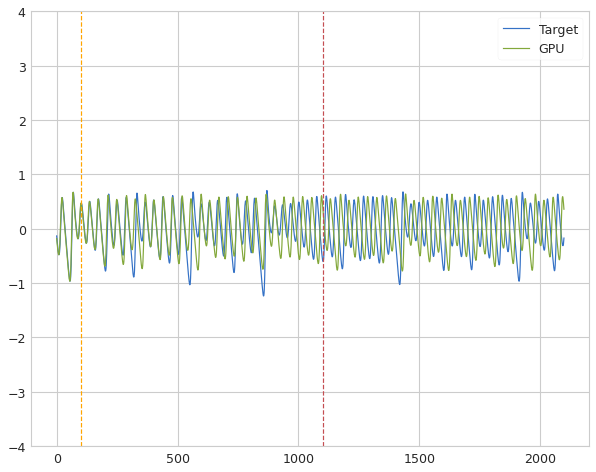

 Iter=82 a=0.641 sr=0.947 amp=1.585  ri=2.501 rr=2.934 loss=0.688362


Iter: 82 #### Diagnostic 0.688362   Time 4.50  Best 0.688 NRMSE 0.182 CD 0.506
Iter: 83 #### Diagnostic 1000.000000   Time 4.19  Best 0.688 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1000.000000   Time 4.11  Best 0.688 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000000   Time 4.08  Best 0.688 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1000.000000   Time 4.12  Best 0.688 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000000   Time 4.07  Best 0.688 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000000   Time 4.13  Best 0.688 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1000.000000   Time 4.10  Best 0.688 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1000.000000   Time 4.11  Best 0.688 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000000   Time 4.09  Best 0.688 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000000   Time 4.13  Best 0.688 NRMSE 1000.000 CD nan
Iter: 93 #### Diagno

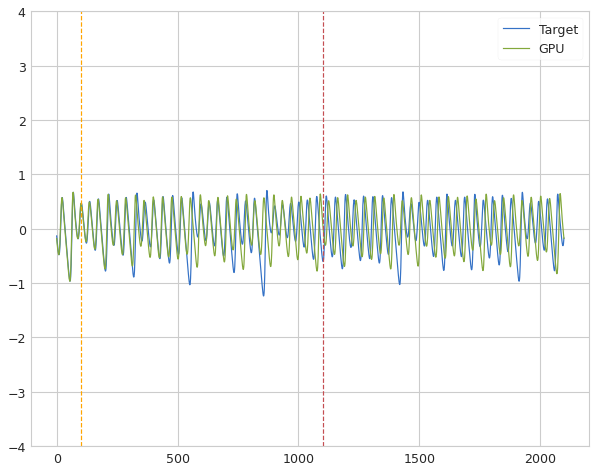

 Iter=36 a=0.654 sr=0.936 amp=1.471  ri=2.139 rr=2.167 loss=0.698853


Iter: 36 #### Diagnostic 0.698853   Time 4.49  Best 0.699 NRMSE 0.178 CD 0.521
Iter: 37 #### Diagnostic 1000.000000   Time 4.20  Best 0.699 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000000   Time 4.14  Best 0.699 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000000   Time 4.31  Best 0.699 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1.530019   Time 4.18  Best 0.699 NRMSE 0.531 CD 0.999
Iter: 41 #### Diagnostic 1.147187   Time 4.20  Best 0.699 NRMSE 0.234 CD 0.914
Iter: 42 #### Diagnostic 1.510618   Time 4.09  Best 0.699 NRMSE 0.514 CD 0.996
Iter: 43 #### Diagnostic 1.323151   Time 4.14  Best 0.699 NRMSE 0.260 CD 1.063
Iter: 44 #### Diagnostic 1000.000000   Time 4.49  Best 0.699 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 4.35  Best 0.699 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 4.31  Best 0.699 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000

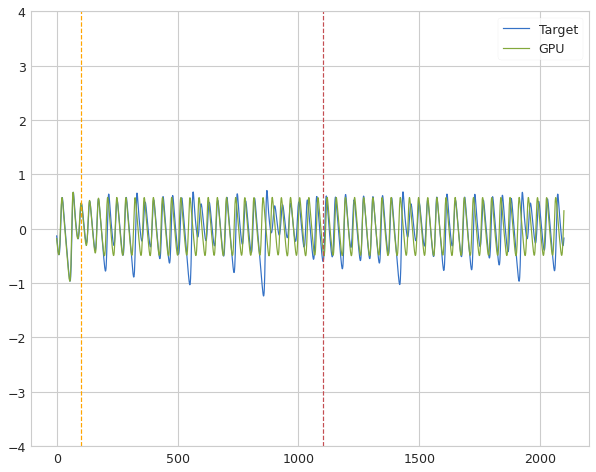

 Iter=70 a=0.664 sr=0.992 amp=1.583  ri=1.114 rr=0.357 loss=0.690735


Iter: 70 #### Diagnostic 0.690735   Time 4.85  Best 0.691 NRMSE 0.174 CD 0.516
Iter: 71 #### Diagnostic 1.313837   Time 4.22  Best 0.691 NRMSE 0.241 CD 1.073
Iter: 72 #### Diagnostic 1.153808   Time 4.13  Best 0.691 NRMSE 0.318 CD 0.836


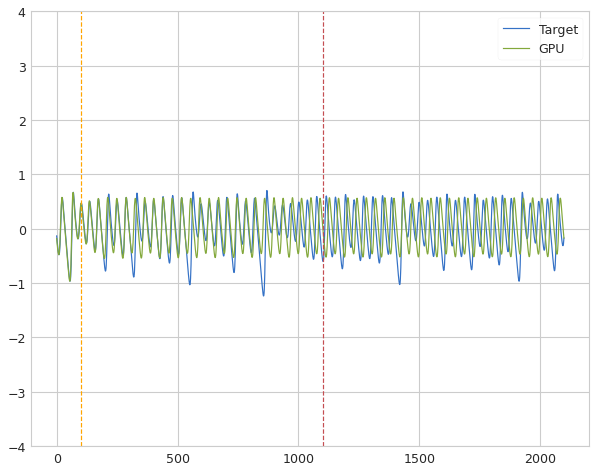

 Iter=73 a=0.582 sr=0.978 amp=1.678  ri=3.336 rr=1.318 loss=0.677038


Iter: 73 #### Diagnostic 0.677038   Time 4.58  Best 0.677 NRMSE 0.175 CD 0.502
Iter: 74 #### Diagnostic 1.267904   Time 4.14  Best 0.677 NRMSE 0.243 CD 1.025
Iter: 75 #### Diagnostic 1.322872   Time 4.13  Best 0.677 NRMSE 0.258 CD 1.065
Iter: 76 #### Diagnostic 1000.000000   Time 4.29  Best 0.677 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000000   Time 4.10  Best 0.677 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1000.000000   Time 4.07  Best 0.677 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 0.886152   Time 4.48  Best 0.677 NRMSE 0.215 CD 0.671
Iter: 80 #### Diagnostic 1000.000000   Time 4.53  Best 0.677 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1.173738   Time 4.18  Best 0.677 NRMSE 0.192 CD 0.982
Iter: 82 #### Diagnostic 1.183290   Time 4.11  Best 0.677 NRMSE 0.255 CD 0.928
Iter: 83 #### Diagnostic 0.969764   Time 4.20  Best 0.677 NRMSE 0.213 CD 0.756
Iter: 84 #### Diagnostic 1.240943   Time 4.8

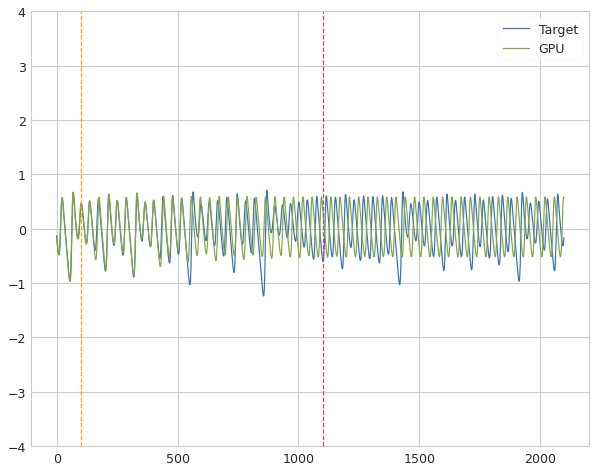

 Iter=21 a=0.620 sr=0.901 amp=1.452  ri=1.194 rr=1.076 loss=0.645503


Iter: 21 #### Diagnostic 0.645503   Time 4.81  Best 0.646 NRMSE 0.177 CD 0.468
Iter: 22 #### Diagnostic 1000.000000   Time 4.34  Best 0.646 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.463850   Time 4.48  Best 0.646 NRMSE 0.276 CD 1.187
Iter: 24 #### Diagnostic 1000.000000   Time 4.18  Best 0.646 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 0.918698   Time 4.10  Best 0.646 NRMSE 0.221 CD 0.698
Iter: 26 #### Diagnostic 1000.000000   Time 4.23  Best 0.646 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 0.777956   Time 4.20  Best 0.646 NRMSE 0.197 CD 0.581
Iter: 28 #### Diagnostic 1000.000000   Time 4.31  Best 0.646 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 4.58  Best 0.646 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 4.40  Best 0.646 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000000   Time 4.50  Best 0.646 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.00

Iter: 18 #### Diagnostic 1000.000000   Time 4.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 4.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 0.820485   Time 4.14  Best 1000.000 NRMSE 0.205 CD 0.615
Iter: 21 #### Diagnostic 1000.000000   Time 4.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 4.710110   Time 4.17  Best 1000.000 NRMSE 3.723 CD 0.987
Iter: 23 #### Diagnostic 1000.000000   Time 4.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1.507506   Time 4.05  Best 1000.000 NRMSE 0.518 CD 0.989
Iter: 25 #### Diagnostic 1000.000000   Time 4.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 4.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 4.16  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 4.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 4.44  Best 1000.000 NR

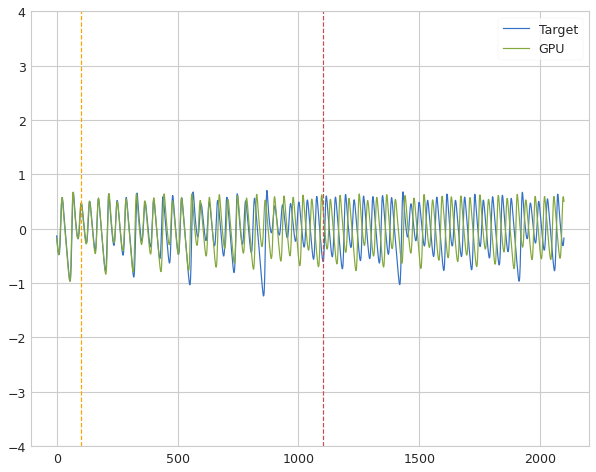

 Iter=53 a=0.620 sr=0.870 amp=1.677  ri=0.785 rr=1.810 loss=0.683827


Iter: 53 #### Diagnostic 0.683827   Time 4.48  Best 0.684 NRMSE 0.183 CD 0.501
Iter: 54 #### Diagnostic 1.452836   Time 4.17  Best 0.684 NRMSE 0.247 CD 1.206
Iter: 55 #### Diagnostic 1000.000000   Time 4.10  Best 0.684 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000000   Time 4.21  Best 0.684 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000000   Time 4.13  Best 0.684 NRMSE 1000.000 CD 1.050
Iter: 58 #### Diagnostic 1000.000000   Time 4.11  Best 0.684 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 4.20  Best 0.684 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 4.22  Best 0.684 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 4.10  Best 0.684 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 4.19  Best 0.684 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000000   Time 4.21  Best 0.684 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnost

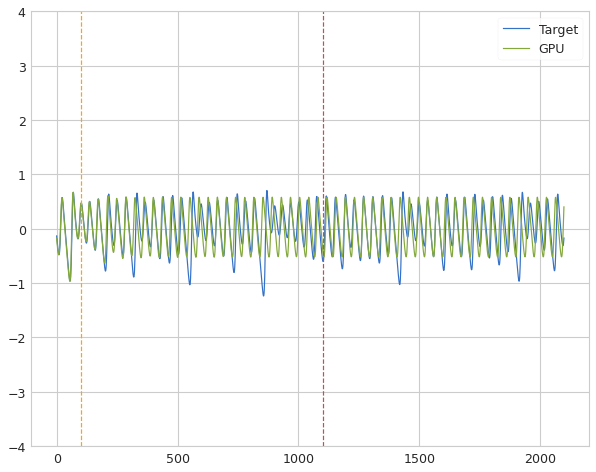

 Iter=14 a=0.606 sr=0.977 amp=1.457  ri=3.417 rr=1.715 loss=0.683095


Iter: 14 #### Diagnostic 0.683095   Time 4.55  Best 0.683 NRMSE 0.175 CD 0.508
Iter: 15 #### Diagnostic 1.506968   Time 4.32  Best 0.683 NRMSE 0.508 CD 0.999
Iter: 16 #### Diagnostic 0.767889   Time 4.37  Best 0.683 NRMSE 0.194 CD 0.574
Iter: 17 #### Diagnostic 1.390266   Time 4.16  Best 0.683 NRMSE 0.288 CD 1.102
Iter: 18 #### Diagnostic 1000.000000   Time 4.12  Best 0.683 NRMSE 29578.942 CD 1.005
Iter: 19 #### Diagnostic 1.511555   Time 4.13  Best 0.683 NRMSE 0.520 CD 0.992
Iter: 20 #### Diagnostic 1.073728   Time 4.36  Best 0.683 NRMSE 0.241 CD 0.833
Iter: 21 #### Diagnostic 1.371170   Time 4.27  Best 0.683 NRMSE 0.261 CD 1.110
Iter: 22 #### Diagnostic 1.166569   Time 4.11  Best 0.683 NRMSE 0.200 CD 0.967
Iter: 23 #### Diagnostic 1.997053   Time 4.07  Best 0.683 NRMSE 1.017 CD 0.980
Iter: 24 #### Diagnostic 1.175768   Time 4.08  Best 0.683 NRMSE 0.226 CD 0.950
Iter: 25 #### Diagnostic 1000.000000   Time 4.16  Bes

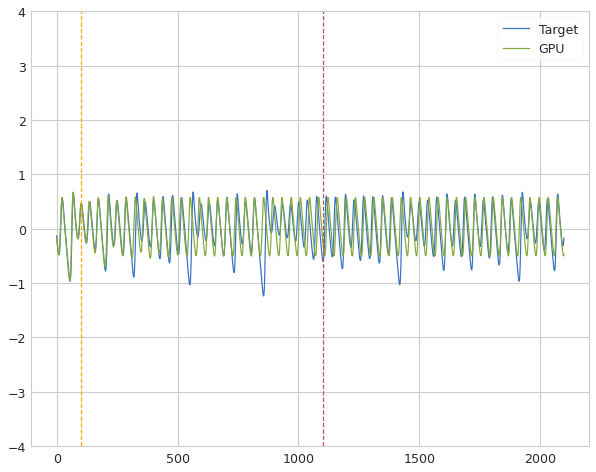

 Iter=60 a=0.696 sr=0.942 amp=1.498  ri=0.944 rr=3.603 loss=0.642738


Iter: 60 #### Diagnostic 0.642738   Time 4.59  Best 0.643 NRMSE 0.169 CD 0.474
Iter: 61 #### Diagnostic 0.985634   Time 4.18  Best 0.643 NRMSE 0.222 CD 0.764
Iter: 62 #### Diagnostic 1000.000000   Time 4.19  Best 0.643 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000000   Time 4.09  Best 0.643 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000000   Time 4.19  Best 0.643 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1.522127   Time 4.23  Best 0.643 NRMSE 0.530 CD 0.992
Iter: 66 #### Diagnostic 1000.000000   Time 4.14  Best 0.643 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 4.52  Best 0.643 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 4.41  Best 0.643 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000000   Time 4.15  Best 0.643 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 0.872698   Time 4.51  Best 0.643 NRMSE 0.217 CD 0.656
Iter: 71 #### Diagnostic 0.77815

Iter: 49 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1.182378   Time 3.89  Best 1000.000 NRMSE 0.226 CD 0.956
Iter: 51 #### Diagnostic 1.070597   Time 3.92  Best 1000.000 NRMSE 0.242 CD 0.828
Iter: 52 #### Diagnostic 1000.000000   Time 3.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 0.759954   Time 4.01  Best 1000.000 NRMSE 0.190 CD 0.570
Iter: 54 #### Diagnostic 1000.000000   Time 5.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000000   Time 5.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1.809210   Time 5.50  Best 1000.000 NRMSE 0.556 CD 1.253
Iter: 57 #### Diagnostic 1000.000000   Time 5.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 5.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 4.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 4.00  Best 1000.000 NRMSE 

Iter: 45 #### Diagnostic 1000.000000   Time 5.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1.292513   Time 5.66  Best 1000.000 NRMSE 0.226 CD 1.066
Iter: 47 #### Diagnostic 0.989614   Time 5.65  Best 1000.000 NRMSE 0.230 CD 0.760
Iter: 48 #### Diagnostic 1.509359   Time 4.94  Best 1000.000 NRMSE 0.516 CD 0.994
Iter: 49 #### Diagnostic 1000.000000   Time 4.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000000   Time 4.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1.260351   Time 3.91  Best 1000.000 NRMSE 0.250 CD 1.010
Iter: 54 #### Diagnostic 1000.000000   Time 3.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000000   Time 3.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1.152627   Time 3.92  Best 1000.000 NRMSE 0.1

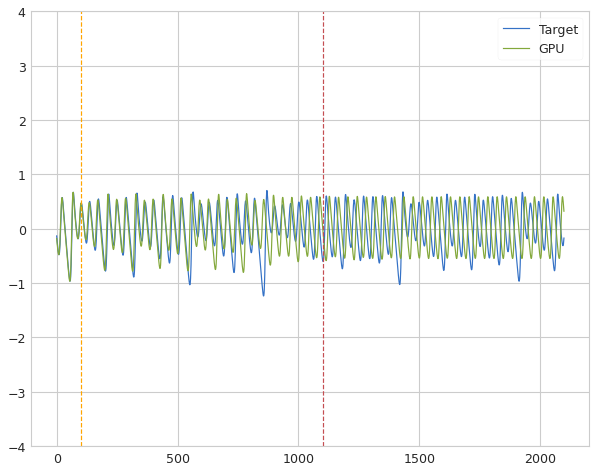

 Iter=68 a=0.570 sr=0.869 amp=1.508  ri=1.245 rr=2.310 loss=0.688891


Iter: 68 #### Diagnostic 0.688891   Time 4.31  Best 0.689 NRMSE 0.180 CD 0.509
Iter: 69 #### Diagnostic 1000.000000   Time 3.91  Best 0.689 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000000   Time 4.04  Best 0.689 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000000   Time 3.91  Best 0.689 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000000   Time 3.94  Best 0.689 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000000   Time 3.91  Best 0.689 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000000   Time 3.95  Best 0.689 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000000   Time 3.94  Best 0.689 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000000   Time 3.91  Best 0.689 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000000   Time 3.99  Best 0.689 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1.038680   Time 4.53  Best 0.689 NRMSE 0.178 CD 0.861
Iter: 79 #### Diagnostic

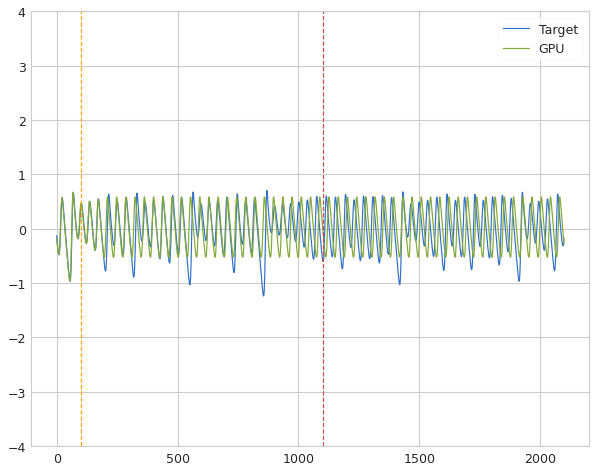

 Iter=27 a=0.574 sr=0.894 amp=1.612  ri=1.361 rr=2.787 loss=0.683814


Iter: 27 #### Diagnostic 0.683814   Time 4.27  Best 0.684 NRMSE 0.178 CD 0.506
Iter: 28 #### Diagnostic 1000.000000   Time 4.12  Best 0.684 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 3.98  Best 0.684 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1.525270   Time 3.95  Best 0.684 NRMSE 0.519 CD 1.007
Iter: 31 #### Diagnostic 1000.000000   Time 3.96  Best 0.684 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000000   Time 3.97  Best 0.684 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000000   Time 4.76  Best 0.684 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 0.877298   Time 5.06  Best 0.684 NRMSE 0.213 CD 0.664
Iter: 35 #### Diagnostic 1.101771   Time 5.72  Best 0.684 NRMSE 0.245 CD 0.857
Iter: 36 #### Diagnostic 1000.000000   Time 5.55  Best 0.684 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000000   Time 5.54  Best 0.684 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.00

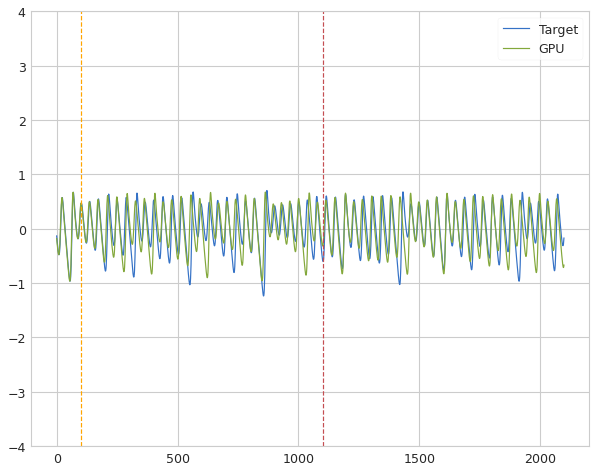

 Iter=73 a=0.622 sr=0.845 amp=1.630  ri=0.244 rr=0.677 loss=0.577698


Iter: 73 #### Diagnostic 0.577698   Time 6.01  Best 0.578 NRMSE 0.161 CD 0.417
Iter: 74 #### Diagnostic 1.089375   Time 4.86  Best 0.578 NRMSE 0.219 CD 0.870
Iter: 75 #### Diagnostic 1000.000000   Time 5.58  Best 0.578 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1.146265   Time 5.73  Best 0.578 NRMSE 0.214 CD 0.932
Iter: 77 #### Diagnostic 1000.000000   Time 5.14  Best 0.578 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1000.000000   Time 4.11  Best 0.578 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000000   Time 4.05  Best 0.578 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000000   Time 4.05  Best 0.578 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1.166290   Time 4.49  Best 0.578 NRMSE 0.198 CD 0.968
Iter: 82 #### Diagnostic 1000.000000   Time 5.62  Best 0.578 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1000.000000   Time 5.59  Best 0.578 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1.73494

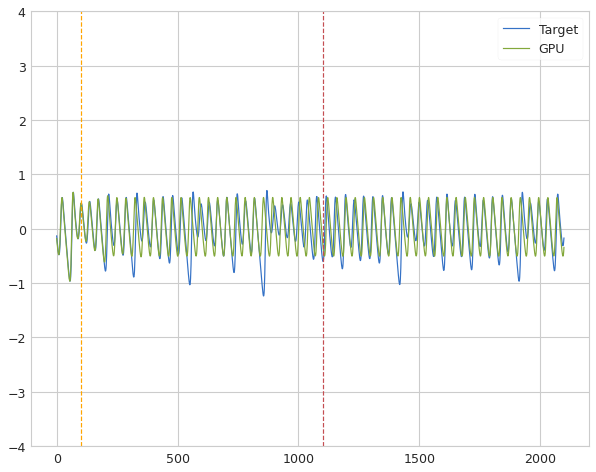

 Iter=52 a=0.567 sr=0.987 amp=1.462  ri=1.337 rr=3.881 loss=0.666171


Iter: 52 #### Diagnostic 0.666171   Time 4.35  Best 0.666 NRMSE 0.172 CD 0.494
Iter: 53 #### Diagnostic 1000.000000   Time 3.98  Best 0.666 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000000   Time 4.01  Best 0.666 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1.258621   Time 3.96  Best 0.666 NRMSE 0.266 CD 0.993
Iter: 56 #### Diagnostic 1000.000000   Time 3.99  Best 0.666 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000000   Time 3.96  Best 0.666 NRMSE 1000.000 CD 1.002
Iter: 58 #### Diagnostic 1000.000000   Time 3.95  Best 0.666 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 0.942219   Time 4.02  Best 0.666 NRMSE 0.240 CD 0.703
Iter: 60 #### Diagnostic 1000.000000   Time 4.00  Best 0.666 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1.229767   Time 3.98  Best 0.666 NRMSE 0.261 CD 0.968
Iter: 62 #### Diagnostic 1000.000000   Time 3.95  Best 0.666 NRMSE 1000.000 CD 1.001
Iter: 63 #### Diagnostic 100

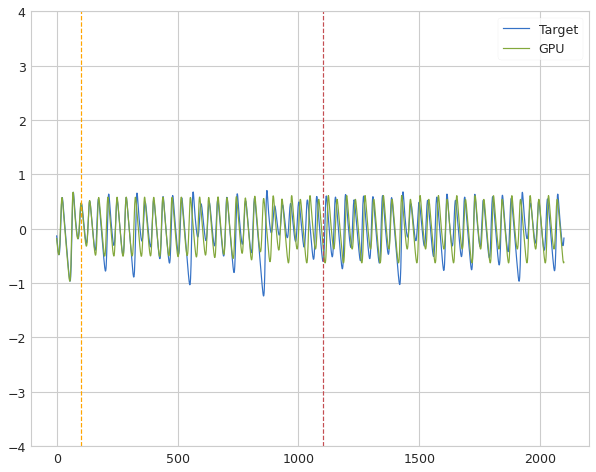

 Iter=79 a=0.680 sr=0.826 amp=1.673  ri=1.466 rr=2.045 loss=0.632634


Iter: 79 #### Diagnostic 0.632634   Time 4.29  Best 0.633 NRMSE 0.166 CD 0.467
Iter: 80 #### Diagnostic 1.479739   Time 4.25  Best 0.633 NRMSE 0.481 CD 0.999
Iter: 81 #### Diagnostic 1000.000000   Time 3.97  Best 0.633 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 0.892942   Time 4.02  Best 0.633 NRMSE 0.214 CD 0.679
Iter: 83 #### Diagnostic 0.893192   Time 3.90  Best 0.633 NRMSE 0.212 CD 0.681
Iter: 84 #### Diagnostic 1.516794   Time 3.94  Best 0.633 NRMSE 0.492 CD 1.025
Iter: 85 #### Diagnostic 0.749698   Time 3.92  Best 0.633 NRMSE 0.193 CD 0.557
Iter: 86 #### Diagnostic 1000.000000   Time 4.02  Best 0.633 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1.506993   Time 3.90  Best 0.633 NRMSE 0.509 CD 0.998
Iter: 88 #### Diagnostic 1000.000000   Time 4.01  Best 0.633 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 0.702860   Time 4.01  Best 0.633 NRMSE 0.184 CD 0.519
Iter: 90 #### Diagnostic 1000.000000   Time 4.02

Iter: 73 #### Diagnostic 1.091279   Time 5.60  Best 1000.000 NRMSE 0.226 CD 0.865
Iter: 74 #### Diagnostic 1000.000000   Time 5.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000000   Time 4.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000000   Time 4.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000000   Time 5.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 0.703436   Time 5.52  Best 1000.000 NRMSE 0.177 CD 0.527
Iter: 79 #### Diagnostic 1.493645   Time 5.56  Best 1000.000 NRMSE 0.502 CD 0.992
Iter: 80 #### Diagnostic 1.256724   Time 5.54  Best 1000.000 NRMSE 0.264 CD 0.993
Iter: 81 #### Diagnostic 1000.000000   Time 5.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 0.795215   Time 5.50  Best 1000.000 NRMSE 0.195 CD 0.600
Iter: 83 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1000.000000   Time 3.98  Best 1000.000 NRMSE 1000

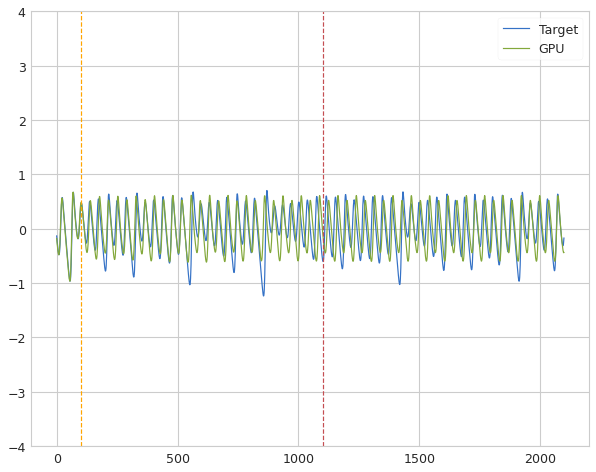

 Iter=50 a=0.670 sr=0.993 amp=1.530  ri=2.594 rr=1.976 loss=0.619489


Iter: 50 #### Diagnostic 0.619489   Time 4.30  Best 0.619 NRMSE 0.169 CD 0.451
Iter: 51 #### Diagnostic 1.285034   Time 3.94  Best 0.619 NRMSE 0.216 CD 1.069
Iter: 52 #### Diagnostic 1000.000000   Time 3.91  Best 0.619 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000000   Time 4.73  Best 0.619 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000000   Time 5.62  Best 0.619 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1.317232   Time 4.73  Best 0.619 NRMSE 0.332 CD 0.986
Iter: 56 #### Diagnostic 1000.000000   Time 3.84  Best 0.619 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1.517184   Time 4.01  Best 0.619 NRMSE 0.524 CD 0.993
Iter: 58 #### Diagnostic 1.570865   Time 4.80  Best 0.619 NRMSE 0.394 CD 1.177
Iter: 59 #### Diagnostic 1.381585   Time 5.64  Best 0.619 NRMSE 0.337 CD 1.045
Iter: 60 #### Diagnostic 1000.000000   Time 4.02  Best 0.619 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 0.919533   Time

Iter: 46 #### Diagnostic 0.930740   Time 4.93  Best 1000.000 NRMSE 0.219 CD 0.712
Iter: 47 #### Diagnostic 1000.000000   Time 4.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1.209429   Time 4.09  Best 1000.000 NRMSE 0.220 CD 0.990
Iter: 49 #### Diagnostic 1000.000000   Time 4.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000000   Time 3.92  Best 1000.000 NRMSE 1000.000 CD nan


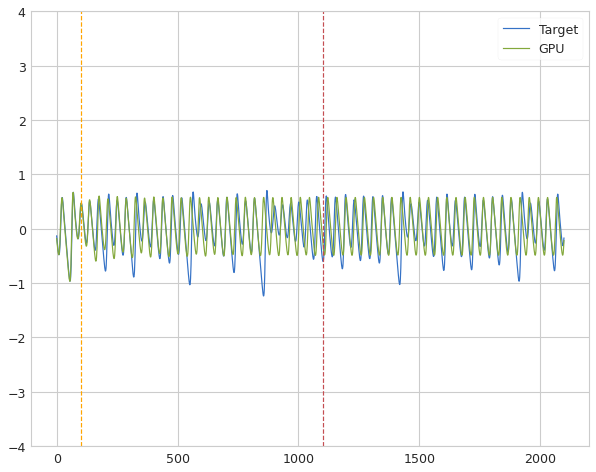

 Iter=51 a=0.645 sr=0.921 amp=1.495  ri=2.202 rr=2.540 loss=0.612439


Iter: 51 #### Diagnostic 0.612439   Time 4.36  Best 0.612 NRMSE 0.162 CD 0.450
Iter: 52 #### Diagnostic 0.683518   Time 4.02  Best 0.612 NRMSE 0.174 CD 0.510
Iter: 53 #### Diagnostic 1000.000000   Time 4.03  Best 0.612 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000000   Time 3.84  Best 0.612 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1.225170   Time 3.95  Best 0.612 NRMSE 0.251 CD 0.974
Iter: 56 #### Diagnostic 0.889113   Time 3.89  Best 0.612 NRMSE 0.207 CD 0.682
Iter: 57 #### Diagnostic 1.483922   Time 3.93  Best 0.612 NRMSE 0.486 CD 0.998
Iter: 58 #### Diagnostic 1000.000000   Time 4.02  Best 0.612 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1.283042   Time 3.86  Best 0.612 NRMSE 0.245 CD 1.038
Iter: 60 #### Diagnostic 1000.000000   Time 3.96  Best 0.612 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 3.88  Best 0.612 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   T

Iter: 47 #### Diagnostic 1.517710   Time 3.94  Best 1000.000 NRMSE 0.508 CD 1.010
Iter: 48 #### Diagnostic 1000.000000   Time 4.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1.277157   Time 5.62  Best 1000.000 NRMSE 0.227 CD 1.050
Iter: 50 #### Diagnostic 1000.000000   Time 5.49  Best 1000.000 NRMSE 1000.000 CD nan


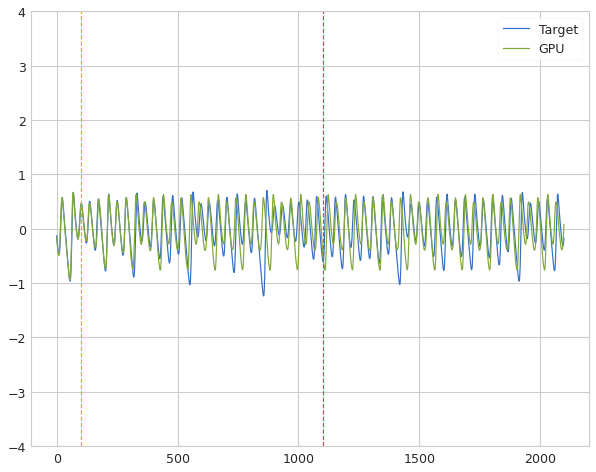

 Iter=51 a=0.600 sr=0.969 amp=1.522  ri=3.427 rr=3.186 loss=0.594388


Iter: 51 #### Diagnostic 0.594388   Time 5.96  Best 0.594 NRMSE 0.161 CD 0.434
Iter: 52 #### Diagnostic 1.109546   Time 4.69  Best 0.594 NRMSE 0.183 CD 0.926
Iter: 53 #### Diagnostic 1000.000000   Time 4.65  Best 0.594 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1.318905   Time 5.69  Best 0.594 NRMSE 0.236 CD 1.083
Iter: 55 #### Diagnostic 1000.000000   Time 4.70  Best 0.594 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1.987173   Time 4.14  Best 0.594 NRMSE 0.964 CD 1.023
Iter: 57 #### Diagnostic 1000.000000   Time 4.14  Best 0.594 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 4.15  Best 0.594 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 0.679717   Time 3.96  Best 0.594 NRMSE 0.186 CD 0.494
Iter: 60 #### Diagnostic 1000.000000   Time 4.82  Best 0.594 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 0.759085   Time 4.51  Best 0.594 NRMSE 0.188 CD 0.571
Iter: 62 #### Diagnostic 1000.000000   T

Iter: 47 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 4.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 0.829087   Time 3.94  Best 1000.000 NRMSE 0.205 CD 0.624
Iter: 50 #### Diagnostic 1000.000000   Time 3.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 2.098267   Time 3.97  Best 1000.000 NRMSE 0.907 CD 1.191
Iter: 52 #### Diagnostic 1000.000000   Time 4.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 0.823529   Time 3.93  Best 1000.000 NRMSE 0.202 CD 0.621
Iter: 54 #### Diagnostic 1.298717   Time 3.89  Best 1000.000 NRMSE 0.251 CD 1.048
Iter: 55 #### Diagnostic 1.228873   Time 3.90  Best 1000.000 NRMSE 0.277 CD 0.952
Iter: 56 #### Diagnostic 0.892707   Time 3.94  Best 1000.000 NRMSE 0.214 CD 0.678
Iter: 57 #### Diagnostic 1000.000000   Time 3.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1.272325   Time 4.00  Best 1000.000 NRMSE 0.252 CD 1.

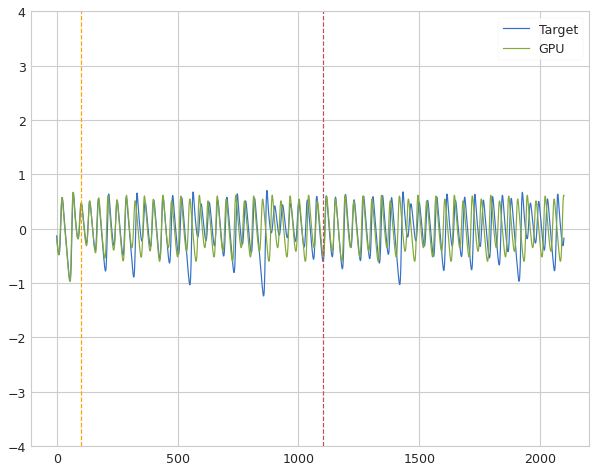

 Iter=35 a=0.622 sr=0.955 amp=1.653  ri=2.101 rr=2.390 loss=0.682984


Iter: 35 #### Diagnostic 0.682984   Time 6.37  Best 0.683 NRMSE 0.172 CD 0.511
Iter: 36 #### Diagnostic 1000.000000   Time 6.04  Best 0.683 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1.525292   Time 6.03  Best 0.683 NRMSE 0.528 CD 0.998
Iter: 38 #### Diagnostic 0.743016   Time 6.63  Best 0.683 NRMSE 0.181 CD 0.562
Iter: 39 #### Diagnostic 15.624393   Time 7.69  Best 0.683 NRMSE 14.567 CD 1.058
Iter: 40 #### Diagnostic 1000.000000   Time 6.48  Best 0.683 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1.213506   Time 5.42  Best 0.683 NRMSE 0.288 CD 0.926
Iter: 42 #### Diagnostic 2.229180   Time 5.26  Best 0.683 NRMSE 1.235 CD 0.994
Iter: 43 #### Diagnostic 1000.000000   Time 5.80  Best 0.683 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1.136171   Time 6.20  Best 0.683 NRMSE 0.198 CD 0.938
Iter: 45 #### Diagnostic 1000.000000   Time 7.52  Best 0.683 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Tim

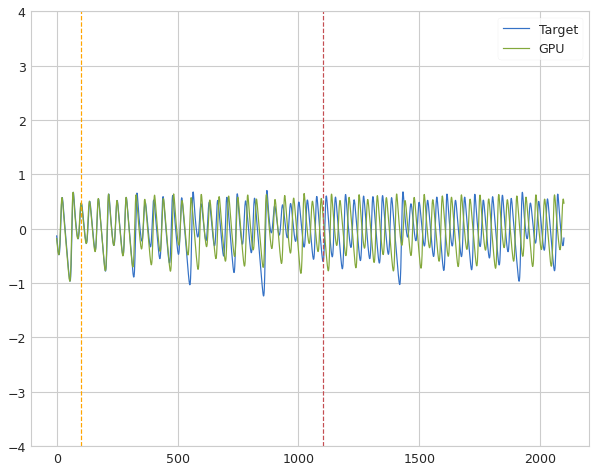

 Iter=15 a=0.563 sr=0.858 amp=1.433  ri=0.559 rr=2.445 loss=0.694669


Iter: 15 #### Diagnostic 0.694669   Time 4.28  Best 0.695 NRMSE 0.186 CD 0.508


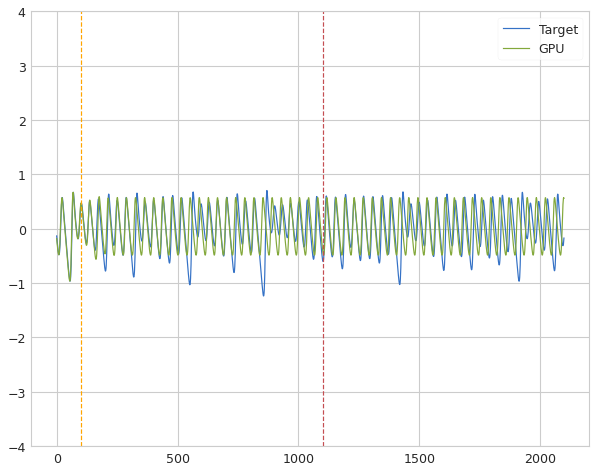

 Iter=16 a=0.608 sr=0.886 amp=1.565  ri=1.583 rr=1.638 loss=0.619288


Iter: 16 #### Diagnostic 0.619288   Time 5.83  Best 0.619 NRMSE 0.163 CD 0.457
Iter: 17 #### Diagnostic 1000.000000   Time 5.71  Best 0.619 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1.168971   Time 5.59  Best 0.619 NRMSE 0.215 CD 0.954
Iter: 19 #### Diagnostic 1000.000000   Time 4.72  Best 0.619 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1.193840   Time 3.95  Best 0.619 NRMSE 0.214 CD 0.980
Iter: 21 #### Diagnostic 1000.000000   Time 4.04  Best 0.619 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1.520779   Time 3.85  Best 0.619 NRMSE 0.523 CD 0.998
Iter: 23 #### Diagnostic 1000.000000   Time 3.84  Best 0.619 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 3.90  Best 0.619 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 0.906635   Time 3.89  Best 0.619 NRMSE 0.217 CD 0.690
Iter: 26 #### Diagnostic 1.173091   Time 3.93  Best 0.619 NRMSE 0.246 CD 0.927
Iter: 27 #### Diagnostic 1000.000000   T

Iter: 12 #### Diagnostic 1000.000000   Time 4.73  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1.269833   Time 4.85  Best 1000.000 NRMSE 0.222 CD 1.048
Iter: 14 #### Diagnostic 1.197720   Time 4.36  Best 1000.000 NRMSE 0.217 CD 0.981
Iter: 15 #### Diagnostic 1000.000000   Time 5.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 6.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 5.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000000   Time 4.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 0.974581   Time 5.00  Best 1000.000 NRMSE 0.225 CD 0.749


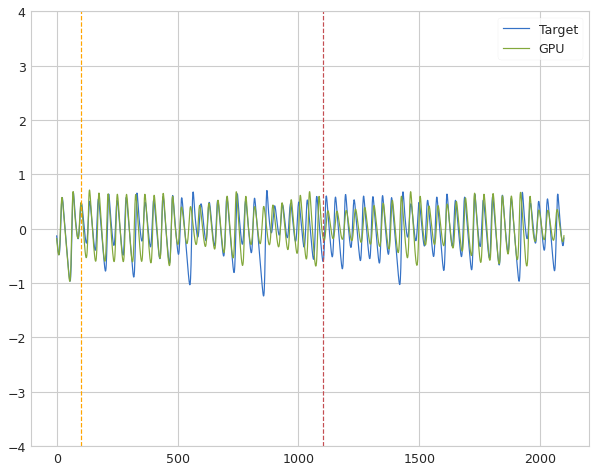

 Iter=20 a=0.616 sr=0.896 amp=1.417  ri=1.458 rr=1.331 loss=0.585843


Iter: 20 #### Diagnostic 0.585843   Time 7.12  Best 0.586 NRMSE 0.158 CD 0.428
Iter: 21 #### Diagnostic 1000.000000   Time 4.98  Best 0.586 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 5.40  Best 0.586 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 5.27  Best 0.586 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 5.73  Best 0.586 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 5.00  Best 0.586 NRMSE 60645379065520935298662400.000 CD 0.992
Iter: 26 #### Diagnostic 1000.000000   Time 5.52  Best 0.586 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 4.72  Best 0.586 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 5.509391   Time 5.52  Best 0.586 NRMSE 4.595 CD 0.914
Iter: 29 #### Diagnostic 1.160415   Time 5.23  Best 0.586 NRMSE 0.229 CD 0.931
Iter: 30 #### Diagnostic 0.802125   Time 4.54  Best 0.586 NRMSE 0.203 CD 0.599
Iter: 31

Iter: 17 #### Diagnostic 1000.000000   Time 5.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000000   Time 4.76  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1.219032   Time 5.95  Best 1000.000 NRMSE 0.202 CD 1.017
Iter: 20 #### Diagnostic 1.239558   Time 5.40  Best 1000.000 NRMSE 0.243 CD 0.997
Iter: 21 #### Diagnostic 1000.000000   Time 5.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 32.859943   Time 5.34  Best 1000.000 NRMSE 31.830 CD 1.030
Iter: 23 #### Diagnostic 0.819503   Time 5.04  Best 1000.000 NRMSE 0.206 CD 0.614
Iter: 24 #### Diagnostic 0.841381   Time 5.89  Best 1000.000 NRMSE 0.197 CD 0.644
Iter: 25 #### Diagnostic 1000.000000   Time 5.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 5.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1.349365   Time 5.23  Best 1000.000 NRMSE 0.262 CD 1.087
Iter: 28 #### Diagnostic 1000.000000   Time 4.97  Best 1000.000 NRMSE 1000.0

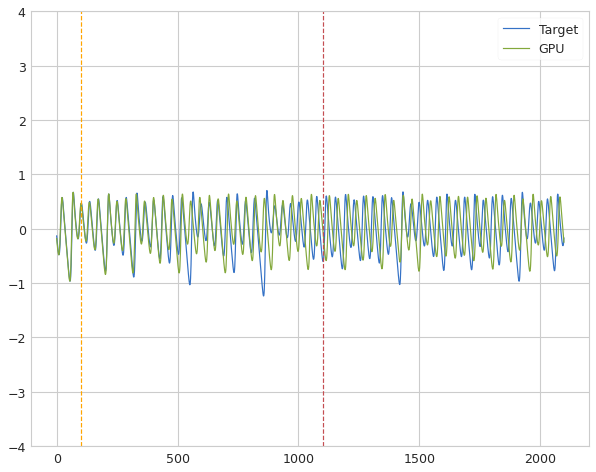

 Iter=52 a=0.566 sr=0.943 amp=1.649  ri=2.539 rr=1.362 loss=0.686272


Iter: 52 #### Diagnostic 0.686272   Time 5.92  Best 0.686 NRMSE 0.178 CD 0.509
Iter: 53 #### Diagnostic 0.717545   Time 5.52  Best 0.686 NRMSE 0.185 CD 0.533
Iter: 54 #### Diagnostic 1000.000000   Time 5.82  Best 0.686 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000000   Time 6.29  Best 0.686 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 2.200421   Time 5.63  Best 0.686 NRMSE 1.157 CD 1.043
Iter: 57 #### Diagnostic 1000.000000   Time 5.51  Best 0.686 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1.298371   Time 4.81  Best 0.686 NRMSE 0.226 CD 1.073
Iter: 59 #### Diagnostic 1.206868   Time 4.76  Best 0.686 NRMSE 0.225 CD 0.981
Iter: 60 #### Diagnostic 1000.000000   Time 6.39  Best 0.686 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 5.09  Best 0.686 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 5.16  Best 0.686 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000000

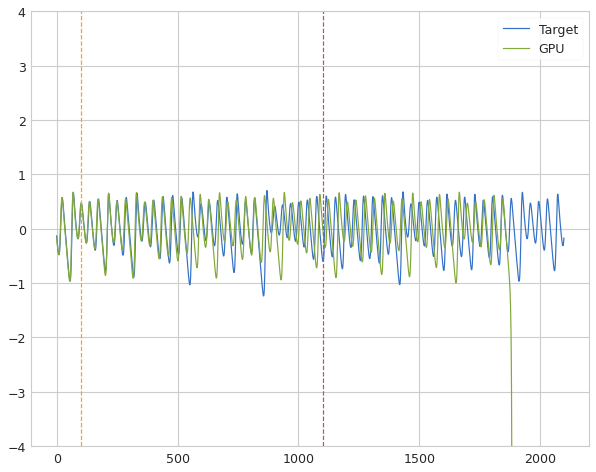

 Iter=7 a=0.608 sr=0.867 amp=1.471  ri=2.099 rr=1.273 loss=0.699091


Iter: 7 #### Diagnostic 0.699091   Time 4.97  Best 0.699 NRMSE 0.181 CD 0.518
Iter: 8 #### Diagnostic 1000.000000   Time 5.05  Best 0.699 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000000   Time 4.80  Best 0.699 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 0.725520   Time 4.77  Best 0.699 NRMSE 0.181 CD 0.544
Iter: 11 #### Diagnostic 1000.000000   Time 5.82  Best 0.699 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 5.58  Best 0.699 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000000   Time 4.72  Best 0.699 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1.210844   Time 5.50  Best 0.699 NRMSE 0.230 CD 0.981
Iter: 15 #### Diagnostic 1000.000000   Time 5.04  Best 0.699 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 0.878324   Time 5.35  Best 0.699 NRMSE 0.213 CD 0.665
Iter: 17 #### Diagnostic 1.035559   Time 5.44  Best 0.699 NRMSE 0.209 CD 0.827
Iter: 18 #### Diagnostic 1000.000000   T

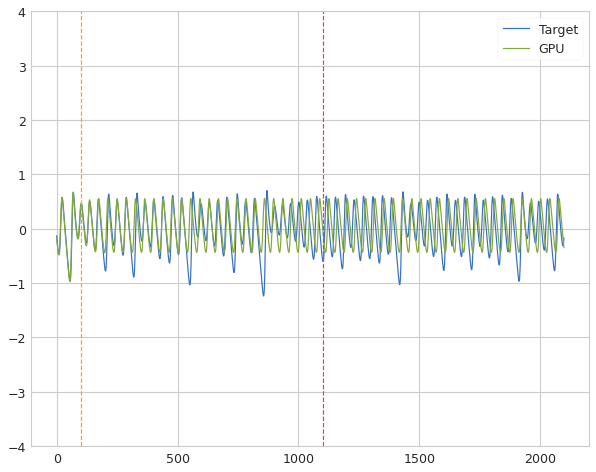

 Iter=92 a=0.668 sr=0.811 amp=1.464  ri=2.084 rr=0.665 loss=0.623751


Iter: 92 #### Diagnostic 0.623751   Time 9.14  Best 0.624 NRMSE 0.162 CD 0.462
Iter: 93 #### Diagnostic 22.637324   Time 10.54  Best 0.624 NRMSE 21.638 CD 0.999
Iter: 94 #### Diagnostic 3.024324   Time 9.45  Best 0.624 NRMSE 2.054 CD 0.970
Iter: 95 #### Diagnostic 1.514233   Time 10.25  Best 0.624 NRMSE 0.507 CD 1.008
Iter: 96 #### Diagnostic 1000.000000   Time 11.10  Best 0.624 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000000   Time 7.22  Best 0.624 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1000.000000   Time 9.79  Best 0.624 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1.145236   Time 7.56  Best 0.624 NRMSE 0.196 CD 0.949

Best result = 0.6237507557119538
a = 0.668186108048298
sr = 0.8109827169499769
amp = 1.4636339082790821
ri = 2.084428901855817
rr = 0.6651363768919568
********** Size 40 -- Run 4 ***********
Iter: 0 #### Diagnostic 1.443934   Time 10.72  Best 1000.000 NRMSE 0.434 CD 1.010
Iter: 

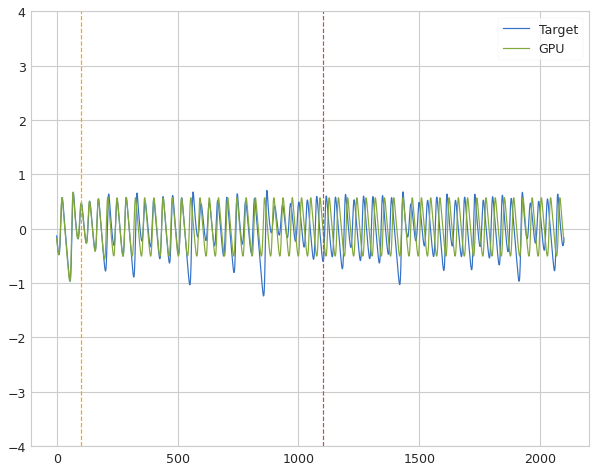

 Iter=25 a=0.588 sr=0.885 amp=1.567  ri=0.853 rr=0.777 loss=0.646765


Iter: 25 #### Diagnostic 0.646765   Time 5.50  Best 0.647 NRMSE 0.170 CD 0.476
Iter: 26 #### Diagnostic 1.208138   Time 5.32  Best 0.647 NRMSE 0.213 CD 0.995
Iter: 27 #### Diagnostic 1000.000000   Time 5.07  Best 0.647 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 4.69  Best 0.647 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 4.93  Best 0.647 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1.528713   Time 5.79  Best 0.647 NRMSE 0.530 CD 0.999
Iter: 31 #### Diagnostic 1.025757   Time 6.16  Best 0.647 NRMSE 0.199 CD 0.826
Iter: 32 #### Diagnostic 1000.000000   Time 5.40  Best 0.647 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 0.952068   Time 5.50  Best 0.647 NRMSE 0.225 CD 0.727
Iter: 34 #### Diagnostic 1000.000000   Time 5.19  Best 0.647 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1.190792   Time 4.71  Best 0.647 NRMSE 0.203 CD 0.988
Iter: 36 #### Diagnostic 1000.000000   T

Iter: 15 #### Diagnostic 1000.000000   Time 4.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 4.45  Best 1000.000 NRMSE 1000.000 CD 1.000
Iter: 17 #### Diagnostic 1000.000000   Time 5.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1.251943   Time 5.19  Best 1000.000 NRMSE 0.246 CD 1.006
Iter: 19 #### Diagnostic 1000.000000   Time 5.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000000   Time 4.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000000   Time 5.76  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 25.203087   Time 5.20  Best 1000.000 NRMSE 24.209 CD 0.994
Iter: 23 #### Diagnostic 1000.000000   Time 5.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1.468674   Time 4.82  Best 1000.000 NRMSE 0.414 CD 1.055
Iter: 25 #### Diagnostic 0.870021   Time 5.59  Best 1000.000 NRMSE 0.211 CD 0.659
Iter: 26 #### Diagnostic 1.148043   Time 5.92  Best 1000.000 NRMSE

Iter: 10 #### Diagnostic 1000.000000   Time 4.77  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.399072   Time 5.73  Best 1000.000 NRMSE 0.423 CD 0.976
Iter: 12 #### Diagnostic 1000.000000   Time 4.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000000   Time 4.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 0.894574   Time 5.87  Best 1000.000 NRMSE 0.196 CD 0.699
Iter: 15 #### Diagnostic 0.812412   Time 5.33  Best 1000.000 NRMSE 0.202 CD 0.611
Iter: 16 #### Diagnostic 1000.000000   Time 5.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1.527752   Time 5.82  Best 1000.000 NRMSE 0.528 CD 1.000
Iter: 18 #### Diagnostic 1000.000000   Time 5.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 4.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000000   Time 5.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 11.679172   Time 4.94  Best 1000.000 NRMSE 10

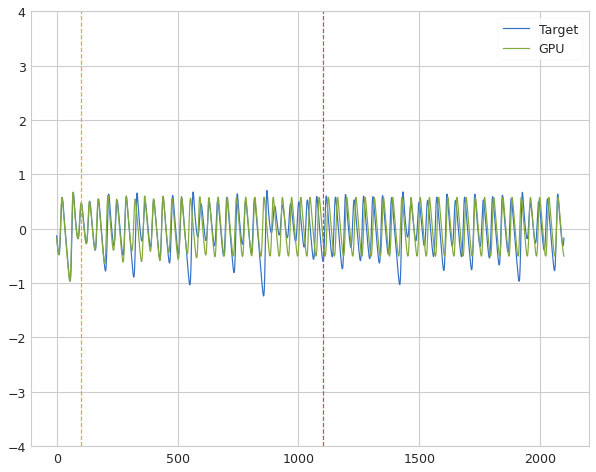

 Iter=34 a=0.623 sr=0.807 amp=1.623  ri=1.195 rr=2.594 loss=0.636001


Iter: 34 #### Diagnostic 0.636001   Time 5.96  Best 0.636 NRMSE 0.167 CD 0.469
Iter: 35 #### Diagnostic 1000.000000   Time 5.37  Best 0.636 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 0.821783   Time 6.02  Best 0.636 NRMSE 0.206 CD 0.616
Iter: 37 #### Diagnostic 1000.000000   Time 4.78  Best 0.636 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000000   Time 4.81  Best 0.636 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000000   Time 5.25  Best 0.636 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000000   Time 5.43  Best 0.636 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1.263338   Time 5.63  Best 0.636 NRMSE 0.340 CD 0.923
Iter: 42 #### Diagnostic 1000.000000   Time 4.92  Best 0.636 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000000   Time 5.03  Best 0.636 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000000   Time 5.32  Best 0.636 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 111

Iter: 30 #### Diagnostic 1.272587   Time 5.26  Best 1000.000 NRMSE 0.273 CD 1.000
Iter: 31 #### Diagnostic 1000.000000   Time 5.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.498698   Time 5.81  Best 1000.000 NRMSE 0.513 CD 0.986
Iter: 33 #### Diagnostic 0.749152   Time 5.01  Best 1000.000 NRMSE 0.189 CD 0.560
Iter: 34 #### Diagnostic 1000.000000   Time 5.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1.493077   Time 5.98  Best 1000.000 NRMSE 0.485 CD 1.008
Iter: 36 #### Diagnostic 1.109111   Time 5.50  Best 1000.000 NRMSE 0.180 CD 0.929
Iter: 37 #### Diagnostic 1000.000000   Time 5.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 0.865148   Time 5.25  Best 1000.000 NRMSE 0.215 CD 0.650
Iter: 39 #### Diagnostic 2.210382   Time 5.22  Best 1000.000 NRMSE 1.166 CD 1.045
Iter: 40 #### Diagnostic 1000.000000   Time 5.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000000   Time 4.52  Best 1000.000 NRMSE 1000.000 CD 

Iter: 26 #### Diagnostic 1000.000000   Time 4.77  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 5.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1.338624   Time 5.48  Best 1000.000 NRMSE 0.286 CD 1.052
Iter: 29 #### Diagnostic 1.511633   Time 4.84  Best 1000.000 NRMSE 0.520 CD 0.992
Iter: 30 #### Diagnostic 1000.000000   Time 5.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1.147503   Time 5.03  Best 1000.000 NRMSE 0.182 CD 0.965
Iter: 32 #### Diagnostic 1000.000000   Time 5.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000000   Time 5.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000000   Time 5.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000000   Time 6.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 7.901540   Time 5.81  Best 1000.000 NRMSE 6.894 CD 1.008
Iter: 37 #### Diagnostic 1.135700   Time 4.96  Best 1000.000 NRMSE 0.1

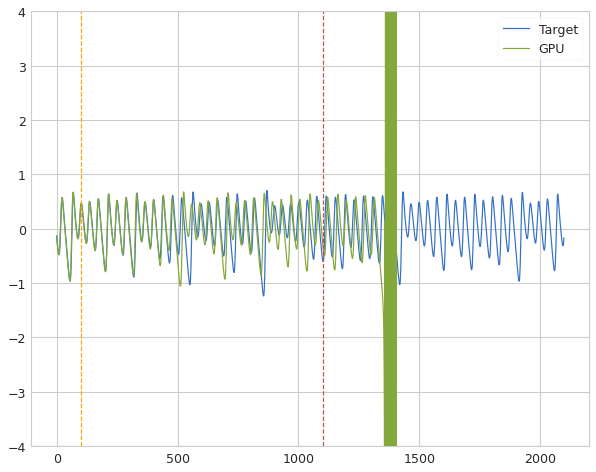

 Iter=60 a=0.564 sr=0.953 amp=1.452  ri=0.874 rr=1.993 loss=0.608054


Iter: 60 #### Diagnostic 0.608054   Time 6.20  Best 0.608 NRMSE 0.166 CD 0.442
Iter: 61 #### Diagnostic 2.496699   Time 5.22  Best 0.608 NRMSE 1.541 CD 0.955
Iter: 62 #### Diagnostic 1000.000000   Time 5.24  Best 0.608 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1.138722   Time 5.23  Best 0.608 NRMSE 0.232 CD 0.907
Iter: 64 #### Diagnostic 4.024555   Time 5.02  Best 0.608 NRMSE 2.965 CD 1.060
Iter: 65 #### Diagnostic 1000.000000   Time 7.18  Best 0.608 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1.046458   Time 4.95  Best 0.608 NRMSE 0.212 CD 0.835
Iter: 67 #### Diagnostic 1000.000000   Time 5.57  Best 0.608 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 5.34  Best 0.608 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1.406372   Time 5.21  Best 0.608 NRMSE 0.250 CD 1.156
Iter: 70 #### Diagnostic 1000.000000   Time 4.94  Best 0.608 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1.302414   Time

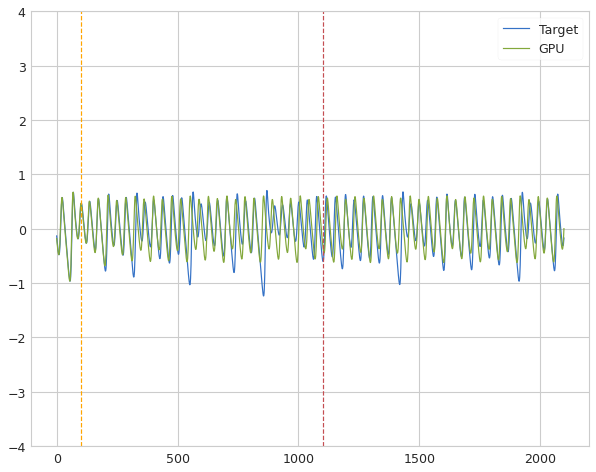

 Iter=28 a=0.580 sr=0.991 amp=1.432  ri=2.537 rr=2.010 loss=0.653152


Iter: 28 #### Diagnostic 0.653152   Time 6.23  Best 0.653 NRMSE 0.172 CD 0.481
Iter: 29 #### Diagnostic 1.435058   Time 5.19  Best 0.653 NRMSE 0.285 CD 1.150
Iter: 30 #### Diagnostic 3.054622   Time 5.05  Best 0.653 NRMSE 2.039 CD 1.016
Iter: 31 #### Diagnostic 1000.000000   Time 5.25  Best 0.653 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000000   Time 5.94  Best 0.653 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000000   Time 5.28  Best 0.653 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000000   Time 4.75  Best 0.653 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000000   Time 5.45  Best 0.653 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000000   Time 5.10  Best 0.653 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1.511944   Time 5.06  Best 0.653 NRMSE 0.516 CD 0.996
Iter: 38 #### Diagnostic 1000.000000   Time 4.98  Best 0.653 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.00

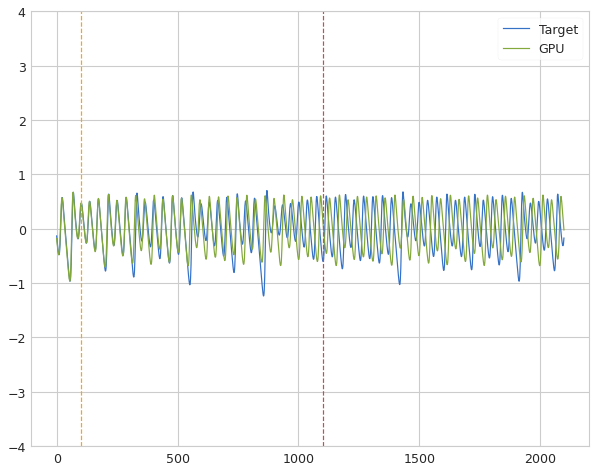

 Iter=60 a=0.696 sr=0.942 amp=1.498  ri=0.944 rr=3.603 loss=0.629651


Iter: 60 #### Diagnostic 0.629651   Time 5.97  Best 0.630 NRMSE 0.174 CD 0.456
Iter: 61 #### Diagnostic 1.302848   Time 5.59  Best 0.630 NRMSE 0.229 CD 1.074
Iter: 62 #### Diagnostic 1000.000000   Time 4.97  Best 0.630 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1.506440   Time 5.06  Best 0.630 NRMSE 0.510 CD 0.996
Iter: 64 #### Diagnostic 1.039891   Time 4.60  Best 0.630 NRMSE 0.224 CD 0.816
Iter: 65 #### Diagnostic 1000.000000   Time 4.87  Best 0.630 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000000   Time 5.01  Best 0.630 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 5.63  Best 0.630 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 0.929160   Time 5.42  Best 0.630 NRMSE 0.221 CD 0.708
Iter: 69 #### Diagnostic 1.407154   Time 5.12  Best 0.630 NRMSE 0.267 CD 1.140
Iter: 70 #### Diagnostic 1.370839   Time 4.86  Best 0.630 NRMSE 0.260 CD 1.111
Iter: 71 #### Diagnostic 1000.000000   Time 

Iter: 49 #### Diagnostic 1000.000000   Time 5.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1.429616   Time 4.60  Best 1000.000 NRMSE 0.308 CD 1.121
Iter: 51 #### Diagnostic 1.512323   Time 4.85  Best 1000.000 NRMSE 0.509 CD 1.003
Iter: 52 #### Diagnostic 1000.000000   Time 5.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1.163750   Time 4.78  Best 1000.000 NRMSE 0.214 CD 0.950
Iter: 54 #### Diagnostic 1000.000000   Time 5.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000000   Time 5.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1.154671   Time 5.43  Best 1000.000 NRMSE 0.186 CD 0.968
Iter: 57 #### Diagnostic 1.521502   Time 5.05  Best 1000.000 NRMSE 0.626 CD 0.896
Iter: 58 #### Diagnostic 1000.000000   Time 4.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 79.138031   Time 5.18  Best 1000.000 NRMSE 78.130 CD 1.008
Iter: 60 #### Diagnostic 1000.000000   Time 5.64  Best 1000.000 NRMSE 1000.0

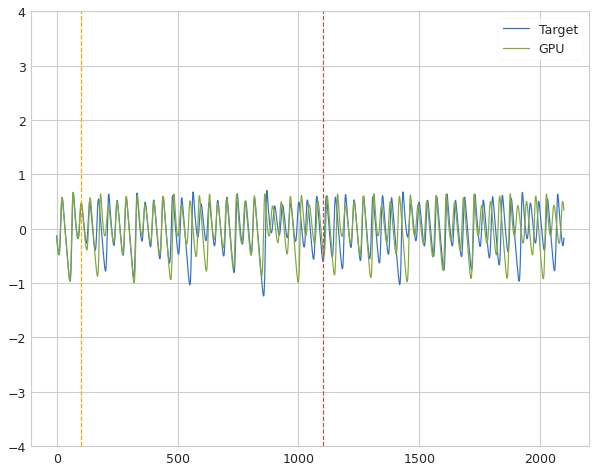

 Iter=23 a=0.695 sr=0.878 amp=1.641  ri=1.238 rr=0.943 loss=0.606295


Iter: 23 #### Diagnostic 0.606295   Time 5.45  Best 0.606 NRMSE 0.164 CD 0.442
Iter: 24 #### Diagnostic 1000.000000   Time 4.81  Best 0.606 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 5.04  Best 0.606 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 4.89  Best 0.606 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1.260456   Time 5.01  Best 0.606 NRMSE 0.317 CD 0.944
Iter: 28 #### Diagnostic 1000.000000   Time 5.09  Best 0.606 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 5.29  Best 0.606 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1.212496   Time 6.47  Best 0.606 NRMSE 0.218 CD 0.994
Iter: 31 #### Diagnostic 1.024240   Time 4.97  Best 0.606 NRMSE 0.216 CD 0.808
Iter: 32 #### Diagnostic 1000.000000   Time 4.64  Best 0.606 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1.188894   Time 5.47  Best 0.606 NRMSE 0.204 CD 0.985
Iter: 34 #### Diagnostic 1000.000000

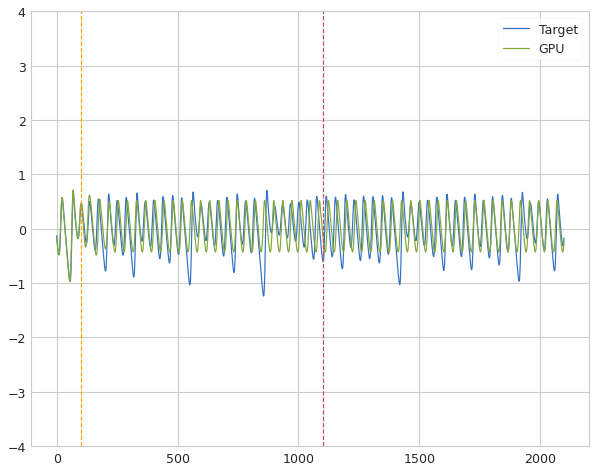

 Iter=17 a=0.604 sr=0.905 amp=1.527  ri=3.279 rr=2.286 loss=0.623873


Iter: 17 #### Diagnostic 0.623873   Time 5.14  Best 0.624 NRMSE 0.163 CD 0.461
Iter: 18 #### Diagnostic 1000.000000   Time 5.56  Best 0.624 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1.229686   Time 4.73  Best 0.624 NRMSE 0.242 CD 0.988
Iter: 20 #### Diagnostic 1000.000000   Time 4.74  Best 0.624 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1.524868   Time 5.30  Best 0.624 NRMSE 0.528 CD 0.997
Iter: 22 #### Diagnostic 1.856587   Time 4.96  Best 0.624 NRMSE 0.886 CD 0.971
Iter: 23 #### Diagnostic 1000.000000   Time 6.00  Best 0.624 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 5.14  Best 0.624 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1.338339   Time 4.57  Best 0.624 NRMSE 0.394 CD 0.944
Iter: 26 #### Diagnostic 1.386793   Time 4.63  Best 0.624 NRMSE 0.302 CD 1.085
Iter: 27 #### Diagnostic 1.159608   Time 6.06  Best 0.624 NRMSE 0.220 CD 0.939
Iter: 28 #### Diagnostic 1000.000000   Time 

Iter: 14 #### Diagnostic 1000.000000   Time 5.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1.182675   Time 5.16  Best 1000.000 NRMSE 0.234 CD 0.949
Iter: 16 #### Diagnostic 1.144606   Time 5.46  Best 1000.000 NRMSE 0.240 CD 0.904
Iter: 17 #### Diagnostic 1.185963   Time 5.39  Best 1000.000 NRMSE 0.240 CD 0.946
Iter: 18 #### Diagnostic 1000.000000   Time 4.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1.188131   Time 5.20  Best 1000.000 NRMSE 0.206 CD 0.982
Iter: 20 #### Diagnostic 1.855157   Time 5.48  Best 1000.000 NRMSE 0.922 CD 0.934
Iter: 21 #### Diagnostic 0.888524   Time 5.17  Best 1000.000 NRMSE 0.218 CD 0.671
Iter: 22 #### Diagnostic 1000.000000   Time 4.73  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 4.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1.357490   Time 5.21  Best 1000.000 NRMSE 0.244 CD 1.113
Iter: 25 #### Diagnostic 1.112420   Time 6.23  Best 1000.000 NRMSE 0.193 CD 0.919


Iter: 10 #### Diagnostic 1000.000000   Time 5.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000000   Time 5.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1.270409   Time 4.86  Best 1000.000 NRMSE 0.245 CD 1.025
Iter: 13 #### Diagnostic 1000.000000   Time 5.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 5.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 4.493480   Time 5.18  Best 1000.000 NRMSE 3.533 CD 0.961


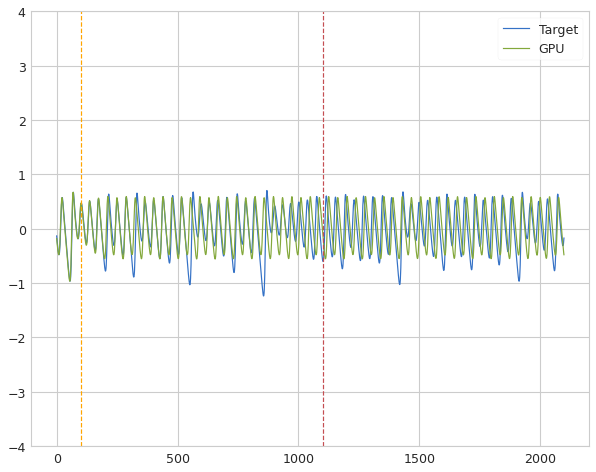

 Iter=16 a=0.580 sr=0.921 amp=1.630  ri=0.634 rr=0.776 loss=0.639599


Iter: 16 #### Diagnostic 0.639599   Time 5.92  Best 0.640 NRMSE 0.169 CD 0.471
Iter: 17 #### Diagnostic 1.540866   Time 5.11  Best 0.640 NRMSE 0.309 CD 1.232
Iter: 18 #### Diagnostic 1.037294   Time 5.92  Best 0.640 NRMSE 0.237 CD 0.800
Iter: 19 #### Diagnostic 1.214937   Time 5.01  Best 0.640 NRMSE 0.213 CD 1.002
Iter: 20 #### Diagnostic 1000.000000   Time 4.91  Best 0.640 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1.236695   Time 4.85  Best 0.640 NRMSE 0.249 CD 0.988
Iter: 22 #### Diagnostic 1.639175   Time 4.95  Best 0.640 NRMSE 0.760 CD 0.879
Iter: 23 #### Diagnostic 14.129174   Time 5.37  Best 0.640 NRMSE 13.128 CD 1.002
Iter: 24 #### Diagnostic 1.499455   Time 4.77  Best 0.640 NRMSE 0.610 CD 0.889
Iter: 25 #### Diagnostic 1000.000000   Time 4.83  Best 0.640 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 0.934127   Time 5.16  Best 0.640 NRMSE 0.212 CD 0.722
Iter: 27 #### Diagnostic 1.261687   Time 4.94  Bes

Iter: 7 #### Diagnostic 1000.000000   Time 5.27  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 5.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1.498043   Time 5.39  Best 1000.000 NRMSE 0.500 CD 0.998
Iter: 10 #### Diagnostic 1000.000000   Time 4.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 0.913958   Time 5.20  Best 1000.000 NRMSE 0.210 CD 0.704
Iter: 12 #### Diagnostic 1000.000000   Time 5.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1.010461   Time 5.26  Best 1000.000 NRMSE 0.200 CD 0.810
Iter: 14 #### Diagnostic 1000.000000   Time 5.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 5.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 5.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 4.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000000   Time 4.93  Best 1000.000 NRMSE

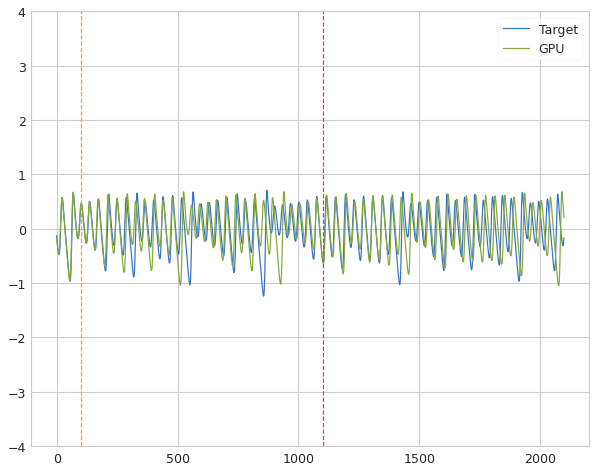

 Iter=50 a=0.670 sr=0.993 amp=1.530  ri=2.594 rr=1.976 loss=0.679718


Iter: 50 #### Diagnostic 0.679718   Time 5.55  Best 0.680 NRMSE 0.171 CD 0.509
Iter: 51 #### Diagnostic 1000.000000   Time 6.04  Best 0.680 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000000   Time 5.08  Best 0.680 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000000   Time 4.99  Best 0.680 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000000   Time 5.15  Best 0.680 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000000   Time 4.81  Best 0.680 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000000   Time 5.14  Best 0.680 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1.129830   Time 5.26  Best 0.680 NRMSE 0.236 CD 0.894
Iter: 58 #### Diagnostic 1000.000000   Time 5.08  Best 0.680 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 4.89  Best 0.680 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 5.34  Best 0.680 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic

Iter: 45 #### Diagnostic 1000.000000   Time 7.37  Best 1000.000 NRMSE 1000.000 CD 0.986
Iter: 46 #### Diagnostic 1000.000000   Time 7.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 0.845820   Time 7.73  Best 1000.000 NRMSE 0.208 CD 0.638
Iter: 48 #### Diagnostic 1.132694   Time 8.56  Best 1000.000 NRMSE 0.196 CD 0.937
Iter: 49 #### Diagnostic 1.513338   Time 8.04  Best 1000.000 NRMSE 0.519 CD 0.994
Iter: 50 #### Diagnostic 0.998547   Time 8.23  Best 1000.000 NRMSE 0.275 CD 0.724
Iter: 51 #### Diagnostic 1000.000000   Time 6.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1.190144   Time 7.98  Best 1000.000 NRMSE 0.234 CD 0.956
Iter: 53 #### Diagnostic 1.496654   Time 7.81  Best 1000.000 NRMSE 0.507 CD 0.990
Iter: 54 #### Diagnostic 1000.000000   Time 8.76  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000000   Time 9.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 0.845468   Time 5.96  Best 1000.000 NRMSE 0.180 CD 

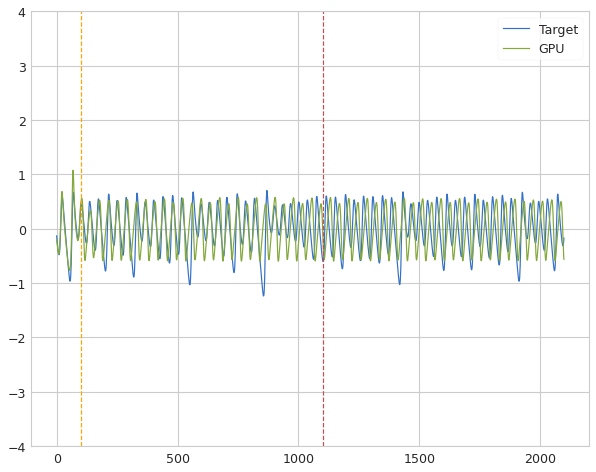

 Iter=28 a=0.662 sr=0.963 amp=1.654  ri=0.327 rr=1.231 loss=0.699774


Iter: 28 #### Diagnostic 0.699774   Time 9.23  Best 0.700 NRMSE 0.175 CD 0.525
Iter: 29 #### Diagnostic 0.757557   Time 7.52  Best 0.700 NRMSE 0.183 CD 0.574
Iter: 30 #### Diagnostic 1.498943   Time 7.85  Best 0.700 NRMSE 0.500 CD 0.999
Iter: 31 #### Diagnostic 1000.000000   Time 9.26  Best 0.700 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.501660   Time 6.41  Best 0.700 NRMSE 0.512 CD 0.990
Iter: 33 #### Diagnostic 0.850375   Time 5.85  Best 0.700 NRMSE 0.211 CD 0.640
Iter: 34 #### Diagnostic 1.479635   Time 7.72  Best 0.700 NRMSE 0.479 CD 1.001
Iter: 35 #### Diagnostic 1.202282   Time 8.13  Best 0.700 NRMSE 0.207 CD 0.996
Iter: 36 #### Diagnostic 1000.000000   Time 7.67  Best 0.700 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000000   Time 6.69  Best 0.700 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000000   Time 8.31  Best 0.700 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000000   Time 

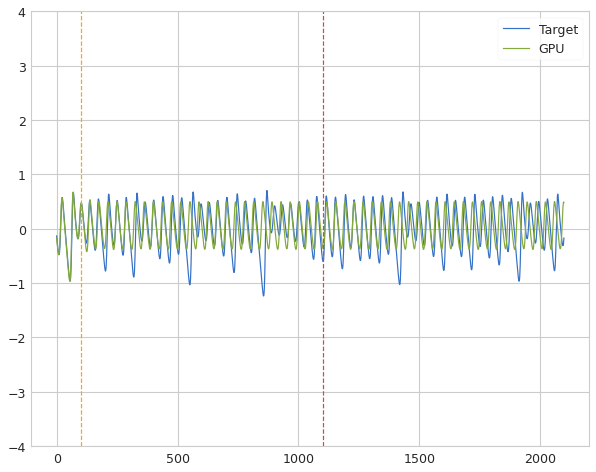

 Iter=90 a=0.575 sr=0.859 amp=1.591  ri=0.888 rr=3.170 loss=0.682113


Iter: 90 #### Diagnostic 0.682113   Time 8.19  Best 0.682 NRMSE 0.162 CD 0.520
Iter: 91 #### Diagnostic 1000.000000   Time 8.30  Best 0.682 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1.245768   Time 10.27  Best 0.682 NRMSE 0.247 CD 0.999
Iter: 93 #### Diagnostic 1000.000000   Time 8.62  Best 0.682 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 0.764847   Time 8.56  Best 0.682 NRMSE 0.190 CD 0.575
Iter: 95 #### Diagnostic 1.230681   Time 6.84  Best 0.682 NRMSE 0.239 CD 0.992
Iter: 96 #### Diagnostic 1000.000000   Time 9.66  Best 0.682 NRMSE 1000.000 CD nan


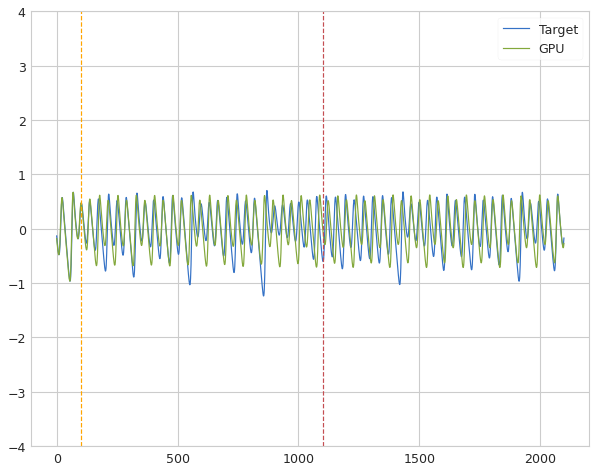

 Iter=97 a=0.618 sr=0.879 amp=1.497  ri=1.900 rr=3.468 loss=0.632880


Iter: 97 #### Diagnostic 0.632880   Time 8.79  Best 0.633 NRMSE 0.170 CD 0.463
Iter: 98 #### Diagnostic 1.521426   Time 8.04  Best 0.633 NRMSE 0.512 CD 1.009
Iter: 99 #### Diagnostic 1.292044   Time 6.98  Best 0.633 NRMSE 0.255 CD 1.037

Best result = 0.632879557723365
a = 0.6183895486255522
sr = 0.8793799328274652
amp = 1.4971502274612354
ri = 1.9003524169474342
rr = 3.4681659432347574
********** Size 30 -- Run 3 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 8.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000000   Time 5.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 8.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 6.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 9.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1.368755   Time 8.65  Best 1000.000 NRMSE 0.258 CD

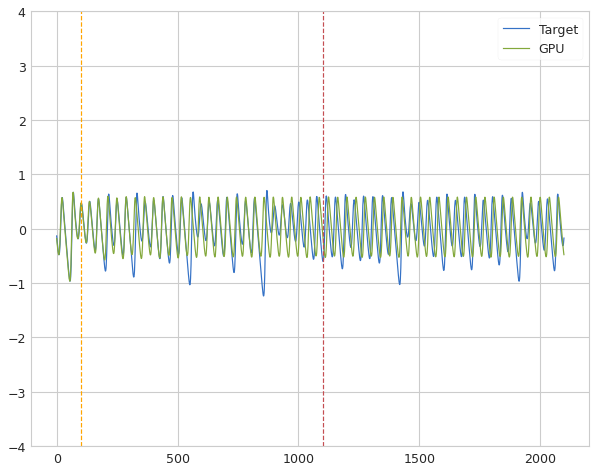

 Iter=27 a=0.601 sr=0.923 amp=1.649  ri=0.640 rr=1.130 loss=0.641480


Iter: 27 #### Diagnostic 0.641480   Time 8.08  Best 0.641 NRMSE 0.169 CD 0.472
Iter: 28 #### Diagnostic 1000.000000   Time 8.50  Best 0.641 NRMSE 1876.180 CD 1.000
Iter: 29 #### Diagnostic 1000.000000   Time 7.00  Best 0.641 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 8.10  Best 0.641 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1.103573   Time 7.42  Best 0.641 NRMSE 0.241 CD 0.862
Iter: 32 #### Diagnostic 1.222653   Time 7.86  Best 0.641 NRMSE 0.292 CD 0.930
Iter: 33 #### Diagnostic 1.472713   Time 6.46  Best 0.641 NRMSE 0.466 CD 1.006
Iter: 34 #### Diagnostic 1.302011   Time 6.73  Best 0.641 NRMSE 0.255 CD 1.047
Iter: 35 #### Diagnostic 1.204410   Time 6.39  Best 0.641 NRMSE 0.223 CD 0.981
Iter: 36 #### Diagnostic 0.970571   Time 9.48  Best 0.641 NRMSE 0.227 CD 0.743
Iter: 37 #### Diagnostic 4.173882   Time 8.50  Best 0.641 NRMSE 3.154 CD 1.020
Iter: 38 #### Diagnostic 1000.000000   Time 8.

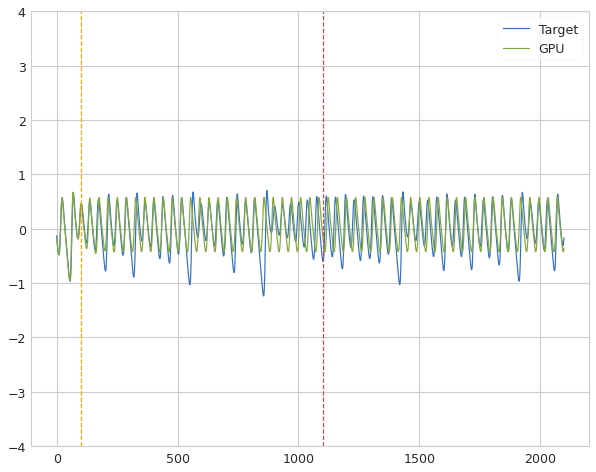

 Iter=54 a=0.557 sr=0.928 amp=1.656  ri=3.289 rr=1.747 loss=0.590806


Iter: 54 #### Diagnostic 0.590806   Time 9.40  Best 0.591 NRMSE 0.156 CD 0.435
Iter: 55 #### Diagnostic 1000.000000   Time 8.58  Best 0.591 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000000   Time 8.33  Best 0.591 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000000   Time 8.45  Best 0.591 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 0.737539   Time 8.18  Best 0.591 NRMSE 0.193 CD 0.544
Iter: 59 #### Diagnostic 1000.000000   Time 9.58  Best 0.591 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 9.26  Best 0.591 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 0.714793   Time 6.10  Best 0.591 NRMSE 0.185 CD 0.530
Iter: 62 #### Diagnostic 1000.000000   Time 7.71  Best 0.591 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000000   Time 8.69  Best 0.591 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000000   Time 8.32  Best 0.591 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 100

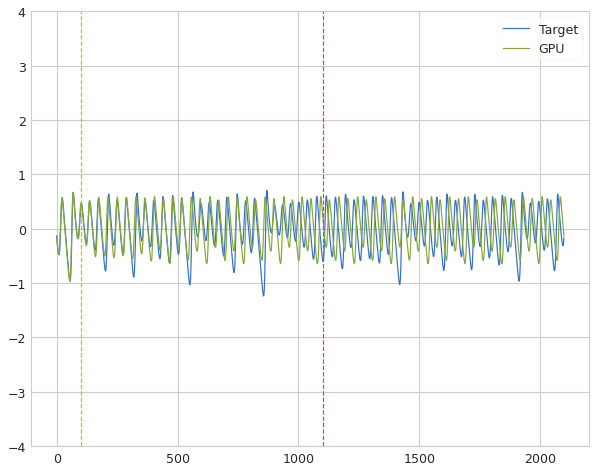

 Iter=43 a=0.686 sr=1.000 amp=1.695  ri=2.279 rr=2.783 loss=0.668244


Iter: 43 #### Diagnostic 0.668244   Time 8.99  Best 0.668 NRMSE 0.177 CD 0.492
Iter: 44 #### Diagnostic 1000.000000   Time 8.30  Best 0.668 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 18.910134   Time 8.68  Best 0.668 NRMSE 17.909 CD 1.001
Iter: 46 #### Diagnostic 1000.000000   Time 6.39  Best 0.668 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1.418148   Time 7.27  Best 0.668 NRMSE 0.311 CD 1.107


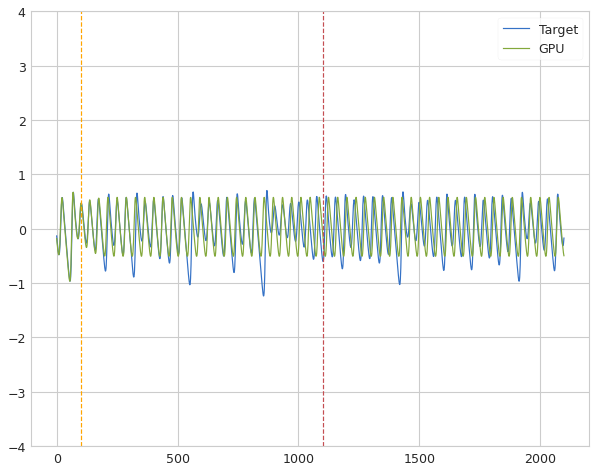

 Iter=48 a=0.655 sr=0.900 amp=1.582  ri=1.590 rr=0.427 loss=0.617255


Iter: 48 #### Diagnostic 0.617255   Time 9.05  Best 0.617 NRMSE 0.165 CD 0.452
Iter: 49 #### Diagnostic 1000.000000   Time 9.46  Best 0.617 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1.238853   Time 8.31  Best 0.617 NRMSE 0.299 CD 0.940
Iter: 51 #### Diagnostic 1000.000000   Time 8.39  Best 0.617 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000000   Time 6.43  Best 0.617 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000000   Time 7.54  Best 0.617 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 0.785397   Time 8.47  Best 0.617 NRMSE 0.197 CD 0.588
Iter: 55 #### Diagnostic 1000.000000   Time 7.01  Best 0.617 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1.022311   Time 8.65  Best 0.617 NRMSE 0.231 CD 0.792
Iter: 57 #### Diagnostic 1.265042   Time 7.66  Best 0.617 NRMSE 0.235 CD 1.030
Iter: 58 #### Diagnostic 1.398575   Time 6.67  Best 0.617 NRMSE 0.395 CD 1.004
Iter: 59 #### Diagnostic 1000.000000   T

Iter: 37 #### Diagnostic 1000.000000   Time 9.22  Best 1000.000 NRMSE 1000.000 CD 1.006


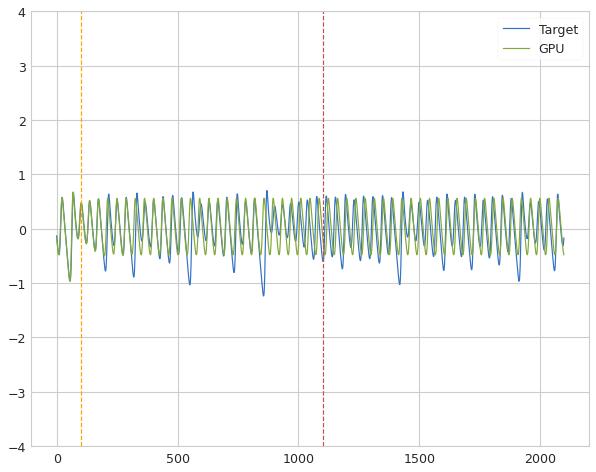

 Iter=38 a=0.641 sr=0.835 amp=1.676  ri=1.365 rr=0.812 loss=0.634366


Iter: 38 #### Diagnostic 0.634366   Time 8.98  Best 0.634 NRMSE 0.165 CD 0.469
Iter: 39 #### Diagnostic 1.019353   Time 9.81  Best 0.634 NRMSE 0.238 CD 0.781
Iter: 40 #### Diagnostic 1.510760   Time 8.01  Best 0.634 NRMSE 0.518 CD 0.993
Iter: 41 #### Diagnostic 1000.000000   Time 7.63  Best 0.634 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000000   Time 8.67  Best 0.634 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000000   Time 9.50  Best 0.634 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 40.815537   Time 6.67  Best 0.634 NRMSE 39.861 CD 0.955
Iter: 45 #### Diagnostic 1.320832   Time 7.14  Best 0.634 NRMSE 0.255 CD 1.066
Iter: 46 #### Diagnostic 1.500530   Time 8.95  Best 0.634 NRMSE 0.509 CD 0.992
Iter: 47 #### Diagnostic 1000.000000   Time 7.20  Best 0.634 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1.397518   Time 9.70  Best 0.634 NRMSE 0.247 CD 1.151
Iter: 49 #### Diagnostic 1000.000000   Tim

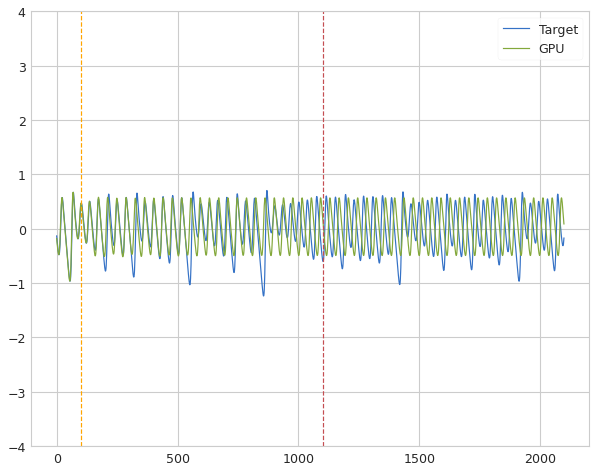

 Iter=25 a=0.657 sr=0.878 amp=1.561  ri=1.756 rr=0.076 loss=0.691253


Iter: 25 #### Diagnostic 0.691253   Time 7.49  Best 0.691 NRMSE 0.178 CD 0.513
Iter: 26 #### Diagnostic 1.500668   Time 6.94  Best 0.691 NRMSE 0.501 CD 1.000
Iter: 27 #### Diagnostic 1.114275   Time 8.03  Best 0.691 NRMSE 0.197 CD 0.917
Iter: 28 #### Diagnostic 1.252977   Time 7.65  Best 0.691 NRMSE 0.245 CD 1.008
Iter: 29 #### Diagnostic 1000.000000   Time 9.11  Best 0.691 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 9.34  Best 0.691 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 115.362159   Time 6.75  Best 0.691 NRMSE 114.422 CD 0.940
Iter: 32 #### Diagnostic 1000.000000   Time 9.33  Best 0.691 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1000.000000   Time 8.18  Best 0.691 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 0.733086   Time 5.08  Best 0.691 NRMSE 0.185 CD 0.548
Iter: 35 #### Diagnostic 1000.000000   Time 7.05  Best 0.691 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000000

Iter: 22 #### Diagnostic 1000.000000   Time 7.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 7.76  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1.086807   Time 6.91  Best 1000.000 NRMSE 0.224 CD 0.863
Iter: 25 #### Diagnostic 0.900069   Time 8.20  Best 1000.000 NRMSE 0.217 CD 0.683
Iter: 26 #### Diagnostic 2.220486   Time 6.08  Best 1000.000 NRMSE 1.258 CD 0.963
Iter: 27 #### Diagnostic 1.271716   Time 7.19  Best 1000.000 NRMSE 0.290 CD 0.981
Iter: 28 #### Diagnostic 1.123494   Time 9.05  Best 1000.000 NRMSE 0.237 CD 0.886
Iter: 29 #### Diagnostic 1.487407   Time 7.04  Best 1000.000 NRMSE 0.494 CD 0.994
Iter: 30 #### Diagnostic 1000.000000   Time 8.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000000   Time 6.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.485175   Time 6.07  Best 1000.000 NRMSE 0.289 CD 1.196
Iter: 33 #### Diagnostic 1.502358   Time 9.19  Best 1000.000 NRMSE 0.509 CD 0.993


Iter: 17 #### Diagnostic 1000.000000   Time 7.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000000   Time 7.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1.530395   Time 7.10  Best 1000.000 NRMSE 0.529 CD 1.002
Iter: 20 #### Diagnostic 1000.000000   Time 6.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 0.807476   Time 7.47  Best 1000.000 NRMSE 0.198 CD 0.609
Iter: 22 #### Diagnostic 1000.000000   Time 8.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 8.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 7.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1.223118   Time 6.38  Best 1000.000 NRMSE 0.370 CD 0.853
Iter: 26 #### Diagnostic 1.139691   Time 7.45  Best 1000.000 NRMSE 0.230 CD 0.910
Iter: 27 #### Diagnostic 1000.000000   Time 7.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1.187204   Time 8.92  Best 1000.000 NRMSE 0.2

Iter: 12 #### Diagnostic 1.319731   Time 8.60  Best 1000.000 NRMSE 0.255 CD 1.065
Iter: 13 #### Diagnostic 1000.000000   Time 8.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1.315077   Time 7.69  Best 1000.000 NRMSE 0.274 CD 1.041
Iter: 15 #### Diagnostic 1000.000000   Time 7.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 7.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1.408118   Time 8.05  Best 1000.000 NRMSE 0.250 CD 1.158
Iter: 18 #### Diagnostic 1000.000000   Time 7.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1.160357   Time 8.44  Best 1000.000 NRMSE 0.212 CD 0.948
Iter: 20 #### Diagnostic 1.378568   Time 7.31  Best 1000.000 NRMSE 0.403 CD 0.976
Iter: 21 #### Diagnostic 1000.000000   Time 5.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1.287412   Time 8.23  Best 1000.000 NRMSE 0.191 CD 1.096
Iter: 23 #### Diagnostic 1000.000000   Time 7.31  Best 1000.000 NRMSE 25847.47

Iter: 0 #### Diagnostic 1000.000000   Time 7.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000000   Time 5.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1.095025   Time 10.52  Best 1000.000 NRMSE 0.241 CD 0.854
Iter: 3 #### Diagnostic 0.797829   Time 6.71  Best 1000.000 NRMSE 0.201 CD 0.597
Iter: 4 #### Diagnostic 1000.000000   Time 8.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 7.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 7.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 7.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 7.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 0.751201   Time 9.58  Best 1000.000 NRMSE 0.195 CD 0.556
Iter: 10 #### Diagnostic 1000.000000   Time 8.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000000   Time 9.39  Best 1000.000 NRMSE 10267

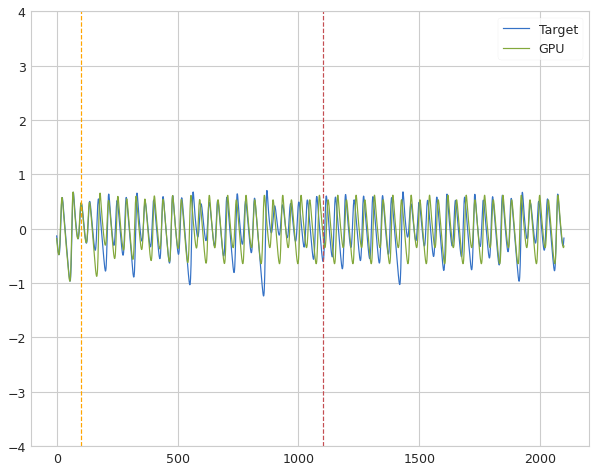

 Iter=34 a=0.681 sr=0.959 amp=1.594  ri=1.957 rr=0.997 loss=0.638338


Iter: 34 #### Diagnostic 0.638338   Time 9.47  Best 0.638 NRMSE 0.170 CD 0.469
Iter: 35 #### Diagnostic 1.511998   Time 7.97  Best 0.638 NRMSE 0.284 CD 1.228
Iter: 36 #### Diagnostic 1000.000000   Time 8.88  Best 0.638 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000000   Time 7.06  Best 0.638 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000000   Time 8.01  Best 0.638 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000000   Time 8.84  Best 0.638 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1.675667   Time 8.77  Best 0.638 NRMSE 0.669 CD 1.007
Iter: 41 #### Diagnostic 1000.000000   Time 9.50  Best 0.638 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000000   Time 6.54  Best 0.638 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1.134437   Time 9.20  Best 0.638 NRMSE 0.220 CD 0.915
Iter: 44 #### Diagnostic 1000.000000   Time 7.02  Best 0.638 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1.25597

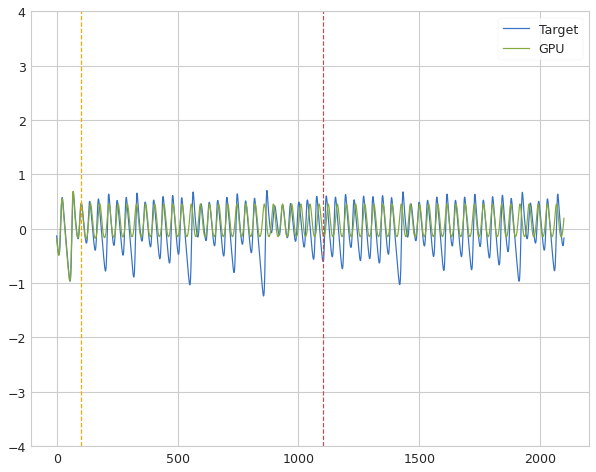

 Iter=73 a=0.610 sr=0.848 amp=1.661  ri=3.755 rr=0.289 loss=0.630306


Iter: 73 #### Diagnostic 0.630306   Time 6.57  Best 0.630 NRMSE 0.145 CD 0.485
Iter: 74 #### Diagnostic 1000.000000   Time 7.36  Best 0.630 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000000   Time 7.71  Best 0.630 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1.256834   Time 7.11  Best 0.630 NRMSE 0.351 CD 0.906
Iter: 77 #### Diagnostic 1000.000000   Time 6.65  Best 0.630 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1000.000000   Time 8.59  Best 0.630 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000000   Time 7.49  Best 0.630 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000000   Time 7.69  Best 0.630 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000000   Time 5.90  Best 0.630 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 0.946750   Time 7.75  Best 0.630 NRMSE 0.213 CD 0.734
Iter: 83 #### Diagnostic 1.224843   Time 8.28  Best 0.630 NRMSE 0.220 CD 1.005
Iter: 84 #### Diagnostic 1.03701

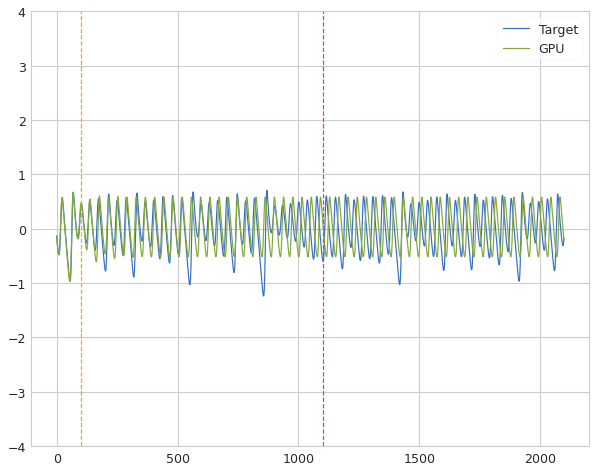

 Iter=0 a=0.571 sr=0.905 amp=1.627  ri=1.239 rr=3.433 loss=0.688452


Iter: 0 #### Diagnostic 0.688452   Time 9.69  Best 0.688 NRMSE 0.182 CD 0.507
Iter: 1 #### Diagnostic 1000.000000   Time 6.52  Best 0.688 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1.531422   Time 7.96  Best 0.688 NRMSE 0.530 CD 1.002
Iter: 3 #### Diagnostic 1000.000000   Time 9.09  Best 0.688 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 7.65  Best 0.688 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1.234054   Time 7.13  Best 0.688 NRMSE 0.252 CD 0.983
Iter: 6 #### Diagnostic 0.798905   Time 6.99  Best 0.688 NRMSE 0.194 CD 0.605
Iter: 7 #### Diagnostic 1.096322   Time 6.89  Best 0.688 NRMSE 0.288 CD 0.808
Iter: 8 #### Diagnostic 1000.000000   Time 9.48  Best 0.688 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 0.897197   Time 9.08  Best 0.688 NRMSE 0.214 CD 0.683
Iter: 10 #### Diagnostic 1000.000000   Time 8.44  Best 0.688 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000000   Time 8.37  B

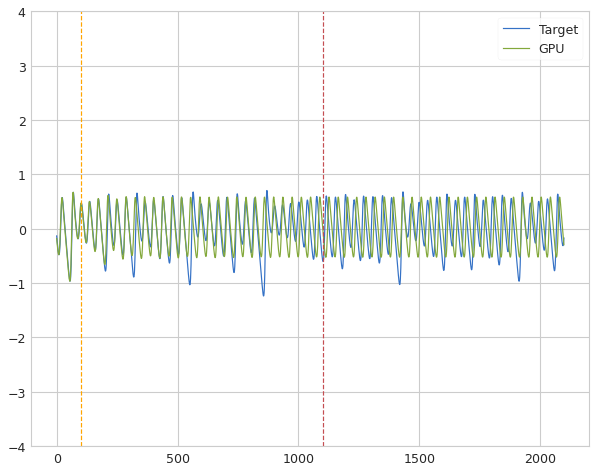

 Iter=68 a=0.570 sr=0.869 amp=1.508  ri=1.245 rr=2.310 loss=0.648515


Iter: 68 #### Diagnostic 0.648515   Time 8.32  Best 0.649 NRMSE 0.172 CD 0.477
Iter: 69 #### Diagnostic 1.175984   Time 8.65  Best 0.649 NRMSE 0.200 CD 0.976
Iter: 70 #### Diagnostic 98.343285   Time 6.89  Best 0.649 NRMSE 97.362 CD 0.981
Iter: 71 #### Diagnostic 2.414495   Time 9.40  Best 0.649 NRMSE 1.619 CD 0.795
Iter: 72 #### Diagnostic 53.887501   Time 5.62  Best 0.649 NRMSE 52.887 CD 1.001
Iter: 73 #### Diagnostic 1000.000000   Time 6.02  Best 0.649 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000000   Time 7.43  Best 0.649 NRMSE 3198.938 CD 1.009
Iter: 75 #### Diagnostic 1000.000000   Time 6.47  Best 0.649 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1.176051   Time 8.43  Best 0.649 NRMSE 0.222 CD 0.954
Iter: 77 #### Diagnostic 1.315935   Time 6.99  Best 0.649 NRMSE 0.262 CD 1.054
Iter: 78 #### Diagnostic 1.375110   Time 5.39  Best 0.649 NRMSE 0.265 CD 1.110
Iter: 79 #### Diagnostic 1000.000000   Tim

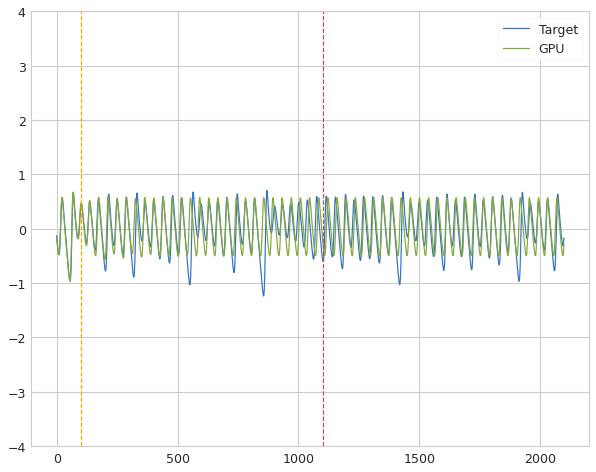

 Iter=23 a=0.568 sr=0.808 amp=1.700  ri=1.073 rr=1.030 loss=0.592412


Iter: 23 #### Diagnostic 0.592412   Time 9.66  Best 0.592 NRMSE 0.159 CD 0.434
Iter: 24 #### Diagnostic 1000.000000   Time 7.13  Best 0.592 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1.525226   Time 7.43  Best 0.592 NRMSE 0.528 CD 0.997
Iter: 26 #### Diagnostic 1000.000000   Time 7.07  Best 0.592 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 8.49  Best 0.592 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 7.37  Best 0.592 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 8.16  Best 0.592 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 6.63  Best 0.592 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000000   Time 7.31  Best 0.592 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.528037   Time 7.77  Best 0.592 NRMSE 0.529 CD 0.999
Iter: 33 #### Diagnostic 1.512775   Time 6.65  Best 0.592 NRMSE 0.519 CD 0.994
Iter: 34 #### Diagnostic 0.82586

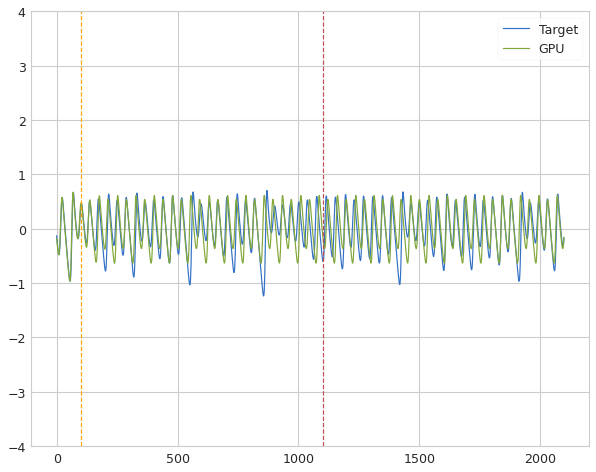

 Iter=3 a=0.591 sr=0.897 amp=1.561  ri=3.824 rr=1.820 loss=0.599656


Iter: 3 #### Diagnostic 0.599656   Time 8.02  Best 0.600 NRMSE 0.164 CD 0.436
Iter: 4 #### Diagnostic 1.066616   Time 6.35  Best 0.600 NRMSE 0.197 CD 0.870
Iter: 5 #### Diagnostic 1.481413   Time 7.62  Best 0.600 NRMSE 0.476 CD 1.005
Iter: 6 #### Diagnostic 1000.000000   Time 8.29  Best 0.600 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1.219063   Time 6.91  Best 0.600 NRMSE 0.364 CD 0.855
Iter: 8 #### Diagnostic 1000.000000   Time 8.15  Best 0.600 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1.608464   Time 8.70  Best 0.600 NRMSE 0.293 CD 1.315
Iter: 10 #### Diagnostic 0.880098   Time 7.37  Best 0.600 NRMSE 0.210 CD 0.670
Iter: 11 #### Diagnostic 1000.000000   Time 7.63  Best 0.600 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 7.63  Best 0.600 NRMSE 1000.000 CD 0.996
Iter: 13 #### Diagnostic 0.611811   Time 7.04  Best 0.600 NRMSE 0.163 CD 0.449
Iter: 14 #### Diagnostic 1000.000000   Time 8.35  

Iter: 2 #### Diagnostic 1.243391   Time 7.67  Best 1000.000 NRMSE 0.239 CD 1.005
Iter: 3 #### Diagnostic 1.522547   Time 7.24  Best 1000.000 NRMSE 0.525 CD 0.998
Iter: 4 #### Diagnostic 1000.000000   Time 7.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 7.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 7.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 8.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 6.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 0.747254   Time 9.38  Best 1000.000 NRMSE 0.194 CD 0.553
Iter: 10 #### Diagnostic 1.172364   Time 8.50  Best 1000.000 NRMSE 0.195 CD 0.977
Iter: 11 #### Diagnostic 1000.000000   Time 8.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1.063377   Time 8.81  Best 1000.000 NRMSE 0.238 CD 0.826
Iter: 13 #### Diagnostic 1.190127   Time 9.46  Best 1000.000 NRMSE 0.200 CD 0.990


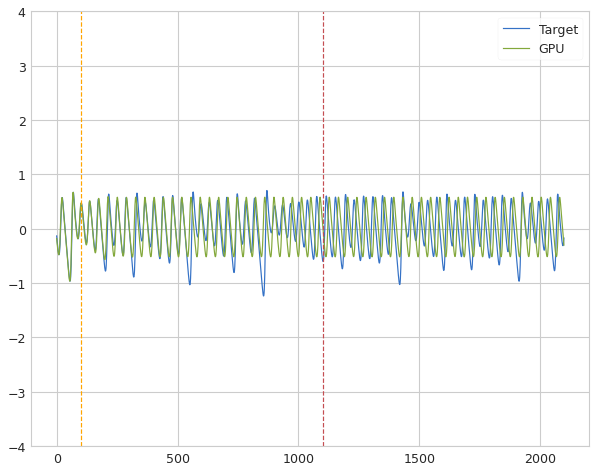

 Iter=71 a=0.683 sr=0.932 amp=1.608  ri=0.735 rr=0.367 loss=0.633726


Iter: 71 #### Diagnostic 0.633726   Time 9.44  Best 0.634 NRMSE 0.170 CD 0.463
Iter: 72 #### Diagnostic 1.186374   Time 6.95  Best 0.634 NRMSE 0.200 CD 0.987
Iter: 73 #### Diagnostic 1.159867   Time 7.17  Best 0.634 NRMSE 0.198 CD 0.962
Iter: 74 #### Diagnostic 1000.000000   Time 8.79  Best 0.634 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000000   Time 7.98  Best 0.634 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000000   Time 7.34  Best 0.634 NRMSE 50277395550024318976.000 CD 0.996
Iter: 77 #### Diagnostic 1000.000000   Time 8.83  Best 0.634 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 0.697297   Time 6.35  Best 0.634 NRMSE 0.180 CD 0.517
Iter: 79 #### Diagnostic 1.487985   Time 8.88  Best 0.634 NRMSE 0.498 CD 0.990
Iter: 80 #### Diagnostic 0.995978   Time 6.77  Best 0.634 NRMSE 0.194 CD 0.802
Iter: 81 #### Diagnostic 1000.000000   Time 7.21  Best 0.634 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnost

Iter: 59 #### Diagnostic 1.079306   Time 5.79  Best 1000.000 NRMSE 0.205 CD 0.875
Iter: 60 #### Diagnostic 1000.000000   Time 8.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1.457820   Time 8.63  Best 1000.000 NRMSE 0.389 CD 1.069
Iter: 62 #### Diagnostic 1000.000000   Time 6.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1.503810   Time 7.17  Best 1000.000 NRMSE 0.281 CD 1.223
Iter: 64 #### Diagnostic 1000.000000   Time 8.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000000   Time 8.76  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000000   Time 6.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 6.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 7.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000000   Time 7.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 8.678412   Time 8.05  Best 1000.000 NRMSE

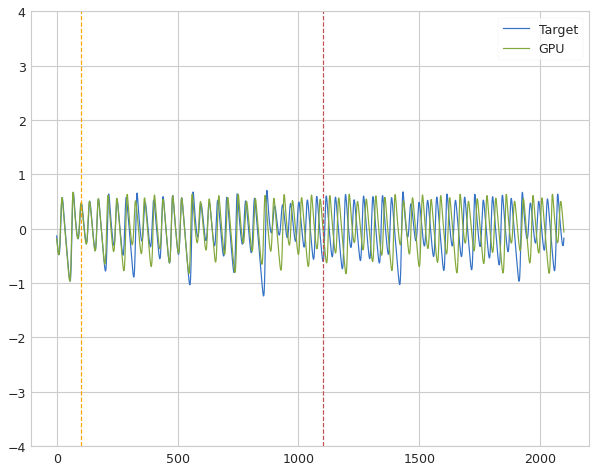

 Iter=0 a=0.571 sr=0.905 amp=1.627  ri=1.239 rr=3.433 loss=0.605160


Iter: 0 #### Diagnostic 0.605160   Time 9.06  Best 0.605 NRMSE 0.170 CD 0.435
Iter: 1 #### Diagnostic 0.779517   Time 8.86  Best 0.605 NRMSE 0.199 CD 0.581
Iter: 2 #### Diagnostic 1.159464   Time 7.11  Best 0.605 NRMSE 0.192 CD 0.967
Iter: 3 #### Diagnostic 1.567467   Time 8.02  Best 0.605 NRMSE 0.287 CD 1.281
Iter: 4 #### Diagnostic 1000.000000   Time 7.30  Best 0.605 NRMSE 7257045519815722139648.000 CD 1.001
Iter: 5 #### Diagnostic 1000.000000   Time 6.72  Best 0.605 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 5.35  Best 0.605 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1.339683   Time 8.62  Best 0.605 NRMSE 0.331 CD 1.008
Iter: 8 #### Diagnostic 1000.000000   Time 7.89  Best 0.605 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1.486315   Time 7.16  Best 0.605 NRMSE 0.491 CD 0.996
Iter: 10 #### Diagnostic 1000.000000   Time 6.02  Best 0.605 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.0


Best result = 0.6051596033486952
a = 0.570883906778803
sr = 0.9048171150576995
amp = 1.6268971746755276
ri = 1.239379381393766
rr = 3.432856721179276
********** Size 30 -- Run 2 ***********
Iter: 0 #### Diagnostic 1.530640   Time 9.95  Best 1000.000 NRMSE 0.281 CD 1.250
Iter: 1 #### Diagnostic 1000.000000   Time 8.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 7.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1.243265   Time 9.26  Best 1000.000 NRMSE 0.227 CD 1.017
Iter: 4 #### Diagnostic 1000.000000   Time 7.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 8.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 6.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 6.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 6.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1.144111   Time 6.66  Best 1

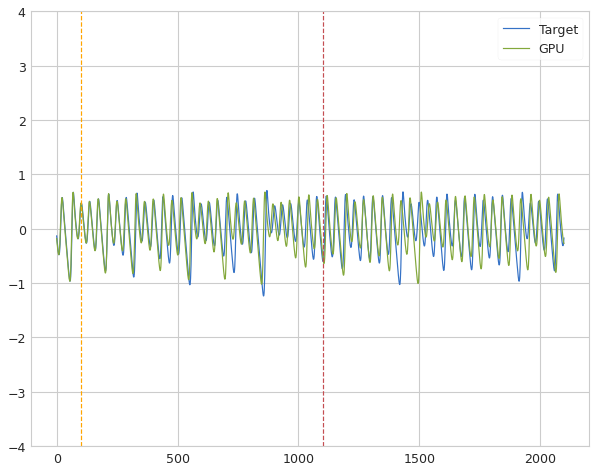

 Iter=63 a=0.644 sr=0.882 amp=1.449  ri=1.456 rr=1.029 loss=0.399159


Iter: 63 #### Diagnostic 0.399159   Time 6.97  Best 0.399 NRMSE 0.133 CD 0.266
Iter: 64 #### Diagnostic 1.134396   Time 7.72  Best 0.399 NRMSE 0.188 CD 0.946
Iter: 65 #### Diagnostic 1.161208   Time 5.83  Best 0.399 NRMSE 0.226 CD 0.935
Iter: 66 #### Diagnostic 1000.000000   Time 8.67  Best 0.399 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1.346854   Time 7.56  Best 0.399 NRMSE 0.244 CD 1.103
Iter: 68 #### Diagnostic 1.079274   Time 8.02  Best 0.399 NRMSE 0.222 CD 0.857
Iter: 69 #### Diagnostic 1000.000000   Time 6.07  Best 0.399 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 2.339854   Time 8.59  Best 0.399 NRMSE 1.250 CD 1.090
Iter: 71 #### Diagnostic 1000.000000   Time 7.70  Best 0.399 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1.436778   Time 8.29  Best 0.399 NRMSE 0.455 CD 0.982
Iter: 73 #### Diagnostic 1000.000000   Time 8.12  Best 0.399 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000000   Time 

Iter: 59 #### Diagnostic 1000.000000   Time 7.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 0.735822   Time 8.08  Best 1000.000 NRMSE 0.188 CD 0.548
Iter: 61 #### Diagnostic 1000.000000   Time 7.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 7.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 0.773506   Time 5.61  Best 1000.000 NRMSE 0.199 CD 0.575
Iter: 64 #### Diagnostic 1.168751   Time 7.02  Best 1000.000 NRMSE 0.211 CD 0.958
Iter: 65 #### Diagnostic 1.514691   Time 7.85  Best 1000.000 NRMSE 0.522 CD 0.993
Iter: 66 #### Diagnostic 1.099700   Time 6.51  Best 1000.000 NRMSE 0.267 CD 0.832
Iter: 67 #### Diagnostic 1000.000000   Time 7.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 9.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1.256998   Time 7.52  Best 1000.000 NRMSE 0.330 CD 0.927
Iter: 70 #### Diagnostic 1000.000000   Time 9.33  Best 1000.000 NRMSE 1000.000

Iter: 54 #### Diagnostic 1000.000000   Time 6.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1.353583   Time 7.53  Best 1000.000 NRMSE 0.263 CD 1.091
Iter: 56 #### Diagnostic 1.125391   Time 7.68  Best 1000.000 NRMSE 0.202 CD 0.924
Iter: 57 #### Diagnostic 1000.000000   Time 5.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 7.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 7.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 8.06  Best 1000.000 NRMSE 60140.128 CD 1.013
Iter: 61 #### Diagnostic 1.026479   Time 7.12  Best 1000.000 NRMSE 0.218 CD 0.809
Iter: 62 #### Diagnostic 1000.000000   Time 7.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1.258924   Time 7.60  Best 1000.000 NRMSE 0.313 CD 0.946
Iter: 64 #### Diagnostic 1000.000000   Time 7.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1.132689   Time 8.90  Best 1000.000 NRMSE 

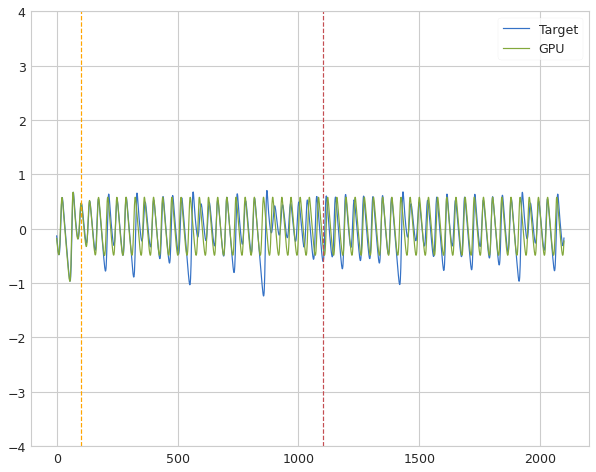

 Iter=66 a=0.652 sr=0.936 amp=1.554  ri=2.083 rr=0.462 loss=0.649060


Iter: 66 #### Diagnostic 0.649060   Time 8.15  Best 0.649 NRMSE 0.169 CD 0.480
Iter: 67 #### Diagnostic 1.513107   Time 8.24  Best 0.649 NRMSE 0.523 CD 0.990
Iter: 68 #### Diagnostic 1.251835   Time 8.36  Best 0.649 NRMSE 0.235 CD 1.017
Iter: 69 #### Diagnostic 0.892501   Time 7.55  Best 0.649 NRMSE 0.204 CD 0.688
Iter: 70 #### Diagnostic 1000.000000   Time 6.09  Best 0.649 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 0.804277   Time 7.20  Best 0.649 NRMSE 0.204 CD 0.600
Iter: 72 #### Diagnostic 1.186772   Time 7.13  Best 0.649 NRMSE 0.226 CD 0.961


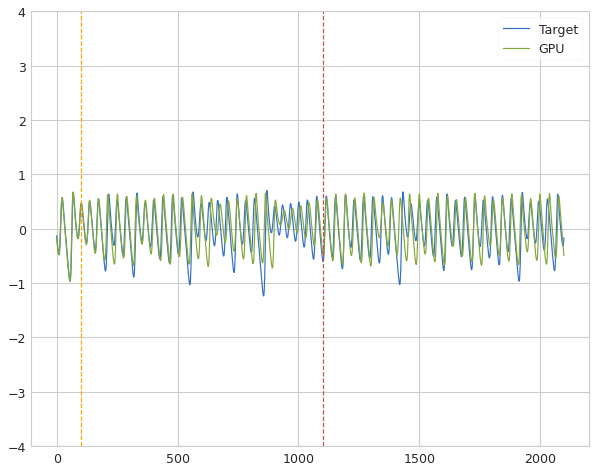

 Iter=73 a=0.648 sr=0.989 amp=1.423  ri=2.093 rr=2.583 loss=0.477925


Iter: 73 #### Diagnostic 0.477925   Time 7.19  Best 0.478 NRMSE 0.146 CD 0.332
Iter: 74 #### Diagnostic 1.109448   Time 7.19  Best 0.478 NRMSE 0.224 CD 0.885
Iter: 75 #### Diagnostic 1000.000000   Time 8.80  Best 0.478 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1.214540   Time 7.33  Best 0.478 NRMSE 0.238 CD 0.976
Iter: 77 #### Diagnostic 1000.000000   Time 8.06  Best 0.478 NRMSE 24047.376 CD 1.011
Iter: 78 #### Diagnostic 362.085257   Time 7.36  Best 0.478 NRMSE 361.097 CD 0.988
Iter: 79 #### Diagnostic 1.292842   Time 6.64  Best 0.478 NRMSE 0.229 CD 1.064
Iter: 80 #### Diagnostic 1000.000000   Time 8.66  Best 0.478 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 0.770006   Time 7.79  Best 0.478 NRMSE 0.185 CD 0.585
Iter: 82 #### Diagnostic 1000.000000   Time 7.59  Best 0.478 NRMSE 13713.719 CD 1.061
Iter: 83 #### Diagnostic 1000.000000   Time 7.03  Best 0.478 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1000.

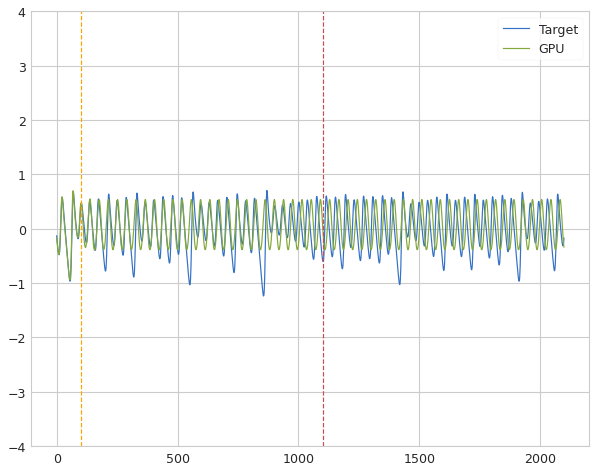

 Iter=55 a=0.696 sr=0.972 amp=1.418  ri=2.395 rr=2.473 loss=0.642015


Iter: 55 #### Diagnostic 0.642015   Time 8.19  Best 0.642 NRMSE 0.163 CD 0.479
Iter: 56 #### Diagnostic 1.174064   Time 6.61  Best 0.642 NRMSE 0.219 CD 0.955
Iter: 57 #### Diagnostic 1.173397   Time 6.75  Best 0.642 NRMSE 0.195 CD 0.978
Iter: 58 #### Diagnostic 1.307466   Time 7.86  Best 0.642 NRMSE 0.232 CD 1.076
Iter: 59 #### Diagnostic 1000.000000   Time 7.35  Best 0.642 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1.972120   Time 8.21  Best 0.642 NRMSE 0.958 CD 1.014
Iter: 61 #### Diagnostic 1.157042   Time 7.20  Best 0.642 NRMSE 0.252 CD 0.905
Iter: 62 #### Diagnostic 1000.000000   Time 8.11  Best 0.642 NRMSE 476328.292 CD 1.000
Iter: 63 #### Diagnostic 1.716057   Time 7.82  Best 0.642 NRMSE 0.729 CD 0.987
Iter: 64 #### Diagnostic 110.439798   Time 6.75  Best 0.642 NRMSE 109.472 CD 0.967
Iter: 65 #### Diagnostic 1000.000000   Time 8.35  Best 0.642 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1.525754   Time

Iter: 52 #### Diagnostic 1000.000000   Time 6.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1.103693   Time 7.02  Best 1000.000 NRMSE 0.256 CD 0.847
Iter: 54 #### Diagnostic 1000.000000   Time 8.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 0.905990   Time 6.15  Best 1000.000 NRMSE 0.173 CD 0.733
Iter: 56 #### Diagnostic 1.165606   Time 7.36  Best 1000.000 NRMSE 0.190 CD 0.975
Iter: 57 #### Diagnostic 1000.000000   Time 7.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 6.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 8.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 8.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1.211240   Time 8.22  Best 1000.000 NRMSE 0.243 CD 0.969
Iter: 62 #### Diagnostic 1.328448   Time 7.98  Best 1000.000 NRMSE 0.391 CD 0.938
Iter: 63 #### Diagnostic 0.867173   Time 7.73  Best 1000.000 NRMSE 0.227 C

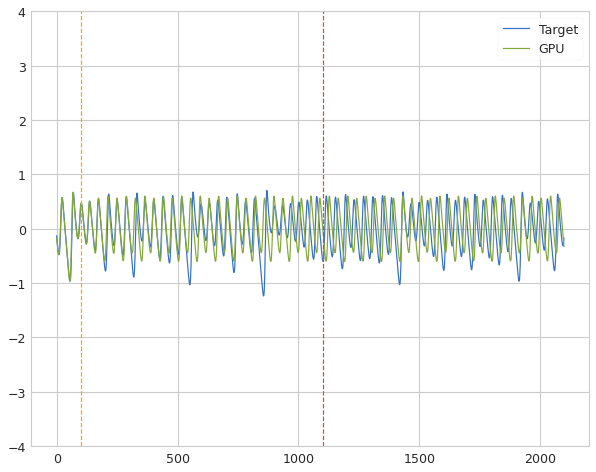

 Iter=83 a=0.598 sr=0.874 amp=1.501  ri=0.480 rr=2.989 loss=0.666382


Iter: 83 #### Diagnostic 0.666382   Time 7.84  Best 0.666 NRMSE 0.174 CD 0.493
Iter: 84 #### Diagnostic 1.249071   Time 9.11  Best 0.666 NRMSE 0.267 CD 0.982
Iter: 85 #### Diagnostic 0.872374   Time 7.25  Best 0.666 NRMSE 0.216 CD 0.656
Iter: 86 #### Diagnostic 1.523586   Time 6.02  Best 0.666 NRMSE 0.529 CD 0.995
Iter: 87 #### Diagnostic 0.796748   Time 7.65  Best 0.666 NRMSE 0.191 CD 0.605
Iter: 88 #### Diagnostic 0.878814   Time 6.55  Best 0.666 NRMSE 0.203 CD 0.676
Iter: 89 #### Diagnostic 1000.000000   Time 7.12  Best 0.666 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1.121040   Time 6.72  Best 0.666 NRMSE 0.200 CD 0.921
Iter: 91 #### Diagnostic 1.298291   Time 7.32  Best 0.666 NRMSE 0.262 CD 1.036


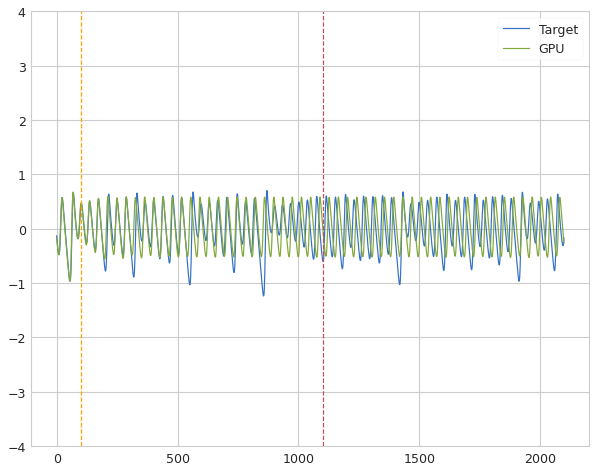

 Iter=92 a=0.596 sr=0.868 amp=1.430  ri=0.298 rr=0.364 loss=0.649829


Iter: 92 #### Diagnostic 0.649829   Time 6.99  Best 0.650 NRMSE 0.172 CD 0.478
Iter: 93 #### Diagnostic 1.267883   Time 7.61  Best 0.650 NRMSE 0.330 CD 0.938
Iter: 94 #### Diagnostic 1000.000000   Time 8.43  Best 0.650 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1.091578   Time 8.60  Best 0.650 NRMSE 0.244 CD 0.848
Iter: 96 #### Diagnostic 1.191821   Time 5.93  Best 0.650 NRMSE 0.190 CD 1.001
Iter: 97 #### Diagnostic 1000.000000   Time 8.67  Best 0.650 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1000.000000   Time 7.23  Best 0.650 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1000.000000   Time 7.13  Best 0.650 NRMSE 1000.000 CD nan

Best result = 0.649829109397657
a = 0.5958661672587962
sr = 0.8682858028887881
amp = 1.4303678447587815
ri = 0.29777521654005557
rr = 0.3639073868389336
********** Size 20 -- Run 2 ***********
Iter: 0 #### Diagnostic 1.390698   Time 7.38  Best 1000.000 NRMSE 0.347 CD 1.043
Iter: 

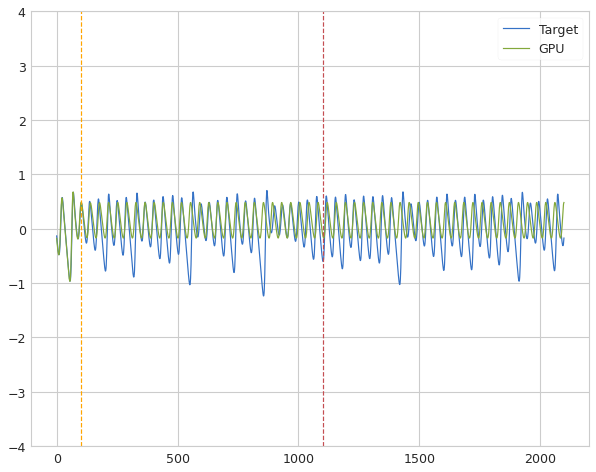

 Iter=46 a=0.667 sr=0.959 amp=1.590  ri=3.043 rr=2.553 loss=0.649132


Iter: 46 #### Diagnostic 0.649132   Time 8.10  Best 0.649 NRMSE 0.148 CD 0.501
Iter: 47 #### Diagnostic 1000.000000   Time 7.54  Best 0.649 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 5.89  Best 0.649 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1.377139   Time 6.63  Best 0.649 NRMSE 0.256 CD 1.121
Iter: 50 #### Diagnostic 1.177045   Time 7.43  Best 0.649 NRMSE 0.229 CD 0.948
Iter: 51 #### Diagnostic 1.360645   Time 5.94  Best 0.649 NRMSE 0.250 CD 1.111
Iter: 52 #### Diagnostic 1.312699   Time 6.55  Best 0.649 NRMSE 0.260 CD 1.053
Iter: 53 #### Diagnostic 1000.000000   Time 7.99  Best 0.649 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 4.056751   Time 8.25  Best 0.649 NRMSE 3.060 CD 0.996
Iter: 55 #### Diagnostic 1.092065   Time 7.77  Best 0.649 NRMSE 0.226 CD 0.866
Iter: 56 #### Diagnostic 1.371392   Time 8.28  Best 0.649 NRMSE 0.256 CD 1.115
Iter: 57 #### Diagnostic 1000.000000   Time 6.82

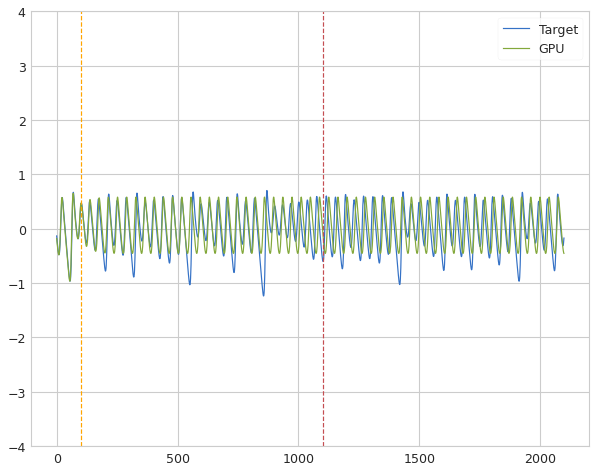

 Iter=14 a=0.602 sr=0.998 amp=1.624  ri=3.501 rr=3.726 loss=0.603657


Iter: 14 #### Diagnostic 0.603657   Time 9.17  Best 0.604 NRMSE 0.163 CD 0.441
Iter: 15 #### Diagnostic 1.417512   Time 6.33  Best 0.604 NRMSE 0.270 CD 1.148
Iter: 16 #### Diagnostic 1000.000000   Time 5.79  Best 0.604 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 5.85  Best 0.604 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000000   Time 7.56  Best 0.604 NRMSE 6021.191 CD 1.004
Iter: 19 #### Diagnostic 1000.000000   Time 6.27  Best 0.604 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1.137550   Time 7.07  Best 0.604 NRMSE 0.188 CD 0.950
Iter: 21 #### Diagnostic 1000.000000   Time 7.74  Best 0.604 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 0.916399   Time 7.99  Best 0.604 NRMSE 0.225 CD 0.691
Iter: 23 #### Diagnostic 1000.000000   Time 6.75  Best 0.604 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1.405182   Time 6.21  Best 0.604 NRMSE 0.325 CD 1.080
Iter: 25 #### Diagnostic 1000.0000

Iter: 12 #### Diagnostic 1.186190   Time 7.18  Best 1000.000 NRMSE 0.200 CD 0.987
Iter: 13 #### Diagnostic 1000.000000   Time 6.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1.171265   Time 7.86  Best 1000.000 NRMSE 0.239 CD 0.933
Iter: 15 #### Diagnostic 1000.000000   Time 7.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 5.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1.162679   Time 6.94  Best 1000.000 NRMSE 0.193 CD 0.969
Iter: 18 #### Diagnostic 1000.000000   Time 7.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 3.927331   Time 6.96  Best 1000.000 NRMSE 2.928 CD 1.000
Iter: 20 #### Diagnostic 1.169370   Time 5.71  Best 1000.000 NRMSE 0.238 CD 0.932
Iter: 21 #### Diagnostic 1000.000000   Time 8.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1.156717   Time 6.27  Best 1000.000 NRMSE 0.188 CD 0.969
Iter: 23 #### Diagnostic 6.282846   Time 7.27  Best 1000.000 NRMSE 5.283 CD 0.

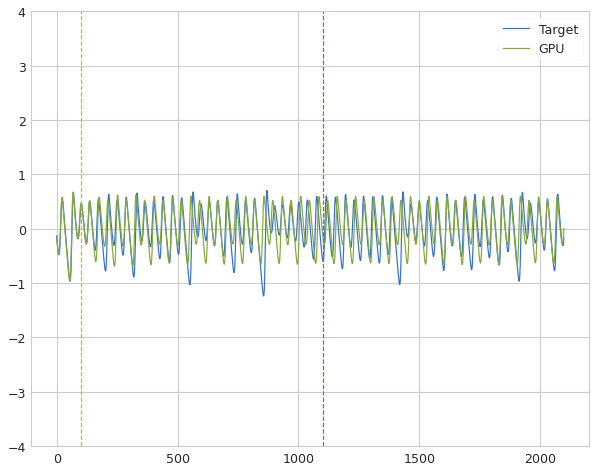

 Iter=86 a=0.555 sr=0.977 amp=1.582  ri=0.350 rr=1.158 loss=0.599852


Iter: 86 #### Diagnostic 0.599852   Time 7.24  Best 0.600 NRMSE 0.161 CD 0.439
Iter: 87 #### Diagnostic 1.196048   Time 7.30  Best 0.600 NRMSE 0.190 CD 1.006
Iter: 88 #### Diagnostic 1.144721   Time 7.25  Best 0.600 NRMSE 0.250 CD 0.894
Iter: 89 #### Diagnostic 1000.000000   Time 7.38  Best 0.600 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1000.000000   Time 7.90  Best 0.600 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000000   Time 7.35  Best 0.600 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000000   Time 4.98  Best 0.600 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000000   Time 6.92  Best 0.600 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1000.000000   Time 8.02  Best 0.600 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1000.000000   Time 5.95  Best 0.600 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000000   Time 5.66  Best 0.600 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 0.8

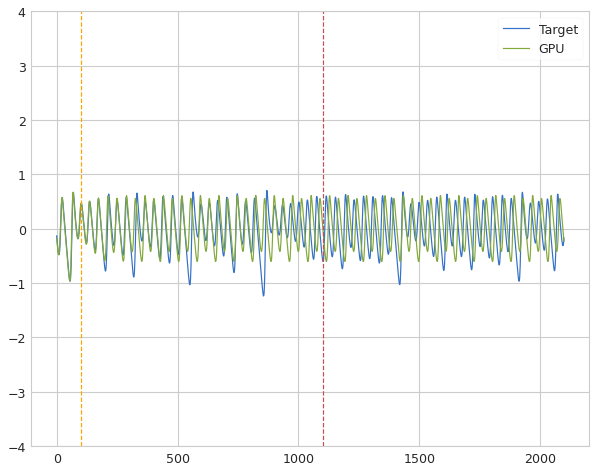

 Iter=11 a=0.699 sr=0.864 amp=1.637  ri=0.860 rr=3.804 loss=0.685050


Iter: 11 #### Diagnostic 0.685050   Time 9.23  Best 0.685 NRMSE 0.177 CD 0.508
Iter: 12 #### Diagnostic 1000.000000   Time 7.24  Best 0.685 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 0.829573   Time 8.78  Best 0.685 NRMSE 0.197 CD 0.633
Iter: 14 #### Diagnostic 1000.000000   Time 7.96  Best 0.685 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 8.48  Best 0.685 NRMSE 57748219.297 CD 1.001
Iter: 16 #### Diagnostic 1000.000000   Time 6.62  Best 0.685 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 8.76  Best 0.685 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1.164899   Time 7.77  Best 0.685 NRMSE 0.237 CD 0.928
Iter: 19 #### Diagnostic 1.369140   Time 8.53  Best 0.685 NRMSE 0.293 CD 1.077
Iter: 20 #### Diagnostic 1.176026   Time 7.66  Best 0.685 NRMSE 0.253 CD 0.923
Iter: 21 #### Diagnostic 0.770897   Time 7.04  Best 0.685 NRMSE 0.196 CD 0.574
Iter: 22 #### Diagnostic 1.293404 

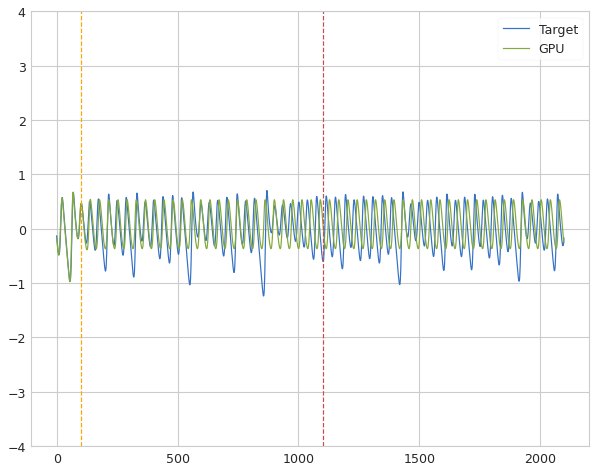

 Iter=57 a=0.676 sr=0.854 amp=1.589  ri=2.318 rr=2.193 loss=0.684546


Iter: 57 #### Diagnostic 0.684546   Time 8.45  Best 0.685 NRMSE 0.174 CD 0.511
Iter: 58 #### Diagnostic 1.192970   Time 7.37  Best 0.685 NRMSE 0.252 CD 0.941
Iter: 59 #### Diagnostic 1000.000000   Time 6.49  Best 0.685 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 8.22  Best 0.685 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 8.03  Best 0.685 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 5.17  Best 0.685 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000000   Time 6.84  Best 0.685 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000000   Time 8.58  Best 0.685 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1.342452   Time 6.20  Best 0.685 NRMSE 0.264 CD 1.079
Iter: 66 #### Diagnostic 1.303000   Time 7.82  Best 0.685 NRMSE 0.257 CD 1.046
Iter: 67 #### Diagnostic 1.174635   Time 7.52  Best 0.685 NRMSE 0.283 CD 0.892
Iter: 68 #### Diagnostic 1000.000000

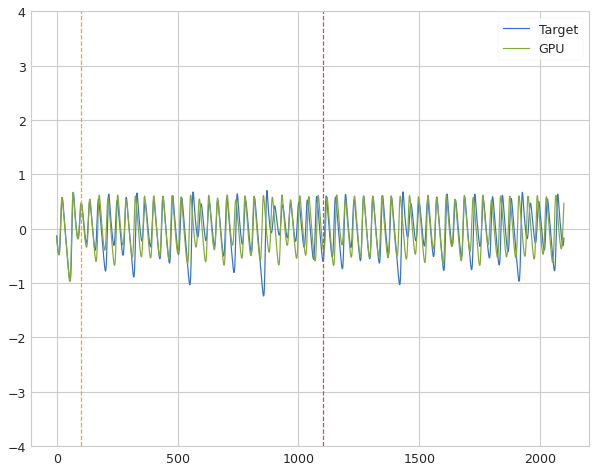

 Iter=86 a=0.602 sr=0.927 amp=1.625  ri=0.650 rr=1.013 loss=0.619491


Iter: 86 #### Diagnostic 0.619491   Time 7.04  Best 0.619 NRMSE 0.166 CD 0.453
Iter: 87 #### Diagnostic 1.242517   Time 7.48  Best 0.619 NRMSE 0.253 CD 0.990
Iter: 88 #### Diagnostic 1.257578   Time 7.47  Best 0.619 NRMSE 0.227 CD 1.030
Iter: 89 #### Diagnostic 1000.000000   Time 6.94  Best 0.619 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1.153840   Time 8.36  Best 0.619 NRMSE 0.221 CD 0.932
Iter: 91 #### Diagnostic 1.397991   Time 7.75  Best 0.619 NRMSE 0.316 CD 1.082
Iter: 92 #### Diagnostic 1.198116   Time 7.84  Best 0.619 NRMSE 0.231 CD 0.967
Iter: 93 #### Diagnostic 1000.000000   Time 6.96  Best 0.619 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1000.000000   Time 7.08  Best 0.619 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 2.294848   Time 8.57  Best 0.619 NRMSE 1.211 CD 1.084
Iter: 96 #### Diagnostic 1.504687   Time 6.89  Best 0.619 NRMSE 0.505 CD 1.000
Iter: 97 #### Diagnostic 1000.000000   Time 7.56

Iter: 82 #### Diagnostic 1.307555   Time 6.99  Best 1000.000 NRMSE 0.284 CD 1.023


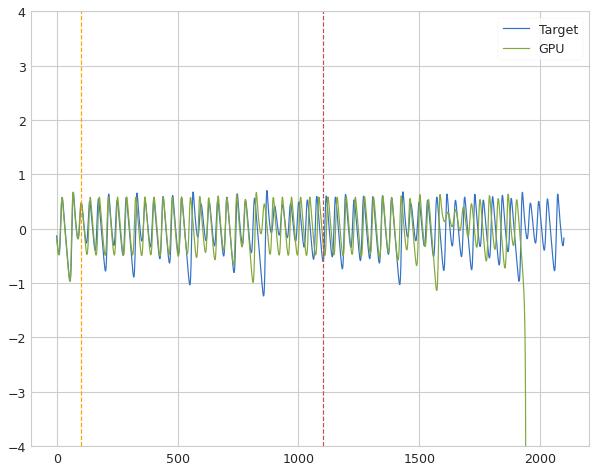

 Iter=83 a=0.598 sr=0.874 amp=1.501  ri=0.480 rr=2.989 loss=0.642478


Iter: 83 #### Diagnostic 0.642478   Time 8.96  Best 0.642 NRMSE 0.168 CD 0.475
Iter: 84 #### Diagnostic 1000.000000   Time 7.78  Best 0.642 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 155.580969   Time 8.76  Best 0.642 NRMSE 154.571 CD 1.010
Iter: 86 #### Diagnostic 1.316208   Time 7.55  Best 0.642 NRMSE 0.319 CD 0.997
Iter: 87 #### Diagnostic 0.945768   Time 6.76  Best 0.642 NRMSE 0.192 CD 0.754
Iter: 88 #### Diagnostic 1000.000000   Time 8.56  Best 0.642 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1.351620   Time 8.09  Best 0.642 NRMSE 0.436 CD 0.916
Iter: 90 #### Diagnostic 1.190007   Time 7.55  Best 0.642 NRMSE 0.187 CD 1.003
Iter: 91 #### Diagnostic 1.167445   Time 7.03  Best 0.642 NRMSE 0.199 CD 0.968
Iter: 92 #### Diagnostic 1000.000000   Time 8.44  Best 0.642 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1.298239   Time 8.44  Best 0.642 NRMSE 0.244 CD 1.054
Iter: 94 #### Diagnostic 1000.000000   Time 

Iter: 79 #### Diagnostic 1000.000000   Time 6.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1.099530   Time 6.84  Best 1000.000 NRMSE 0.249 CD 0.851
Iter: 81 #### Diagnostic 1.110219   Time 6.83  Best 1000.000 NRMSE 0.184 CD 0.927
Iter: 82 #### Diagnostic 1.408224   Time 7.33  Best 1000.000 NRMSE 0.414 CD 0.994
Iter: 83 #### Diagnostic 1000.000000   Time 6.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1.992935   Time 7.15  Best 1000.000 NRMSE 1.055 CD 0.938
Iter: 85 #### Diagnostic 1.681945   Time 7.13  Best 1000.000 NRMSE 0.646 CD 1.036
Iter: 86 #### Diagnostic 1000.000000   Time 7.77  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 2.014841   Time 7.30  Best 1000.000 NRMSE 1.051 CD 0.964
Iter: 88 #### Diagnostic 1.051016   Time 6.26  Best 1000.000 NRMSE 0.201 CD 0.850
Iter: 89 #### Diagnostic 1.181354   Time 7.39  Best 1000.000 NRMSE 0.201 CD 0.980
Iter: 90 #### Diagnostic 1000.000000   Time 8.09  Best 1000.000 NRMSE 40862739.227 CD 

Iter: 74 #### Diagnostic 1000.000000   Time 5.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1.044504   Time 7.92  Best 1000.000 NRMSE 0.204 CD 0.841
Iter: 76 #### Diagnostic 1.692354   Time 8.74  Best 1000.000 NRMSE 0.503 CD 1.189
Iter: 77 #### Diagnostic 1.138798   Time 6.37  Best 1000.000 NRMSE 0.185 CD 0.954
Iter: 78 #### Diagnostic 1.184965   Time 6.94  Best 1000.000 NRMSE 0.198 CD 0.987
Iter: 79 #### Diagnostic 1.166126   Time 8.73  Best 1000.000 NRMSE 0.195 CD 0.971
Iter: 80 #### Diagnostic 1000.000000   Time 8.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1.514429   Time 7.62  Best 1000.000 NRMSE 0.508 CD 1.006
Iter: 82 #### Diagnostic 1.185160   Time 7.73  Best 1000.000 NRMSE 0.205 CD 0.980
Iter: 83 #### Diagnostic 1.160795   Time 6.28  Best 1000.000 NRMSE 0.197 CD 0.964
Iter: 84 #### Diagnostic 1.297728   Time 7.74  Best 1000.000 NRMSE 0.243 CD 1.055
Iter: 85 #### Diagnostic 1000.000000   Time 7.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter

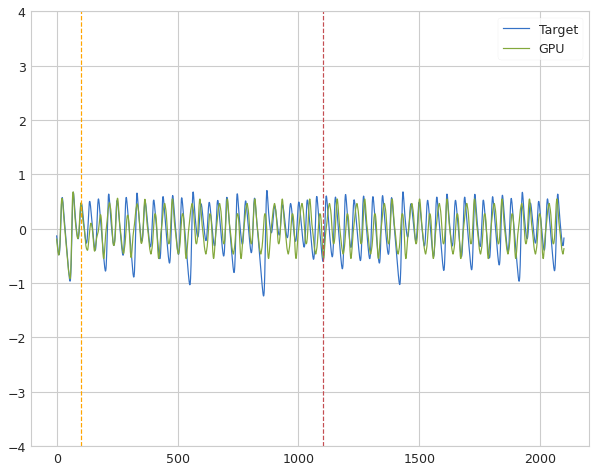

 Iter=17 a=0.690 sr=0.992 amp=1.505  ri=3.448 rr=2.543 loss=0.617333


Iter: 17 #### Diagnostic 0.617333   Time 7.25  Best 0.617 NRMSE 0.157 CD 0.461
Iter: 18 #### Diagnostic 1.324730   Time 5.71  Best 0.617 NRMSE 0.235 CD 1.090
Iter: 19 #### Diagnostic 1.200075   Time 7.24  Best 0.617 NRMSE 0.217 CD 0.983
Iter: 20 #### Diagnostic 1000.000000   Time 7.95  Best 0.617 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 5.416684   Time 6.04  Best 0.617 NRMSE 4.466 CD 0.951
Iter: 22 #### Diagnostic 1.364209   Time 6.24  Best 0.617 NRMSE 0.303 CD 1.061
Iter: 23 #### Diagnostic 1.320376   Time 7.97  Best 0.617 NRMSE 0.243 CD 1.078
Iter: 24 #### Diagnostic 1.235018   Time 7.06  Best 0.617 NRMSE 0.247 CD 0.988
Iter: 25 #### Diagnostic 1000.000000   Time 6.06  Best 0.617 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1.490452   Time 8.08  Best 0.617 NRMSE 0.498 CD 0.993
Iter: 27 #### Diagnostic 1.499168   Time 7.21  Best 0.617 NRMSE 0.528 CD 0.971
Iter: 28 #### Diagnostic 1.248386   Time 7.08  Best 

Iter: 8 #### Diagnostic 1000.000000   Time 7.29  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1.167172   Time 7.46  Best 1000.000 NRMSE 0.190 CD 0.977
Iter: 10 #### Diagnostic 1.390394   Time 6.20  Best 1000.000 NRMSE 0.532 CD 0.859
Iter: 11 #### Diagnostic 1.313493   Time 8.85  Best 1000.000 NRMSE 0.247 CD 1.066
Iter: 12 #### Diagnostic 1.121203   Time 6.38  Best 1000.000 NRMSE 0.182 CD 0.939
Iter: 13 #### Diagnostic 1.129849   Time 6.45  Best 1000.000 NRMSE 0.220 CD 0.909
Iter: 14 #### Diagnostic 1.274480   Time 6.68  Best 1000.000 NRMSE 0.253 CD 1.021
Iter: 15 #### Diagnostic 1000.000000   Time 6.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 6.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 7.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1.354343   Time 8.59  Best 1000.000 NRMSE 0.268 CD 1.086
Iter: 19 #### Diagnostic 1000.000000   Time 6.61  Best 1000.000 NRMSE 1000.000 CD na

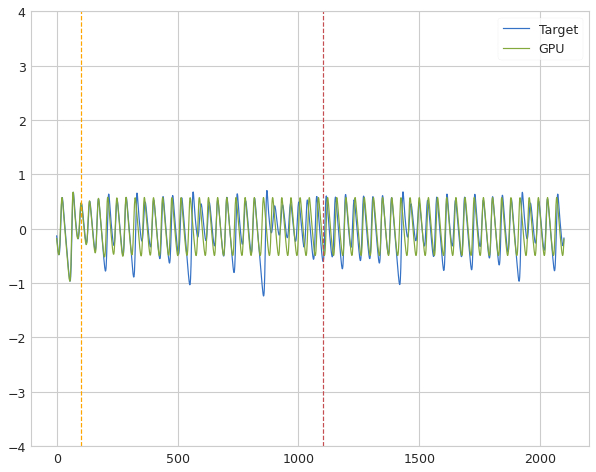

 Iter=75 a=0.653 sr=0.812 amp=1.521  ri=1.402 rr=0.610 loss=0.655438


Iter: 75 #### Diagnostic 0.655438   Time 7.74  Best 0.655 NRMSE 0.169 CD 0.486
Iter: 76 #### Diagnostic 1000.000000   Time 7.38  Best 0.655 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000000   Time 6.93  Best 0.655 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1000.000000   Time 6.61  Best 0.655 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000000   Time 6.97  Best 0.655 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1.372918   Time 8.77  Best 0.655 NRMSE 0.378 CD 0.995
Iter: 81 #### Diagnostic 2.207119   Time 7.81  Best 0.655 NRMSE 1.436 CD 0.771
Iter: 82 #### Diagnostic 1.070316   Time 6.36  Best 0.655 NRMSE 0.204 CD 0.867
Iter: 83 #### Diagnostic 1000.000000   Time 7.17  Best 0.655 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1.458983   Time 6.60  Best 0.655 NRMSE 0.469 CD 0.990
Iter: 85 #### Diagnostic 1000.000000   Time 8.70  Best 0.655 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1000.000000

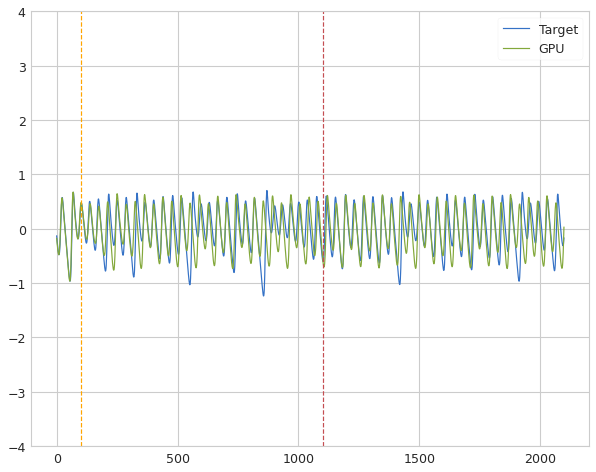

 Iter=67 a=0.631 sr=0.877 amp=1.647  ri=2.410 rr=3.012 loss=0.682729


Iter: 67 #### Diagnostic 0.682729   Time 5.95  Best 0.683 NRMSE 0.172 CD 0.511
Iter: 68 #### Diagnostic 1.184283   Time 6.84  Best 0.683 NRMSE 0.201 CD 0.983
Iter: 69 #### Diagnostic 1.042105   Time 7.43  Best 0.683 NRMSE 0.203 CD 0.839
Iter: 70 #### Diagnostic 1000.000000   Time 5.74  Best 0.683 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000000   Time 6.62  Best 0.683 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1.282803   Time 7.30  Best 0.683 NRMSE 0.295 CD 0.987
Iter: 73 #### Diagnostic 1.447848   Time 8.09  Best 0.683 NRMSE 0.461 CD 0.987
Iter: 74 #### Diagnostic 0.957999   Time 7.31  Best 0.683 NRMSE 0.221 CD 0.737
Iter: 75 #### Diagnostic 1.477575   Time 6.45  Best 0.683 NRMSE 0.468 CD 1.010
Iter: 76 #### Diagnostic 1.262326   Time 7.27  Best 0.683 NRMSE 0.253 CD 1.009
Iter: 77 #### Diagnostic 1.485261   Time 6.93  Best 0.683 NRMSE 0.439 CD 1.046
Iter: 78 #### Diagnostic 0.707448   Time 8.35  Best 

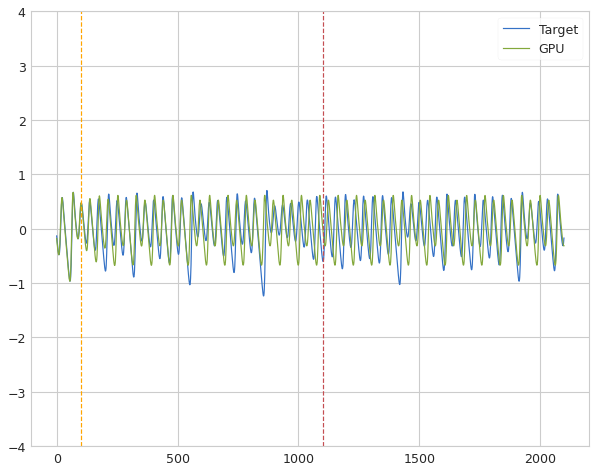

 Iter=84 a=0.632 sr=0.908 amp=1.698  ri=3.219 rr=2.387 loss=0.623607


Iter: 84 #### Diagnostic 0.623607   Time 6.22  Best 0.624 NRMSE 0.169 CD 0.454
Iter: 85 #### Diagnostic 1000.000000   Time 8.86  Best 0.624 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1000.000000   Time 7.20  Best 0.624 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 0.817195   Time 8.13  Best 0.624 NRMSE 0.181 CD 0.637
Iter: 88 #### Diagnostic 1000.000000   Time 6.73  Best 0.624 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1.078604   Time 7.22  Best 0.624 NRMSE 0.233 CD 0.846
Iter: 90 #### Diagnostic 1.504354   Time 6.88  Best 0.624 NRMSE 0.506 CD 0.998
Iter: 91 #### Diagnostic 1.443690   Time 7.76  Best 0.624 NRMSE 0.449 CD 0.995
Iter: 92 #### Diagnostic 1.152940   Time 8.15  Best 0.624 NRMSE 0.251 CD 0.902
Iter: 93 #### Diagnostic 0.997311   Time 8.29  Best 0.624 NRMSE 0.236 CD 0.761
Iter: 94 #### Diagnostic 1000.000000   Time 8.41  Best 0.624 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1000.000000   Time 

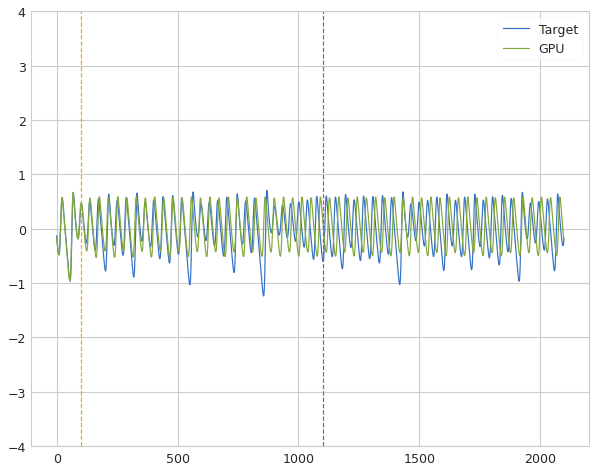

 Iter=21 a=0.620 sr=0.901 amp=1.452  ri=1.194 rr=1.076 loss=0.660090


Iter: 21 #### Diagnostic 0.660090   Time 9.08  Best 0.660 NRMSE 0.176 CD 0.484
Iter: 22 #### Diagnostic 1.501135   Time 8.44  Best 0.660 NRMSE 0.505 CD 0.996
Iter: 23 #### Diagnostic 1000.000000   Time 7.77  Best 0.660 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1.482629   Time 7.26  Best 0.660 NRMSE 0.296 CD 1.186
Iter: 25 #### Diagnostic 1000.000000   Time 8.62  Best 0.660 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 6.29  Best 0.660 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1.170789   Time 8.08  Best 0.660 NRMSE 0.196 CD 0.974
Iter: 28 #### Diagnostic 1000.000000   Time 7.39  Best 0.660 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 5.95  Best 0.660 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 6.63  Best 0.660 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1.161989   Time 6.83  Best 0.660 NRMSE 0.204 CD 0.958
Iter: 32 #### Diagnostic 1.503162   

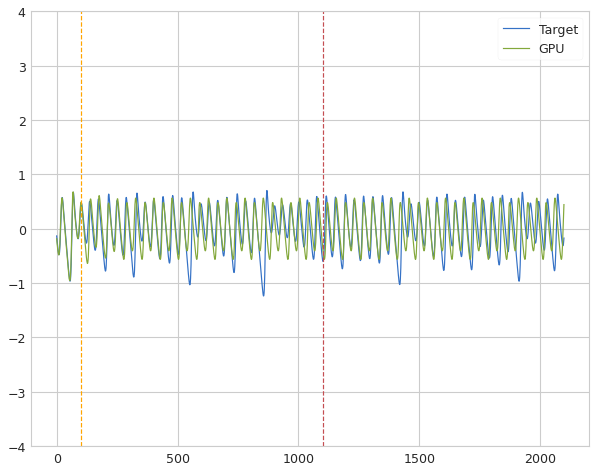

 Iter=49 a=0.625 sr=0.960 amp=1.421  ri=3.356 rr=2.761 loss=0.609762


Iter: 49 #### Diagnostic 0.609762   Time 8.28  Best 0.610 NRMSE 0.157 CD 0.452
Iter: 50 #### Diagnostic 1000.000000   Time 8.50  Best 0.610 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000000   Time 6.17  Best 0.610 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000000   Time 7.80  Best 0.610 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1.440217   Time 8.05  Best 0.610 NRMSE 0.264 CD 1.176
Iter: 54 #### Diagnostic 1000.000000   Time 6.02  Best 0.610 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000000   Time 8.70  Best 0.610 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 11.521288   Time 7.21  Best 0.610 NRMSE 10.531 CD 0.990
Iter: 57 #### Diagnostic 1000.000000   Time 7.05  Best 0.610 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1.151531   Time 8.72  Best 0.610 NRMSE 0.192 CD 0.959
Iter: 59 #### Diagnostic 0.639241   Time 7.74  Best 0.610 NRMSE 0.170 CD 0.469
Iter: 60 #### Diagnostic 1000.0000

Iter: 46 #### Diagnostic 1000.000000   Time 7.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Time 6.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1.296719   Time 7.39  Best 1000.000 NRMSE 0.196 CD 1.101
Iter: 49 #### Diagnostic 1.116235   Time 6.98  Best 1000.000 NRMSE 0.206 CD 0.910
Iter: 50 #### Diagnostic 1000.000000   Time 8.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000000   Time 6.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000000   Time 7.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 0.917830   Time 7.45  Best 1000.000 NRMSE 0.219 CD 0.699
Iter: 54 #### Diagnostic 1.246212   Time 7.79  Best 1000.000 NRMSE 0.217 CD 1.029
Iter: 55 #### Diagnostic 1.203553   Time 6.60  Best 1000.000 NRMSE 0.214 CD 0.990
Iter: 56 #### Diagnostic 1000.000000   Time 6.59  Best 1000.000 NRMSE 1594.292 CD 1.003
Iter: 57 #### Diagnostic 1000.000000   Time 9.56  Best 1000.000 NRMSE 10

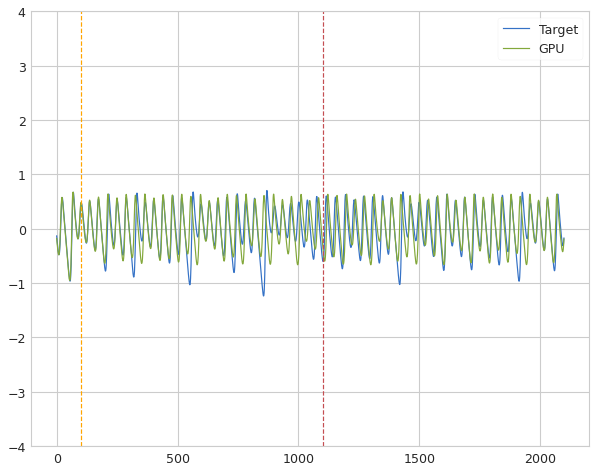

 Iter=75 a=0.655 sr=0.974 amp=1.598  ri=2.364 rr=0.519 loss=0.569538


Iter: 75 #### Diagnostic 0.569538   Time 8.45  Best 0.570 NRMSE 0.157 CD 0.412
Iter: 76 #### Diagnostic 1.116023   Time 6.56  Best 0.570 NRMSE 0.237 CD 0.879
Iter: 77 #### Diagnostic 0.921443   Time 8.32  Best 0.570 NRMSE 0.210 CD 0.711
Iter: 78 #### Diagnostic 1.305215   Time 6.35  Best 0.570 NRMSE 0.407 CD 0.898
Iter: 79 #### Diagnostic 1000.000000   Time 8.13  Best 0.570 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000000   Time 7.43  Best 0.570 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 2.453967   Time 7.08  Best 0.570 NRMSE 1.432 CD 1.022
Iter: 82 #### Diagnostic 1000.000000   Time 6.26  Best 0.570 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1.313744   Time 7.37  Best 0.570 NRMSE 0.227 CD 1.087
Iter: 84 #### Diagnostic 0.631730   Time 7.98  Best 0.570 NRMSE 0.165 CD 0.466
Iter: 85 #### Diagnostic 1.271604   Time 7.61  Best 0.570 NRMSE 0.273 CD 0.999
Iter: 86 #### Diagnostic 1000.000000   Time 6.48

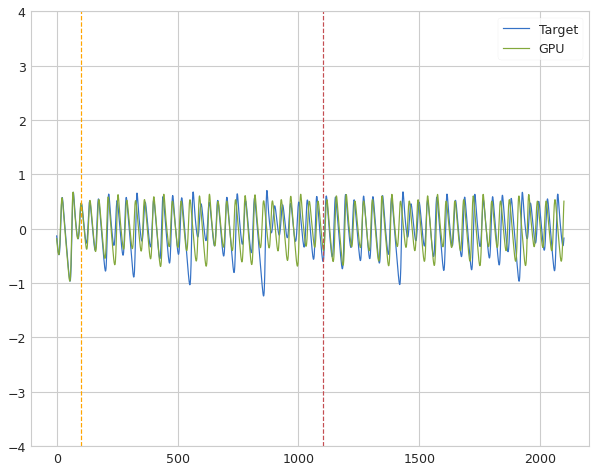

 Iter=13 a=0.563 sr=0.987 amp=1.480  ri=1.406 rr=3.807 loss=0.689479


Iter: 13 #### Diagnostic 0.689479   Time 6.42  Best 0.689 NRMSE 0.171 CD 0.518
Iter: 14 #### Diagnostic 1.241068   Time 8.91  Best 0.689 NRMSE 0.234 CD 1.007
Iter: 15 #### Diagnostic 1.190214   Time 8.13  Best 0.689 NRMSE 0.200 CD 0.990
Iter: 16 #### Diagnostic 1000.000000   Time 6.30  Best 0.689 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1.107565   Time 8.62  Best 0.689 NRMSE 0.193 CD 0.915
Iter: 18 #### Diagnostic 1000.000000   Time 6.54  Best 0.689 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1.978884   Time 7.10  Best 0.689 NRMSE 0.841 CD 1.138
Iter: 20 #### Diagnostic 1.674342   Time 6.17  Best 0.689 NRMSE 0.281 CD 1.394
Iter: 21 #### Diagnostic 1.477267   Time 7.58  Best 0.689 NRMSE 0.480 CD 0.997
Iter: 22 #### Diagnostic 1.358930   Time 6.75  Best 0.689 NRMSE 0.256 CD 1.103
Iter: 23 #### Diagnostic 1.423266   Time 6.78  Best 0.689 NRMSE 0.281 CD 1.142
Iter: 24 #### Diagnostic 1000.000000   Time 6.80  Be

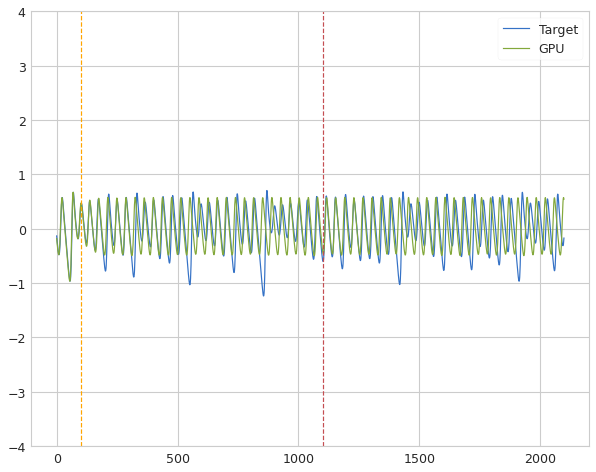

 Iter=1 a=0.584 sr=0.979 amp=1.648  ri=0.372 rr=3.559 loss=0.695548


Iter: 1 #### Diagnostic 0.695548   Time 8.38  Best 0.696 NRMSE 0.175 CD 0.521
Iter: 2 #### Diagnostic 1.091383   Time 7.06  Best 0.696 NRMSE 0.226 CD 0.865
Iter: 3 #### Diagnostic 1000.000000   Time 6.12  Best 0.696 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1.230516   Time 6.39  Best 0.696 NRMSE 0.217 CD 1.014


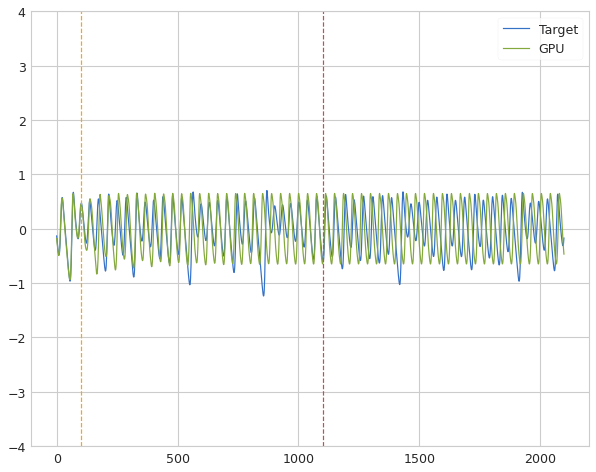

 Iter=5 a=0.573 sr=0.955 amp=1.545  ri=3.133 rr=0.181 loss=0.637078


Iter: 5 #### Diagnostic 0.637078   Time 6.53  Best 0.637 NRMSE 0.185 CD 0.452
Iter: 6 #### Diagnostic 1.066309   Time 7.39  Best 0.637 NRMSE 0.219 CD 0.847
Iter: 7 #### Diagnostic 1.192419   Time 10.31  Best 0.637 NRMSE 0.248 CD 0.945
Iter: 8 #### Diagnostic 1000.000000   Time 6.15  Best 0.637 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1.284888   Time 7.07  Best 0.637 NRMSE 0.243 CD 1.042
Iter: 10 #### Diagnostic 1000.000000   Time 6.48  Best 0.637 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.233627   Time 6.65  Best 0.637 NRMSE 0.254 CD 0.980
Iter: 12 #### Diagnostic 1000.000000   Time 8.37  Best 0.637 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1.282364   Time 6.02  Best 0.637 NRMSE 0.277 CD 1.006
Iter: 14 #### Diagnostic 1.255492   Time 5.16  Best 0.637 NRMSE 0.310 CD 0.945
Iter: 15 #### Diagnostic 1000.000000   Time 6.86  Best 0.637 NRMSE 1000.000 CD nan


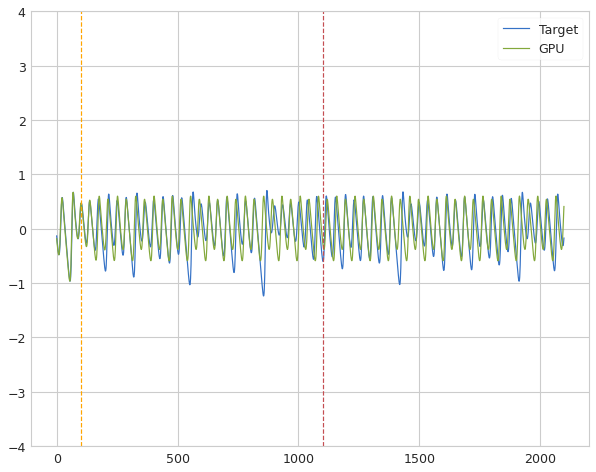

 Iter=16 a=0.608 sr=0.886 amp=1.565  ri=1.583 rr=1.638 loss=0.600843


Iter: 16 #### Diagnostic 0.600843   Time 7.64  Best 0.601 NRMSE 0.161 CD 0.440
Iter: 17 #### Diagnostic 1000.000000   Time 7.68  Best 0.601 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 0.943384   Time 7.91  Best 0.601 NRMSE 0.179 CD 0.765
Iter: 19 #### Diagnostic 1.316429   Time 5.79  Best 0.601 NRMSE 0.210 CD 1.107
Iter: 20 #### Diagnostic 1000.000000   Time 6.48  Best 0.601 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1.235077   Time 8.52  Best 0.601 NRMSE 0.265 CD 0.970
Iter: 22 #### Diagnostic 0.931376   Time 5.55  Best 0.601 NRMSE 0.179 CD 0.753
Iter: 23 #### Diagnostic 1.344312   Time 6.21  Best 0.601 NRMSE 0.253 CD 1.091
Iter: 24 #### Diagnostic 1.489890   Time 7.13  Best 0.601 NRMSE 0.489 CD 1.001
Iter: 25 #### Diagnostic 1.112098   Time 6.96  Best 0.601 NRMSE 0.211 CD 0.901
Iter: 26 #### Diagnostic 1000.000000   Time 7.33  Best 0.601 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1.154816   Time 7.24  B

Iter: 14 #### Diagnostic 1.530680   Time 9.27  Best 1000.000 NRMSE 0.288 CD 1.242
Iter: 15 #### Diagnostic 1.147934   Time 7.20  Best 1000.000 NRMSE 0.230 CD 0.918
Iter: 16 #### Diagnostic 1000.000000   Time 6.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1.138900   Time 9.55  Best 1000.000 NRMSE 0.222 CD 0.916
Iter: 18 #### Diagnostic 1.165359   Time 6.82  Best 1000.000 NRMSE 0.304 CD 0.861
Iter: 19 #### Diagnostic 1.119463   Time 7.37  Best 1000.000 NRMSE 0.185 CD 0.935
Iter: 20 #### Diagnostic 1000.000000   Time 7.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1.143769   Time 8.16  Best 1000.000 NRMSE 0.299 CD 0.844
Iter: 22 #### Diagnostic 1.411148   Time 7.60  Best 1000.000 NRMSE 0.419 CD 0.992
Iter: 23 #### Diagnostic 1.390613   Time 6.18  Best 1000.000 NRMSE 0.270 CD 1.121
Iter: 24 #### Diagnostic 1000.000000   Time 8.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 8.32  Best 1000.000 NRMSE 1000.000 CD nan


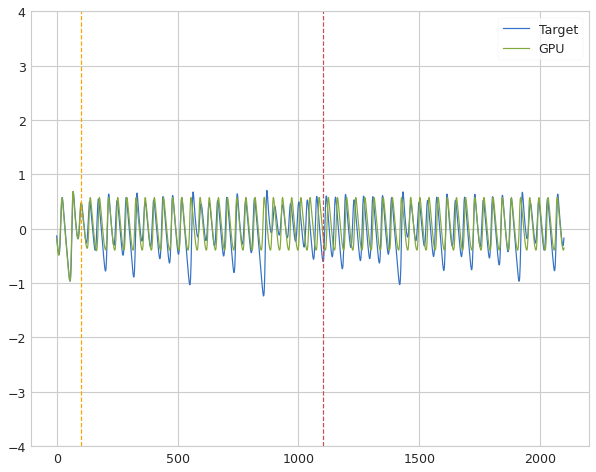

 Iter=43 a=0.676 sr=0.881 amp=1.566  ri=3.697 rr=0.257 loss=0.605522


Iter: 43 #### Diagnostic 0.605522   Time 8.27  Best 0.606 NRMSE 0.160 CD 0.445
Iter: 44 #### Diagnostic 1.509212   Time 7.61  Best 0.606 NRMSE 0.521 CD 0.988
Iter: 45 #### Diagnostic 1.418244   Time 7.04  Best 0.606 NRMSE 0.470 CD 0.949
Iter: 46 #### Diagnostic 1.529388   Time 7.79  Best 0.606 NRMSE 0.529 CD 1.000
Iter: 47 #### Diagnostic 1.083689   Time 7.60  Best 0.606 NRMSE 0.239 CD 0.844
Iter: 48 #### Diagnostic 6.858377   Time 6.75  Best 0.606 NRMSE 5.843 CD 1.016
Iter: 49 #### Diagnostic 1000.000000   Time 7.62  Best 0.606 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1.276174   Time 8.10  Best 0.606 NRMSE 0.248 CD 1.028
Iter: 51 #### Diagnostic 1.522832   Time 6.09  Best 0.606 NRMSE 0.286 CD 1.236
Iter: 52 #### Diagnostic 1.098383   Time 7.02  Best 0.606 NRMSE 0.217 CD 0.881
Iter: 53 #### Diagnostic 1.261130   Time 8.48  Best 0.606 NRMSE 0.271 CD 0.990
Iter: 54 #### Diagnostic 0.903887   Time 8.27  Best 0.60

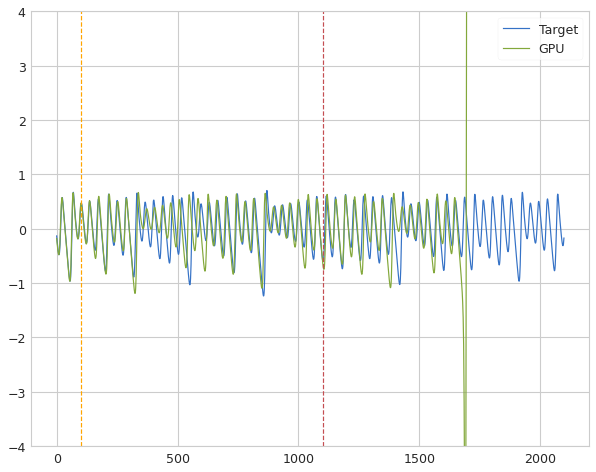

 Iter=23 a=0.568 sr=0.808 amp=1.700  ri=1.073 rr=1.030 loss=0.570885


Iter: 23 #### Diagnostic 0.570885   Time 8.11  Best 0.571 NRMSE 0.165 CD 0.406
Iter: 24 #### Diagnostic 0.824320   Time 5.79  Best 0.571 NRMSE 0.181 CD 0.643
Iter: 25 #### Diagnostic 1.180630   Time 5.41  Best 0.571 NRMSE 0.225 CD 0.955
Iter: 26 #### Diagnostic 2.102829   Time 7.53  Best 0.571 NRMSE 1.036 CD 1.067
Iter: 27 #### Diagnostic 1000.000000   Time 8.89  Best 0.571 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 5.37  Best 0.571 NRMSE 1000.000 CD 0.999
Iter: 29 #### Diagnostic 1.186098   Time 7.23  Best 0.571 NRMSE 0.201 CD 0.985
Iter: 30 #### Diagnostic 1000.000000   Time 5.96  Best 0.571 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000000   Time 6.79  Best 0.571 NRMSE 1000.000 CD 1.001
Iter: 32 #### Diagnostic 1.123303   Time 5.92  Best 0.571 NRMSE 0.239 CD 0.885
Iter: 33 #### Diagnostic 1000.000000   Time 6.10  Best 0.571 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1.497864   

Iter: 21 #### Diagnostic 1.485249   Time 7.16  Best 1000.000 NRMSE 0.482 CD 1.003
Iter: 22 #### Diagnostic 1000.000000   Time 5.29  Best 1000.000 NRMSE 1000.000 CD nan


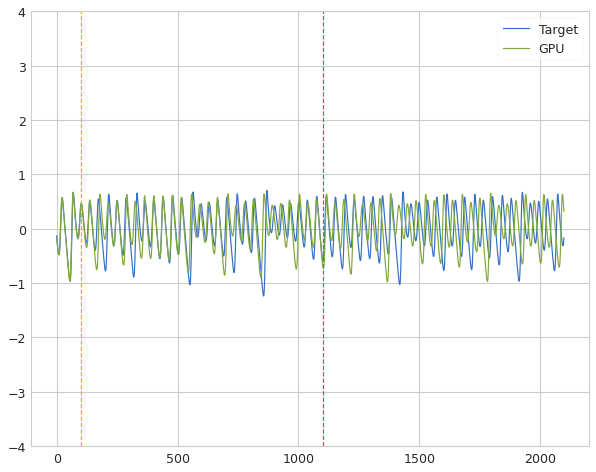

 Iter=23 a=0.635 sr=0.987 amp=1.645  ri=2.529 rr=3.021 loss=0.548630


Iter: 23 #### Diagnostic 0.548630   Time 7.04  Best 0.549 NRMSE 0.153 CD 0.396
Iter: 24 #### Diagnostic 0.894098   Time 8.53  Best 0.549 NRMSE 0.196 CD 0.698
Iter: 25 #### Diagnostic 1.254032   Time 5.73  Best 0.549 NRMSE 0.219 CD 1.035
Iter: 26 #### Diagnostic 1000.000000   Time 6.68  Best 0.549 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1.165637   Time 7.88  Best 0.549 NRMSE 0.194 CD 0.972
Iter: 28 #### Diagnostic 1000.000000   Time 6.09  Best 0.549 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.142654   Time 6.77  Best 0.549 NRMSE 0.195 CD 0.947
Iter: 30 #### Diagnostic 0.990865   Time 7.28  Best 0.549 NRMSE 0.198 CD 0.793
Iter: 31 #### Diagnostic 1000.000000   Time 7.49  Best 0.549 NRMSE 1000.000 CD 1.024
Iter: 32 #### Diagnostic 2.342318   Time 7.88  Best 0.549 NRMSE 1.298 CD 1.044
Iter: 33 #### Diagnostic 1000.000000   Time 8.30  Best 0.549 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000000   Tim

Iter: 21 #### Diagnostic 1000.000000   Time 7.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1.096345   Time 6.90  Best 1000.000 NRMSE 0.267 CD 0.829
Iter: 23 #### Diagnostic 0.913334   Time 6.47  Best 1000.000 NRMSE 0.176 CD 0.737
Iter: 24 #### Diagnostic 1.177257   Time 7.65  Best 1000.000 NRMSE 0.187 CD 0.990
Iter: 25 #### Diagnostic 1000.000000   Time 8.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1.391517   Time 6.76  Best 1000.000 NRMSE 0.414 CD 0.978
Iter: 27 #### Diagnostic 1.213979   Time 6.74  Best 1000.000 NRMSE 0.205 CD 1.009
Iter: 28 #### Diagnostic 1.608405   Time 8.42  Best 1000.000 NRMSE 0.614 CD 0.995
Iter: 29 #### Diagnostic 1.682508   Time 6.83  Best 1000.000 NRMSE 0.296 CD 1.386
Iter: 30 #### Diagnostic 1.054139   Time 6.96  Best 1000.000 NRMSE 0.207 CD 0.847
Iter: 31 #### Diagnostic 1000.000000   Time 5.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000000   Time 5.68  Best 1000.000 NRMSE 1000.000 CD nan


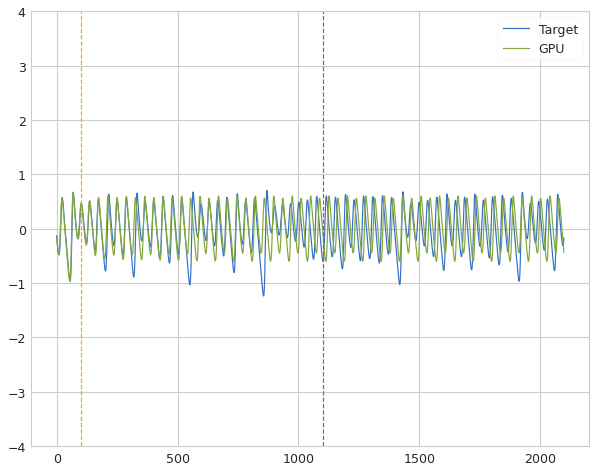

 Iter=48 a=0.655 sr=0.900 amp=1.582  ri=1.590 rr=0.427 loss=0.649333


Iter: 48 #### Diagnostic 0.649333   Time 8.01  Best 0.649 NRMSE 0.171 CD 0.478
Iter: 49 #### Diagnostic 1000.000000   Time 5.43  Best 0.649 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1.253264   Time 7.18  Best 0.649 NRMSE 0.259 CD 0.995
Iter: 51 #### Diagnostic 1000.000000   Time 7.30  Best 0.649 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000000   Time 5.88  Best 0.649 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 0.873530   Time 7.65  Best 0.649 NRMSE 0.199 CD 0.675
Iter: 54 #### Diagnostic 1.598276   Time 6.97  Best 0.649 NRMSE 0.293 CD 1.305
Iter: 55 #### Diagnostic 1000.000000   Time 7.25  Best 0.649 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1.236608   Time 6.94  Best 0.649 NRMSE 0.232 CD 1.005
Iter: 57 #### Diagnostic 1000.000000   Time 7.16  Best 0.649 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1.380905   Time 8.07  Best 0.649 NRMSE 0.280 CD 1.101
Iter: 59 #### Diagnostic 1.098455   Time

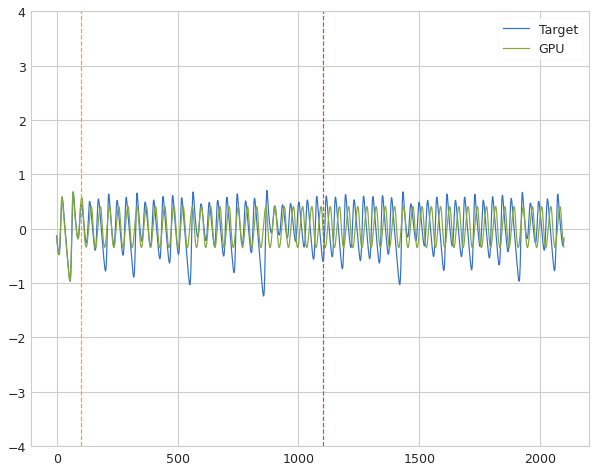

 Iter=73 a=0.648 sr=0.989 amp=1.423  ri=2.093 rr=2.583 loss=0.646918


Iter: 73 #### Diagnostic 0.646918   Time 7.56  Best 0.647 NRMSE 0.161 CD 0.486
Iter: 74 #### Diagnostic 1000.000000   Time 6.37  Best 0.647 NRMSE 679567015681.641 CD 1.011
Iter: 75 #### Diagnostic 1000.000000   Time 6.99  Best 0.647 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1.183055   Time 6.94  Best 0.647 NRMSE 0.196 CD 0.987
Iter: 77 #### Diagnostic 1000.000000   Time 7.65  Best 0.647 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1.137975   Time 6.05  Best 0.647 NRMSE 0.217 CD 0.921
Iter: 79 #### Diagnostic 1.249999   Time 6.87  Best 0.647 NRMSE 0.298 CD 0.952
Iter: 80 #### Diagnostic 1.165222   Time 6.98  Best 0.647 NRMSE 0.193 CD 0.972
Iter: 81 #### Diagnostic 1.414489   Time 7.10  Best 0.647 NRMSE 0.270 CD 1.145
Iter: 82 #### Diagnostic 1000.000000   Time 6.81  Best 0.647 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1000.000000   Time 5.94  Best 0.647 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1.449

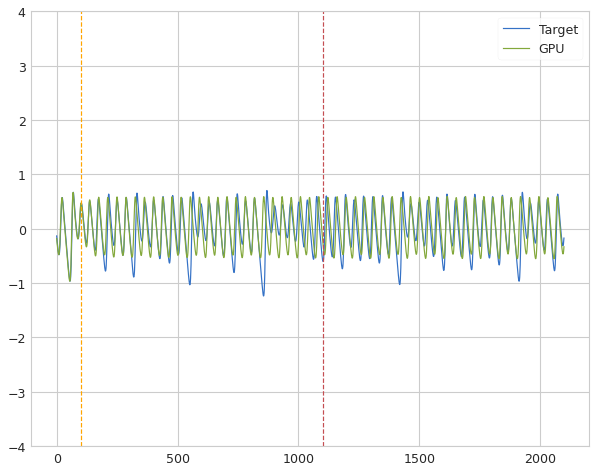

 Iter=94 a=0.564 sr=0.811 amp=1.581  ri=1.394 rr=2.293 loss=0.633258


Iter: 94 #### Diagnostic 0.633258   Time 8.27  Best 0.633 NRMSE 0.168 CD 0.466
Iter: 95 #### Diagnostic 1000.000000   Time 6.86  Best 0.633 NRMSE 1000.000 CD nan


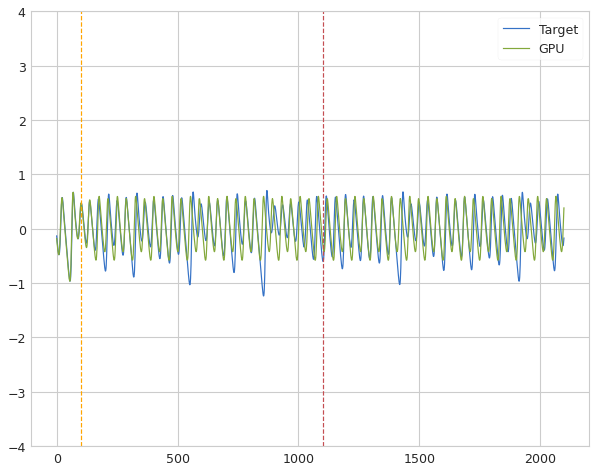

 Iter=96 a=0.660 sr=0.890 amp=1.589  ri=1.231 rr=3.917 loss=0.603206


Iter: 96 #### Diagnostic 0.603206   Time 7.74  Best 0.603 NRMSE 0.162 CD 0.441
Iter: 97 #### Diagnostic 1000.000000   Time 7.95  Best 0.603 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1.061589   Time 7.31  Best 0.603 NRMSE 0.205 CD 0.856
Iter: 99 #### Diagnostic 1000.000000   Time 7.03  Best 0.603 NRMSE 1000.000 CD nan

Best result = 0.603206353865922
a = 0.6598173750661253
sr = 0.8900296174584339
amp = 1.5888354098563389
ri = 1.2307367047084448
rr = 3.917107237058328

Best mn:0.564	 mn:0.676
New bounds mn--mx: -0.003--0.000

Best mn:0.808	 mn:0.989
New bounds mn--mx: -0.010--0.001

Best mn:1.423	 mn:1.700
New bounds mn--mx: -0.007---0.013

Best mn:0.372	 mn:3.697
New bounds mn--mx: -0.191---0.110

Best mn:0.181	 mn:3.917
New bounds mn--mx: -0.189---0.048
Refined search bounds:

Alpha (0.5667121505997104, 0.676490169620692)

Rho (0.8179713810490393, 0.9900822563285104)

Gamma (1.430583006016057, 1.686895097395251

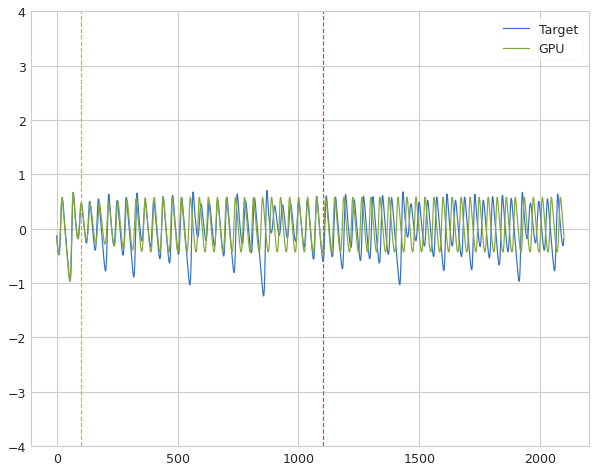

 Iter=12 a=0.600 sr=0.900 amp=1.616  ri=1.488 rr=0.635 loss=0.643056


Iter: 12 #### Diagnostic 0.643056   Time 8.02  Best 0.643 NRMSE 0.163 CD 0.480
Iter: 13 #### Diagnostic 1000.000000   Time 6.26  Best 0.643 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1.507914   Time 6.48  Best 0.643 NRMSE 0.508 CD 1.000
Iter: 15 #### Diagnostic 1000.000000   Time 6.38  Best 0.643 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 6.76  Best 0.643 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 7.59  Best 0.643 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000000   Time 7.70  Best 0.643 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 7.52  Best 0.643 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000000   Time 6.15  Best 0.643 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1.322942   Time 6.45  Best 0.643 NRMSE 0.271 CD 1.052
Iter: 22 #### Diagnostic 1.280231   Time 5.82  Best 0.643 NRMSE 0.260 CD 1.020
Iter: 23 #### Diagnostic 1000.00

Iter: 10 #### Diagnostic 1000.000000   Time 6.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000000   Time 6.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 6.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000000   Time 6.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 6.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1.102937   Time 6.88  Best 1000.000 NRMSE 0.207 CD 0.896
Iter: 16 #### Diagnostic 1.347915   Time 6.12  Best 1000.000 NRMSE 0.271 CD 1.077
Iter: 17 #### Diagnostic 1000.000000   Time 6.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000000   Time 7.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 0.714379   Time 8.32  Best 1000.000 NRMSE 0.181 CD 0.533
Iter: 20 #### Diagnostic 1000.000000   Time 6.34  Best 1000.000 NRMSE 2592111.254 CD 1.013
Iter: 21 #### Diagnostic 1.259704   Time 8.82  Best 1000.000 

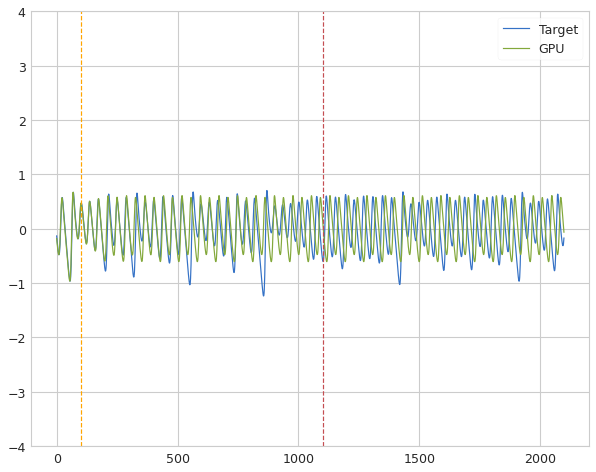

 Iter=64 a=0.691 sr=0.898 amp=1.551  ri=2.343 rr=3.310 loss=0.698702


Iter: 64 #### Diagnostic 0.698702   Time 7.97  Best 0.699 NRMSE 0.183 CD 0.516
Iter: 65 #### Diagnostic 1.204556   Time 6.22  Best 0.699 NRMSE 0.252 CD 0.952
Iter: 66 #### Diagnostic 1000.000000   Time 7.92  Best 0.699 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 6.86  Best 0.699 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1.093762   Time 4.99  Best 0.699 NRMSE 0.228 CD 0.866
Iter: 69 #### Diagnostic 1.543665   Time 7.75  Best 0.699 NRMSE 0.287 CD 1.257
Iter: 70 #### Diagnostic 1.290269   Time 6.69  Best 0.699 NRMSE 0.245 CD 1.045
Iter: 71 #### Diagnostic 1000.000000   Time 6.75  Best 0.699 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1.155288   Time 8.57  Best 0.699 NRMSE 0.208 CD 0.947
Iter: 73 #### Diagnostic 1.288714   Time 5.55  Best 0.699 NRMSE 0.259 CD 1.030
Iter: 74 #### Diagnostic 1.435126   Time 7.04  Best 0.699 NRMSE 0.453 CD 0.982
Iter: 75 #### Diagnostic 1.352146   Time 6.26  B

Iter: 60 #### Diagnostic 0.938758   Time 6.04  Best 1000.000 NRMSE 0.178 CD 0.761
Iter: 61 #### Diagnostic 0.897316   Time 7.16  Best 1000.000 NRMSE 0.215 CD 0.683
Iter: 62 #### Diagnostic 1.194894   Time 7.30  Best 1000.000 NRMSE 0.200 CD 0.995
Iter: 63 #### Diagnostic 1000.000000   Time 7.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1.379652   Time 7.58  Best 1000.000 NRMSE 0.265 CD 1.115
Iter: 65 #### Diagnostic 1.337346   Time 6.58  Best 1000.000 NRMSE 0.239 CD 1.098
Iter: 66 #### Diagnostic 1000.000000   Time 6.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 0.973335   Time 8.07  Best 1000.000 NRMSE 0.191 CD 0.783
Iter: 68 #### Diagnostic 1.103742   Time 6.92  Best 1000.000 NRMSE 0.226 CD 0.877
Iter: 69 #### Diagnostic 1000.000000   Time 7.61  Best 1000.000 NRMSE 1000.000 CD 1.074
Iter: 70 #### Diagnostic 1000.000000   Time 9.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1.140069   Time 6.74  Best 1000.000 NRMSE 0.182 CD 0.95

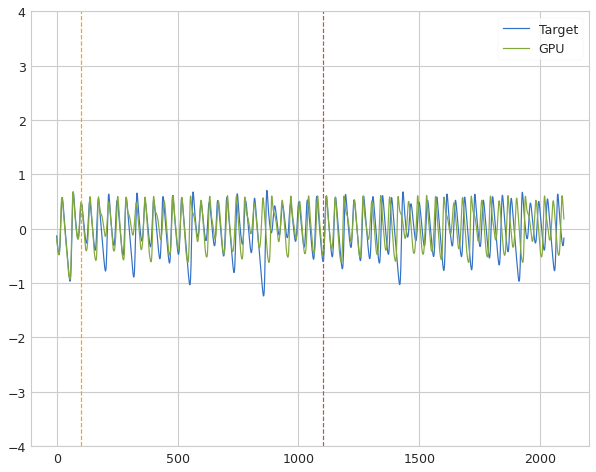

 Iter=14 a=0.602 sr=0.998 amp=1.624  ri=3.501 rr=3.726 loss=0.583086


Iter: 14 #### Diagnostic 0.583086   Time 6.29  Best 0.583 NRMSE 0.149 CD 0.434
Iter: 15 #### Diagnostic 1.431826   Time 5.35  Best 0.583 NRMSE 0.273 CD 1.159
Iter: 16 #### Diagnostic 1000.000000   Time 9.12  Best 0.583 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 7.15  Best 0.583 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 0.706720   Time 5.41  Best 0.583 NRMSE 0.182 CD 0.525
Iter: 19 #### Diagnostic 1.509069   Time 6.25  Best 0.583 NRMSE 0.509 CD 1.000
Iter: 20 #### Diagnostic 1.632633   Time 8.46  Best 0.583 NRMSE 0.637 CD 0.996
Iter: 21 #### Diagnostic 1.086946   Time 6.23  Best 0.583 NRMSE 0.245 CD 0.842
Iter: 22 #### Diagnostic 1.036485   Time 7.27  Best 0.583 NRMSE 0.229 CD 0.807
Iter: 23 #### Diagnostic 1.127556   Time 6.58  Best 0.583 NRMSE 0.231 CD 0.896
Iter: 24 #### Diagnostic 1.544472   Time 7.41  Best 0.583 NRMSE 0.289 CD 1.256
Iter: 25 #### Diagnostic 1.167146   Time 5.87  Best 

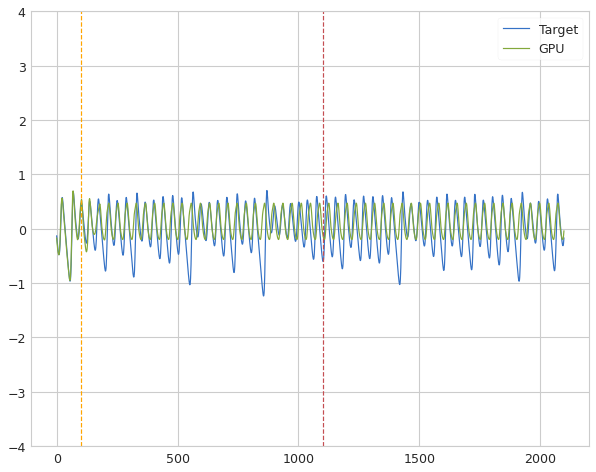

 Iter=12 a=0.689 sr=0.999 amp=1.696  ri=3.625 rr=3.072 loss=0.668142


Iter: 12 #### Diagnostic 0.668142   Time 8.38  Best 0.668 NRMSE 0.152 CD 0.516
Iter: 13 #### Diagnostic 1000.000000   Time 7.39  Best 0.668 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1.448690   Time 6.77  Best 0.668 NRMSE 0.455 CD 0.994
Iter: 15 #### Diagnostic 1000.000000   Time 7.57  Best 0.668 NRMSE 71985.331 CD 1.003
Iter: 16 #### Diagnostic 1.182817   Time 7.02  Best 0.668 NRMSE 0.202 CD 0.981
Iter: 17 #### Diagnostic 1.134936   Time 5.48  Best 0.668 NRMSE 0.182 CD 0.953
Iter: 18 #### Diagnostic 1.522182   Time 7.55  Best 0.668 NRMSE 0.528 CD 0.994
Iter: 19 #### Diagnostic 1000.000000   Time 7.21  Best 0.668 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1.284041   Time 6.64  Best 0.668 NRMSE 0.254 CD 1.030
Iter: 21 #### Diagnostic 1.171534   Time 7.31  Best 0.668 NRMSE 0.190 CD 0.982
Iter: 22 #### Diagnostic 1000.000000   Time 6.67  Best 0.668 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.231401   Time 

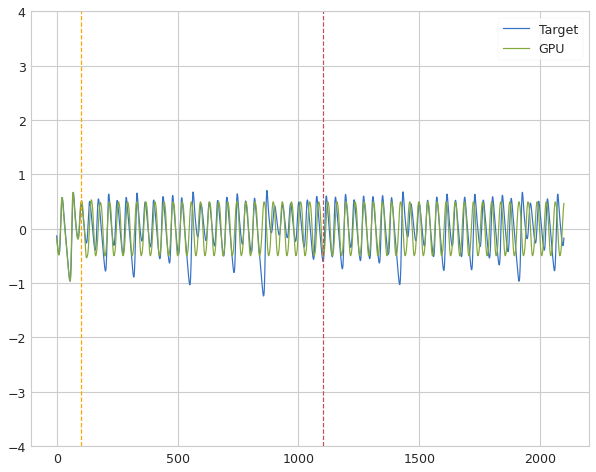

 Iter=44 a=0.587 sr=0.823 amp=1.468  ri=3.472 rr=3.548 loss=0.571533


Iter: 44 #### Diagnostic 0.571533   Time 7.78  Best 0.572 NRMSE 0.156 CD 0.416
Iter: 45 #### Diagnostic 1000.000000   Time 7.43  Best 0.572 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1.273871   Time 7.41  Best 0.572 NRMSE 0.248 CD 1.025
Iter: 47 #### Diagnostic 1000.000000   Time 7.02  Best 0.572 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 7.94  Best 0.572 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000000   Time 5.89  Best 0.572 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000000   Time 7.05  Best 0.572 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1.090510   Time 7.26  Best 0.572 NRMSE 0.226 CD 0.865
Iter: 52 #### Diagnostic 1000.000000   Time 8.41  Best 0.572 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1.136387   Time 6.75  Best 0.572 NRMSE 0.201 CD 0.936
Iter: 54 #### Diagnostic 1.088491   Time 7.16  Best 0.572 NRMSE 0.183 CD 0.905
Iter: 55 #### Diagnostic 1.505951   

Iter: 34 #### Diagnostic 1000.000000   Time 6.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1.525140   Time 6.08  Best 1000.000 NRMSE 0.528 CD 0.997
Iter: 36 #### Diagnostic 1.421537   Time 7.80  Best 1000.000 NRMSE 0.269 CD 1.152
Iter: 37 #### Diagnostic 1.112500   Time 7.84  Best 1000.000 NRMSE 0.200 CD 0.912
Iter: 38 #### Diagnostic 1.316242   Time 7.50  Best 1000.000 NRMSE 0.242 CD 1.074
Iter: 39 #### Diagnostic 1.072463   Time 7.40  Best 1000.000 NRMSE 0.224 CD 0.849
Iter: 40 #### Diagnostic 1.162320   Time 7.12  Best 1000.000 NRMSE 0.192 CD 0.971


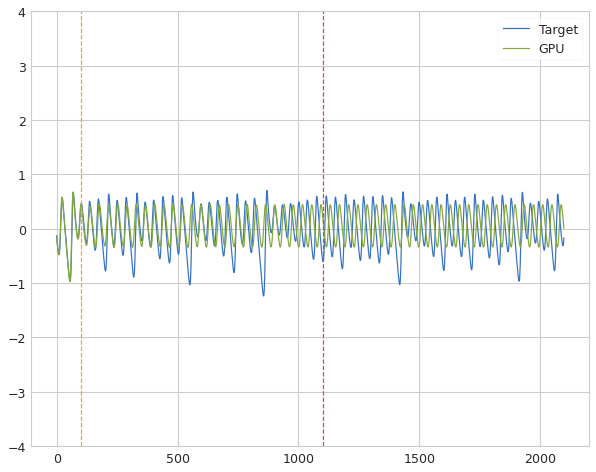

 Iter=41 a=0.638 sr=0.822 amp=1.509  ri=1.682 rr=2.618 loss=0.671887


Iter: 41 #### Diagnostic 0.671887   Time 7.55  Best 0.672 NRMSE 0.163 CD 0.509
Iter: 42 #### Diagnostic 1.654528   Time 7.44  Best 0.672 NRMSE 0.808 CD 0.847
Iter: 43 #### Diagnostic 1.151040   Time 5.76  Best 0.672 NRMSE 0.191 CD 0.960
Iter: 44 #### Diagnostic 1.308769   Time 7.35  Best 0.672 NRMSE 0.237 CD 1.072
Iter: 45 #### Diagnostic 1.133173   Time 5.98  Best 0.672 NRMSE 0.278 CD 0.855
Iter: 46 #### Diagnostic 1000.000000   Time 5.92  Best 0.672 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Time 8.57  Best 0.672 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1.134148   Time 7.56  Best 0.672 NRMSE 0.194 CD 0.940
Iter: 49 #### Diagnostic 1.201783   Time 7.94  Best 0.672 NRMSE 0.205 CD 0.997
Iter: 50 #### Diagnostic 1.523202   Time 6.83  Best 0.672 NRMSE 0.526 CD 0.998
Iter: 51 #### Diagnostic 1000.000000   Time 7.55  Best 0.672 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1.181445   Time 6.94  B

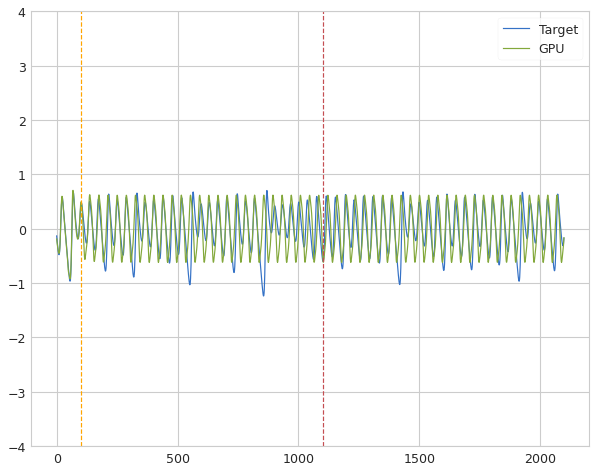

 Iter=55 a=0.696 sr=0.972 amp=1.418  ri=2.395 rr=2.473 loss=0.640974


Iter: 55 #### Diagnostic 0.640974   Time 7.61  Best 0.641 NRMSE 0.175 CD 0.466
Iter: 56 #### Diagnostic 1.117361   Time 7.60  Best 0.641 NRMSE 0.181 CD 0.936
Iter: 57 #### Diagnostic 1.403662   Time 6.46  Best 0.641 NRMSE 0.317 CD 1.087
Iter: 58 #### Diagnostic 1.345046   Time 8.21  Best 0.641 NRMSE 0.277 CD 1.068
Iter: 59 #### Diagnostic 1.520371   Time 7.54  Best 0.641 NRMSE 0.520 CD 1.000
Iter: 60 #### Diagnostic 1.071677   Time 6.04  Best 0.641 NRMSE 0.198 CD 0.874
Iter: 61 #### Diagnostic 1.159966   Time 6.28  Best 0.641 NRMSE 0.227 CD 0.933
Iter: 62 #### Diagnostic 1.454005   Time 8.81  Best 0.641 NRMSE 0.468 CD 0.986
Iter: 63 #### Diagnostic 1.262702   Time 8.21  Best 0.641 NRMSE 0.226 CD 1.037
Iter: 64 #### Diagnostic 1000.000000   Time 6.81  Best 0.641 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1.497726   Time 7.09  Best 0.641 NRMSE 0.502 CD 0.996
Iter: 66 #### Diagnostic 1.319196   Time 7.50  Best 0.64

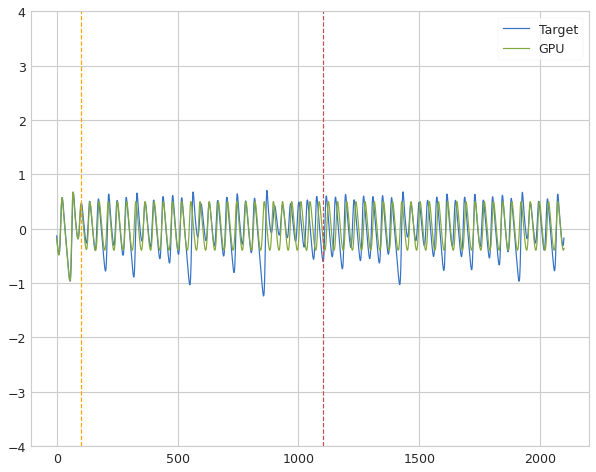

 Iter=76 a=0.640 sr=0.900 amp=1.567  ri=2.727 rr=2.505 loss=0.582359


Iter: 76 #### Diagnostic 0.582359   Time 6.89  Best 0.582 NRMSE 0.150 CD 0.432
Iter: 77 #### Diagnostic 1.536317   Time 8.37  Best 0.582 NRMSE 0.537 CD 0.999
Iter: 78 #### Diagnostic 1000.000000   Time 6.31  Best 0.582 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1.088988   Time 5.88  Best 0.582 NRMSE 0.214 CD 0.875
Iter: 80 #### Diagnostic 1.009066   Time 6.34  Best 0.582 NRMSE 0.218 CD 0.791
Iter: 81 #### Diagnostic 1.089564   Time 6.29  Best 0.582 NRMSE 0.213 CD 0.877
Iter: 82 #### Diagnostic 1.298308   Time 7.59  Best 0.582 NRMSE 0.213 CD 1.085
Iter: 83 #### Diagnostic 1.517245   Time 7.18  Best 0.582 NRMSE 0.525 CD 0.993
Iter: 84 #### Diagnostic 1000.000000   Time 6.60  Best 0.582 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1.131571   Time 5.21  Best 0.582 NRMSE 0.191 CD 0.940
Iter: 86 #### Diagnostic 1.132018   Time 6.62  Best 0.582 NRMSE 0.202 CD 0.930
Iter: 87 #### Diagnostic 1.228013   Time 7.54  Best 

Iter: 73 #### Diagnostic 15.763702   Time 6.86  Best 1000.000 NRMSE 14.748 CD 1.015
Iter: 74 #### Diagnostic 1.317263   Time 5.58  Best 1000.000 NRMSE 0.257 CD 1.061
Iter: 75 #### Diagnostic 1.166130   Time 7.78  Best 1000.000 NRMSE 0.185 CD 0.981
Iter: 76 #### Diagnostic 1.455366   Time 7.29  Best 1000.000 NRMSE 0.450 CD 1.006
Iter: 77 #### Diagnostic 1.464296   Time 5.16  Best 1000.000 NRMSE 0.440 CD 1.025
Iter: 78 #### Diagnostic 1.384012   Time 8.57  Best 1000.000 NRMSE 0.392 CD 0.992
Iter: 79 #### Diagnostic 1000.000000   Time 6.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1.299273   Time 5.57  Best 1000.000 NRMSE 0.234 CD 1.065
Iter: 81 #### Diagnostic 1.344831   Time 8.28  Best 1000.000 NRMSE 0.245 CD 1.100
Iter: 82 #### Diagnostic 1.066255   Time 5.52  Best 1000.000 NRMSE 0.222 CD 0.844
Iter: 83 #### Diagnostic 71.322146   Time 8.39  Best 1000.000 NRMSE 70.389 CD 0.933
Iter: 84 #### Diagnostic 1.128208   Time 5.65  Best 1000.000 NRMSE 0.189 CD 0.939
Iter: 85

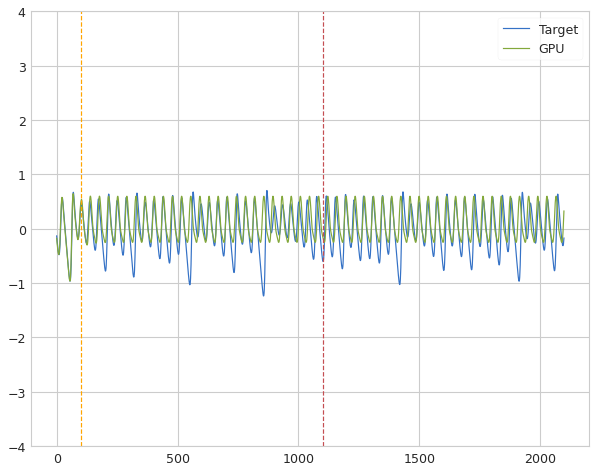

 Iter=4 a=0.596 sr=0.917 amp=1.482  ri=1.819 rr=3.031 loss=0.626212


Iter: 4 #### Diagnostic 0.626212   Time 6.18  Best 0.626 NRMSE 0.159 CD 0.468
Iter: 5 #### Diagnostic 1.201501   Time 7.45  Best 0.626 NRMSE 0.203 CD 0.999
Iter: 6 #### Diagnostic 1.228801   Time 7.48  Best 0.626 NRMSE 0.252 CD 0.977
Iter: 7 #### Diagnostic 1000.000000   Time 7.55  Best 0.626 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 6.90  Best 0.626 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 0.900708   Time 8.02  Best 0.626 NRMSE 0.207 CD 0.694
Iter: 10 #### Diagnostic 1000.000000   Time 7.96  Best 0.626 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.104559   Time 7.90  Best 0.626 NRMSE 0.226 CD 0.879
Iter: 12 #### Diagnostic 1.285929   Time 6.64  Best 0.626 NRMSE 0.233 CD 1.053
Iter: 13 #### Diagnostic 34.125482   Time 7.26  Best 0.626 NRMSE 33.112 CD 1.014
Iter: 14 #### Diagnostic 1.207387   Time 7.05  Best 0.626 NRMSE 0.218 CD 0.989
Iter: 15 #### Diagnostic 1.284213   Time 6.10  Best 0

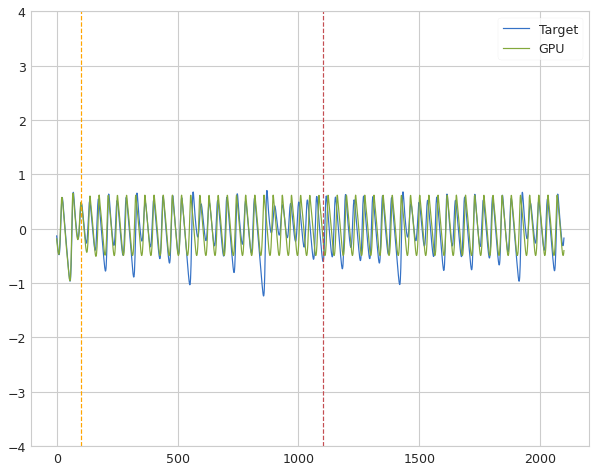

 Iter=55 a=0.657 sr=0.958 amp=1.427  ri=1.727 rr=3.658 loss=0.590220


Iter: 55 #### Diagnostic 0.590220   Time 8.55  Best 0.590 NRMSE 0.162 CD 0.429
Iter: 56 #### Diagnostic 1.164062   Time 6.71  Best 0.590 NRMSE 0.233 CD 0.931
Iter: 57 #### Diagnostic 1000.000000   Time 7.29  Best 0.590 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 6.99  Best 0.590 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1.369514   Time 5.97  Best 0.590 NRMSE 0.251 CD 1.119
Iter: 60 #### Diagnostic 0.899565   Time 6.01  Best 0.590 NRMSE 0.203 CD 0.697
Iter: 61 #### Diagnostic 1000.000000   Time 6.90  Best 0.590 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 7.11  Best 0.590 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1.179335   Time 7.45  Best 0.590 NRMSE 0.203 CD 0.976
Iter: 64 #### Diagnostic 1.309974   Time 6.39  Best 0.590 NRMSE 0.328 CD 0.982
Iter: 65 #### Diagnostic 1.259467   Time 8.99  Best 0.590 NRMSE 0.255 CD 1.004
Iter: 66 #### Diagnostic 0.915706   Time 6.5

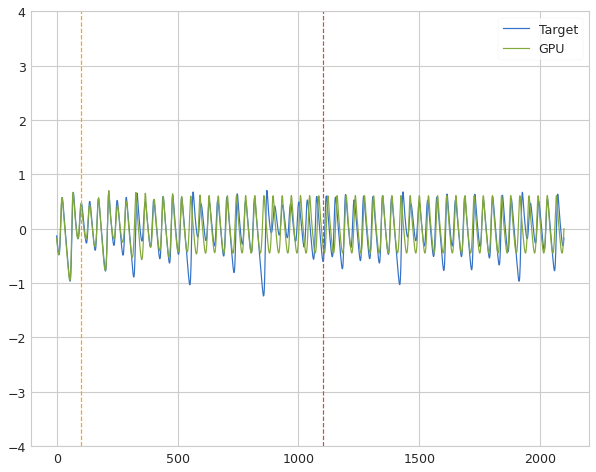

 Iter=16 a=0.599 sr=0.987 amp=1.683  ri=0.335 rr=0.781 loss=0.562119


Iter: 16 #### Diagnostic 0.562119   Time 8.02  Best 0.562 NRMSE 0.154 CD 0.408
Iter: 17 #### Diagnostic 1.162704   Time 7.58  Best 0.562 NRMSE 0.193 CD 0.969
Iter: 18 #### Diagnostic 1.282211   Time 6.50  Best 0.562 NRMSE 0.235 CD 1.048
Iter: 19 #### Diagnostic 1.199951   Time 7.35  Best 0.562 NRMSE 0.287 CD 0.913
Iter: 20 #### Diagnostic 1000.000000   Time 6.13  Best 0.562 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1.456344   Time 6.87  Best 0.562 NRMSE 0.259 CD 1.198
Iter: 22 #### Diagnostic 1.263283   Time 8.36  Best 0.562 NRMSE 0.205 CD 1.058
Iter: 23 #### Diagnostic 1.156670   Time 6.63  Best 0.562 NRMSE 0.229 CD 0.928
Iter: 24 #### Diagnostic 1.417902   Time 8.24  Best 0.562 NRMSE 0.255 CD 1.162
Iter: 25 #### Diagnostic 1.149638   Time 7.81  Best 0.562 NRMSE 0.206 CD 0.944
Iter: 26 #### Diagnostic 1.054717   Time 8.04  Best 0.562 NRMSE 0.183 CD 0.872
Iter: 27 #### Diagnostic 1000.000000   Time 7.69  Best 0

Iter: 15 #### Diagnostic 1000.000000   Time 8.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1.275876   Time 7.05  Best 1000.000 NRMSE 0.269 CD 1.007


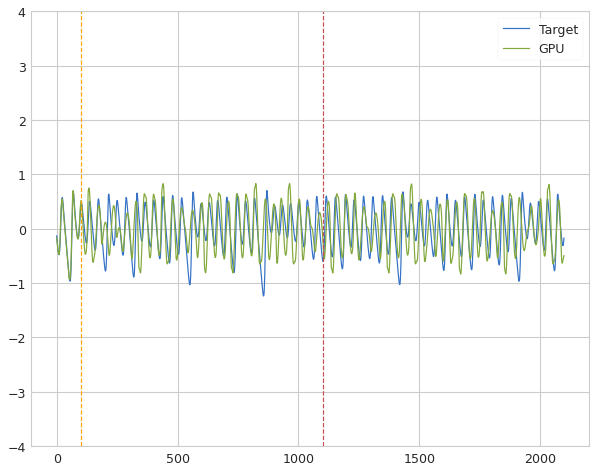

 Iter=17 a=0.690 sr=0.992 amp=1.505  ri=3.448 rr=2.543 loss=0.634785


Iter: 17 #### Diagnostic 0.634785   Time 7.11  Best 0.635 NRMSE 0.180 CD 0.455
Iter: 18 #### Diagnostic 1.307061   Time 7.45  Best 0.635 NRMSE 0.213 CD 1.094
Iter: 19 #### Diagnostic 1.285357   Time 6.51  Best 0.635 NRMSE 0.258 CD 1.027
Iter: 20 #### Diagnostic 1.027674   Time 7.75  Best 0.635 NRMSE 0.200 CD 0.827
Iter: 21 #### Diagnostic 1.175640   Time 8.28  Best 0.635 NRMSE 0.199 CD 0.977
Iter: 22 #### Diagnostic 1.059722   Time 6.23  Best 0.635 NRMSE 0.228 CD 0.832
Iter: 23 #### Diagnostic 1.615881   Time 7.80  Best 0.635 NRMSE 0.563 CD 1.053
Iter: 24 #### Diagnostic 1.088133   Time 5.85  Best 0.635 NRMSE 0.210 CD 0.878
Iter: 25 #### Diagnostic 1000.000000   Time 6.93  Best 0.635 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 6.93  Best 0.635 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1.553179   Time 7.54  Best 0.635 NRMSE 0.531 CD 1.022
Iter: 28 #### Diagnostic 1.147156   Time 6.74  Best 

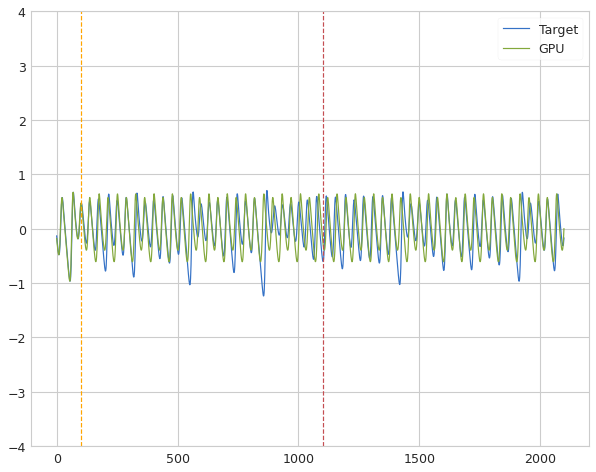

 Iter=55 a=0.679 sr=0.914 amp=1.589  ri=0.747 rr=0.826 loss=0.604558


Iter: 55 #### Diagnostic 0.604558   Time 4.96  Best 0.605 NRMSE 0.166 CD 0.438
Iter: 56 #### Diagnostic 1.150573   Time 4.77  Best 0.605 NRMSE 0.187 CD 0.964
Iter: 57 #### Diagnostic 1.138796   Time 5.48  Best 0.605 NRMSE 0.186 CD 0.952
Iter: 58 #### Diagnostic 1.327066   Time 4.56  Best 0.605 NRMSE 0.300 CD 1.027


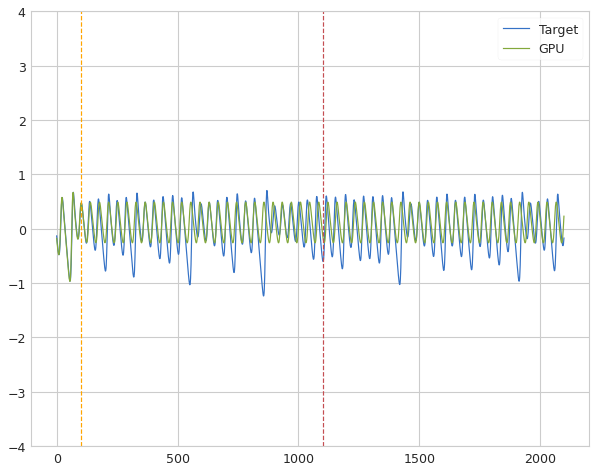

 Iter=59 a=0.614 sr=0.885 amp=1.625  ri=1.562 rr=2.633 loss=0.595825


Iter: 59 #### Diagnostic 0.595825   Time 5.42  Best 0.596 NRMSE 0.145 CD 0.451
Iter: 60 #### Diagnostic 1000.000000   Time 4.73  Best 0.596 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1.138042   Time 4.71  Best 0.596 NRMSE 0.184 CD 0.954
Iter: 62 #### Diagnostic 1000.000000   Time 4.78  Best 0.596 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1.089178   Time 5.06  Best 0.596 NRMSE 0.184 CD 0.905
Iter: 64 #### Diagnostic 1.541251   Time 4.50  Best 0.596 NRMSE 0.407 CD 1.134
Iter: 65 #### Diagnostic 1000.000000   Time 4.73  Best 0.596 NRMSE 1000.000 CD nan


In [ ]:
CALLS = 100
s = torch.torch.from_numpy(signal).cuda(DEVICE).type(dtype)
# Skipped 1000
size = [40,30,20,10]
rand_state = [11,37,3,24,91]

for N in size:
    min_a, max_a = .55, .7
    min_sr, max_sr = .8, 1.
    min_g, max_g = 1.4, 1.7
    min_ri, max_ri = .001, 4.
    min_rr, max_rr = .001, 4.
    space = [Real(min_a, max_a, name='a'),
                     Real(min_sr, max_sr, name='sr'),
                     Real(min_g, max_g, name='amp'), 
                     Real(min_ri, max_ri, name='ri'),
                     Real(min_rr, max_rr, name='rr')
                    ]
    for ref in range(5):
        start = time.time()
        alphas = []
        rhos = []
        gammas = []
        inScales = []
        resScales = []
        
        for rn in range(5):
            running_error = 1000
            counter = 0 
            print(f'********** Size {N} -- Run {rn} ***********')
            result_gp = gp_minimize(loop,
                                    space,
                                    n_calls=CALLS,
                                    random_state=rand_state[rn],
                                    n_jobs=-1,
                                    n_initial_points=100)
            print(f'\nBest result = {result_gp.fun}')
            names = ['a','sr','amp','ri','rr']
            for i in range(len(space)):
                print(f'{names[i]} = {result_gp.x[i]}')
                
        min_a, max_a   = resize_spaces(min_a, max_a,
                                       np.array(alphas),
                                       isAlpha=True)
        min_sr, max_sr = resize_spaces(min_sr, max_sr, np.array(rhos))
        min_g, max_g   = resize_spaces(min_g, max_g, np.array(gammas))
        min_ri, max_ri = resize_spaces(min_ri, max_ri, np.array(inScales))
        min_rr, max_rr = resize_spaces(min_rr, max_rr, np.array(resScales))
        print('Refined search bounds:\n')
        print(f'Alpha ({min_a}, {max_a})\n')
        print(f'Rho ({min_sr}, {max_sr})\n')
        print(f'Gamma ({min_g}, {max_g})\n')
        print(f'r-in ({min_ri}, {max_ri})\n')
        print(f'r-res ({min_rr}, {max_rr})\n')
        end = time.time()-start
        print(f'End Refinement Run {ref} Time {end:.3f}')